In [19]:
# import nbimporter
import os
# import math
# import statistics
import numpy as np 
from astropy.io import fits 
# from smooth_kevin import smoother
# from Full_Auto import *
# from Process_Looping_INCLUDED import *
# from Process_Looping_EXCLUDED import *
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
# import py_specrebin
# import pandas as pd
# from scipy.signal import hilbert
plt.style.use('dark_background')
path_name = './Optimized Data (New)'

## Getting the data

In [3]:
new_wave_600 = np.arange(4000, 11000, .65)
new_wave_1200 = np.arange(6000, 11000, .33) 

In [4]:
rbwave = new_wave_600
len(rbwave)

10770

In [5]:
mask_name = 'C1M33P' #Put the mask name here

In [6]:
def read_opt_data(mask_name,inc_or_exc):
    mypath = path_name + '/{0}/{1}/'.format(mask_name,inc_or_exc)
    myfiles = [f for f in os.listdir(mypath) if f.endswith('.fits.gz')]
    
    flux_dict = {}
    for f in myfiles:
        
        hdul = fits.open(mypath+f)
        spec = hdul[1].data['OPTIMIZED_SPECTRUM']
        hdul.close()
        
        slit = int(f.split('.')[0].split('_')[-1])
    
        flux_dict[slit] = spec
    
    return flux_dict

In [7]:
excluded_fluxes_dict = read_opt_data(mask_name,'Excluded')
included_fluxes_dict = read_opt_data(mask_name,'Included')

In [8]:
slit_nums_exclude = list(excluded_fluxes_dict.keys())
slit_nums_exclude.sort()
print('Excluded slits: ',slit_nums_exclude)
slit_nums = list(included_fluxes_dict.keys())
slit_nums.sort()
print('Included slits: ',slit_nums)

Excluded slits:  [0, 9, 16, 23, 24, 33, 36, 37, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 55, 56, 58, 62, 64, 67, 68, 71, 72, 73, 74, 76, 77, 79, 81, 82, 84, 85, 87, 88, 89, 91, 92, 93, 95, 97, 99, 100, 101, 102, 108, 109, 110, 112, 113, 116, 117, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 138, 140, 142, 143, 144, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 164, 165, 166, 167, 169, 172, 176, 177, 185, 186, 187, 191, 192, 193, 195, 199]
Included slits:  [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 25, 26, 28, 29, 30, 31, 32, 34, 35, 38, 39, 46, 50, 54, 57, 61, 63, 65, 66, 69, 75, 78, 80, 83, 86, 90, 94, 96, 103, 104, 105, 106, 107, 111, 114, 115, 118, 134, 135, 141, 150, 157, 168, 173, 174, 175, 178, 180, 183, 188, 189, 194, 196, 198, 200]


In [9]:
def read_fits_median(mask_name):
    path = path_name + '/{0}/Median/'.format(mask_name)
    file = os.listdir(path)[0]
    
    with fits.open(path+file) as hdul:
        spec = hdul[1].data['OPTIMIZED_SPECTRUM']
        
    return(spec)

In [10]:
fits_median = read_fits_median(mask_name)

## Removing Startlight Contamination

In [12]:
def moving_median_old(a, window=50, reverse=False, center_align=False):
    
    '''
    Returns the moving median values up to the halfway point of the array
    
    Version - 2.0
    
    Parameters
    ----------
    a : ndarray
        One dimensional flux array.
    window : int, optional
        The size of each segment for taking the median.
    reverse : bool, optional
        Can be used to switch between left-to-right
        and right-to-left directions for the moving median.
        Default is left-to-right.
        
    Returns
    ----------
    median_arr : One dimensional array of moving RMS.
    '''
    
    median_arr = []
    b = np.where(np.isfinite(a))[0]
    mid_index = int((b[-1]+b[0])/2)
    
    if (center_align==True):
        p,q,r = b[0],b[-1]+1,1
        j,k,l = -window//2,window//2+1,1
    else:
        if reverse==False:
            p,q,r = 0,mid_index,1
            j,k,l = 0,window,1
        else:
            p,q,r = mid_index+2,len(a),1
            j,k,l = 0,-window,-1
    
    for i in range(p,q,r):
        x = a[i+j:i+k:l]
        if np.isfinite(a[i]):
            median = np.median(x[np.where(np.isfinite(x))[0]])
        else:
            median = np.nan
        median_arr.append(median)
    
    if (center_align==True):
        median_arr = [np.nan]*b[0] + median_arr + [np.nan]*(len(a)-b[-1]-1)
    
    return np.array(median_arr)       

In [13]:
def moving_median_new(a, window=50, reverse=False, center_align=False):
    
    '''
    Returns the moving median values up to the halfway point of the array
    
    Version - 3.0
    
    Parameters
    ----------
    a : ndarray
        One dimensional flux array.
    window : int, optional
        The size of each segment for taking the median.
    reverse : bool, optional
        Can be used to switch between left-to-right
        and right-to-left directions for the moving median.
        Default is left-to-right.
        
    Returns
    ----------
    median_arr : One dimensional array of moving RMS.
    '''
    
    median_arr = []
    b = np.where(np.isfinite(a))[0]
    mid_index = int((b[-1]+b[0])/2)
    
    if (center_align==True):
        p,q,r = max(b[0],window//2+1), min(b[-1]+1,len(a)-window//2), 1
        j,k,l = -window//2, window//2+1, 1
    else:
        if reverse==False:
            p,q,r = 0, mid_index, 1
            j,k,l = 0, window, 1
        else:
            p,q,r = mid_index+2, len(a), 1
            j,k,l = 0, -window, -1
    
    for i in range(p,q,r):
        x = a[i+j:i+k:l]
        median = np.nanmedian(x[np.where(np.isfinite(x))[0]])
        median_arr.append(median)
    
    if (center_align==True):
        median_arr = [np.nan]*p + median_arr + [np.nan]*(len(a)-q)
    
    return np.array(median_arr)       

In [12]:
def contamination_in_airglow(a, window=325, segments=200, error=0.1):
    full_array = np.empty_like(a, dtype=float)
    full_array[:] = a
    overlap = segments//2
    n = len(a)//overlap
    clipping_dict = {0:False}
#     while (False in list(clipping_dict.values())):
    for i in range(50):
        if (False in list(clipping_dict.values())):
            median_curve = moving_median_new(full_array, window=window, center_align=True)
            reject_indices = []
            for i in range(n):
                segment_start = i*overlap; segment_end = (i+2)*overlap
                array_segment = full_array[segment_start:segment_end]
                median_segment = median_curve[segment_start:segment_end]
                indices_below = np.where(array_segment<median_segment)[0]
                indices_above = np.where(array_segment>median_segment)[0]
                diff_below = abs(array_segment[indices_below] - median_segment[indices_below])
                diff_above = abs(array_segment[indices_above] - median_segment[indices_above])
                delta_below = np.nanmedian(diff_below)
                delta_above = np.nanmean(diff_above)

                if delta_above>=((1+error)*delta_below):
                    reject_indices_segment = np.where(indices_above[diff_above>(2.0*delta_below)])[0] + segment_start
                    reject_indices = reject_indices + list(reject_indices_segment)
#                     full_array[reject_indices_segment] = median_curve[reject_indices_segment] + 2*delta_below
                    clipping_dict[i] = False
                else:
                    clipping_dict[i] = True
            reject_indices = np.array(list(set(reject_indices)))
            full_array[reject_indices] = median_curve[reject_indices]
        print('# of False values',list(clipping_dict.values()).count(False))
#         print('Indices turned to NaN',np.where(np.isfinite(full_array[reject_indices])))
        print('# of indices turned to NaN',len(reject_indices))
    final_median_curve = moving_median_new(full_array, window=window, center_align=True)
    return (final_median_curve)

In [24]:
test_flux = excluded_fluxes_dict[116]
moving_median_center = moving_median_new(test_flux, window=325, center_align=True)

In [25]:
x = moving_median_old(test_flux, window=50, reverse=True)
y = moving_median_new(test_flux, window=50, reverse=True, center_align=False)
np.allclose(x, y, rtol=0, atol=0, equal_nan=True)

C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


False

<IPython.core.display.Javascript object>


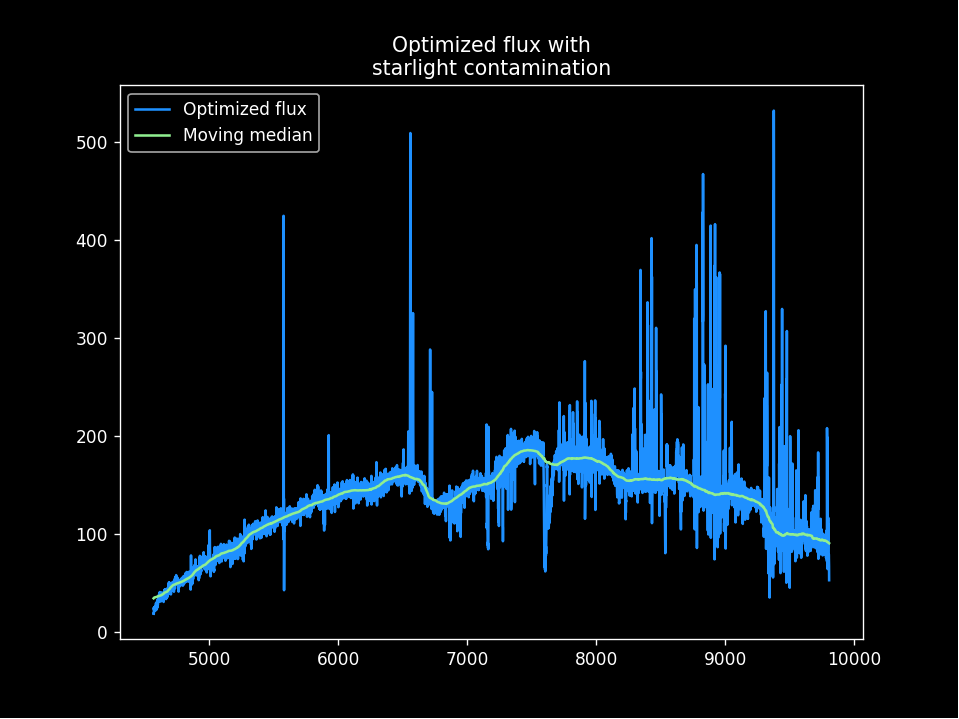

Text(0.5, 1.0, 'Optimized flux with\nstarlight contamination')

In [26]:
plt.figure(1)
plt.tight_layout()

# plt.subplot(1,2,1)
plt.plot(rbwave, test_flux, color='dodgerblue', label='Optimized flux')
plt.plot(rbwave, moving_median_center, color='lightgreen', label='Moving median')
plt.legend()
plt.title('Optimized flux with\nstarlight contamination')

# plt.figure()
# plt.subplot(1,2,2)
# plt.plot(rbwave, test_flux-moving_median_center,label='Optimized flux - Moving median')
# plt.legend()
# plt.title('Optimized flux\n (contamination removed)')

<IPython.core.display.Javascript object>


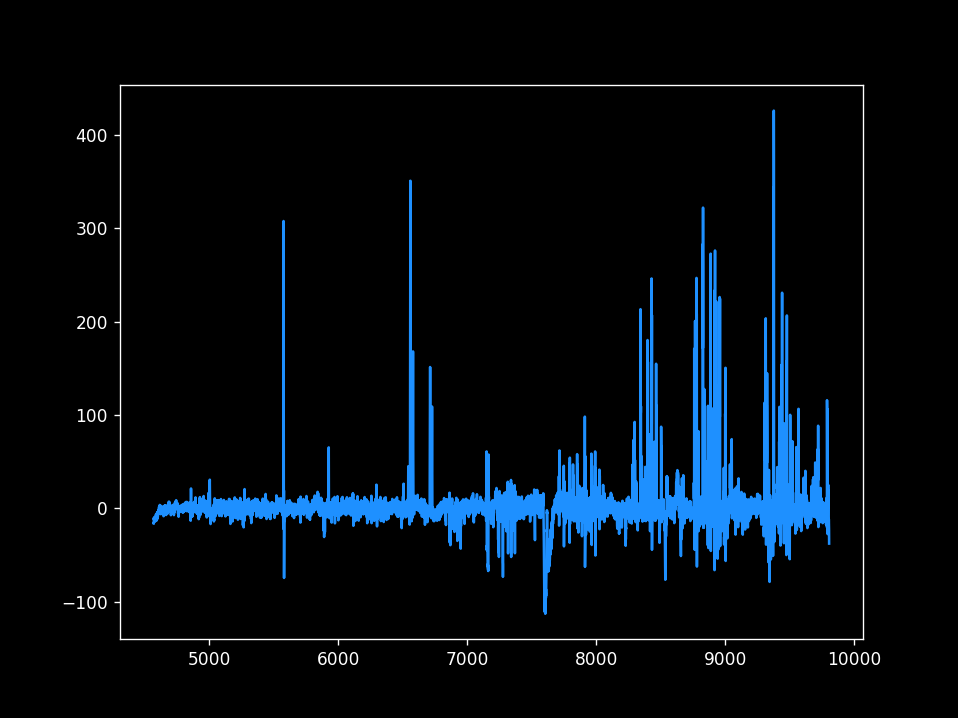

In [39]:
plt.figure(2)
plt.tight_layout()

# plt.subplot(1,2,1)
plt.plot(rbwave, test_flux-moving_median_center, color='dodgerblue', label='Optimized flux - Moving median')

In [27]:
def moving_rms_old(a, window=50, reverse=False):
    
    '''
    Returns the moving RMS values up to the halfway point of the array
    
    Parameters
    ----------
    a : ndarray
        One dimensional flux array.
    window : int, optional
        The size of each segment for taking the RMS.
    reverse : bool, optional
        Can be used to switch between left-to-right
        and right-to-left directions for the moving RMS.
        Default is left-to-right.
        
    Returns
    ----------
    rms_arr : One dimensional array of moving RMS.
    '''
    
    rms_arr = []
    b = np.where(np.isfinite(a))[0]
    mid_index = int((b[-1]+b[0])/2)
    
    if reverse==False:
        p,q,r = 0,mid_index,1
    else:
        p,q,r = -1,-(len(a)-mid_index-1),-1
    
    for i in range(p,q,r):
        if (reverse==False):
            x = a[i:i+window]
        else:
            x = a[i:i-window:-1]
            
        rms = np.sqrt(np.mean(x**2))
        
        if (reverse==False):
            rms_arr.append(rms)
        else:
            rms_arr.insert(0,rms)

    return np.array(rms_arr)       

In [28]:
def moving_rms_new(a, window=50, reverse=False, center_align=False):
    
    '''
    Returns the moving RMS values up to the halfway point of the array
    
    Version - 2.0
    
    Parameters
    ----------
    a : ndarray
        One dimensional flux array.
    window : int, optional
        The size of each segment for taking the RMS.
    reverse : bool, optional
        Can be used to switch between left-to-right
        and right-to-left directions for the moving RMS.
        Default is left-to-right.
        
    Returns
    ----------
    rms_arr : One dimensional array of moving RMS.
    '''    

    rms_arr = []
    b = np.where(np.isfinite(a))[0]
    mid_index = int((b[-1]+b[0])/2)
    
    if (center_align==True):
        p,q,r = b[0],b[-1]+1,1
        j,k,l = -window//2,window//2+1,1
    else:
        if reverse==False:
            p,q,r = 0,mid_index,1
            j,k,l = 0,window,1
        else:
            p,q,r = mid_index+2,len(a),1
            j,k,l = 0,-window,-1
    
    for i in range(p,q,r):
        x = a[i+j:i+k:l]
        rms = np.sqrt(np.mean(x**2))
        rms_arr.append(rms)
    
    if (center_align==True):
        rms_arr = [np.nan]*b[0] + rms_arr + [np.nan]*(len(a)-b[-1]-1)
    
    return np.array(rms_arr)       

In [48]:
test_flux = excluded_fluxes_dict[slit_nums_exclude[9]]
moving_rms_center = moving_rms_new(test_flux, window=125, center_align=True)

In [49]:
x = moving_rms_old(test_flux, window=50, reverse=True)
y = moving_rms_new(test_flux, window=50, reverse=True, center_align=False)
np.allclose(x, y, rtol=0, atol=0, equal_nan=True)

True

<IPython.core.display.Javascript object>


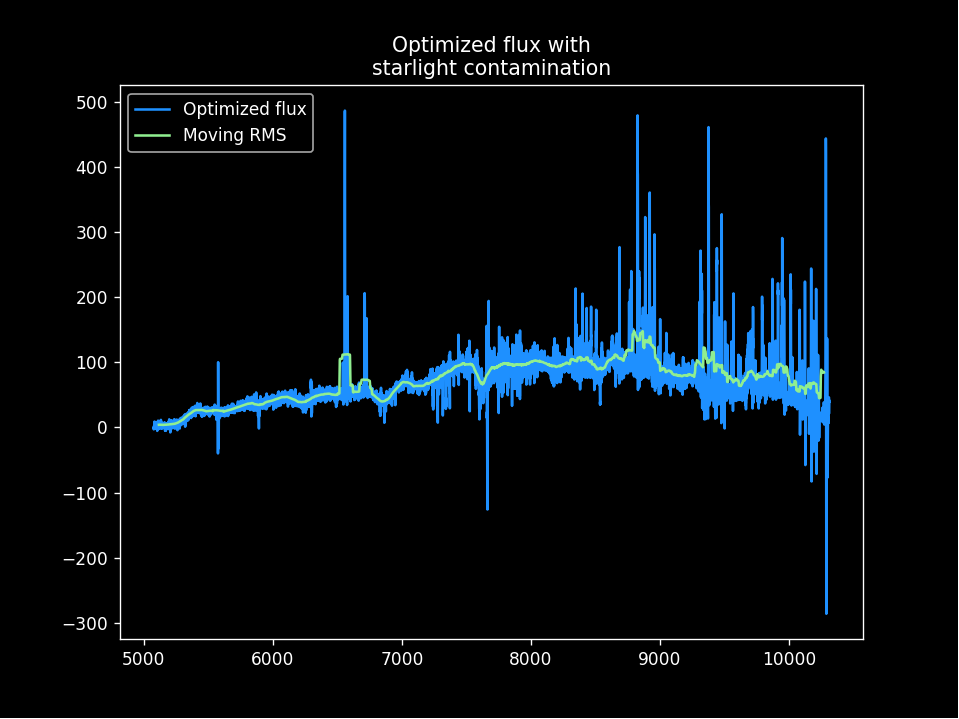

Text(0.5, 1.0, 'Optimized flux with\nstarlight contamination')

In [50]:
plt.figure(2)
plt.tight_layout()

# plt.subplot(1,2,1)
plt.plot(rbwave, test_flux, color='dodgerblue', label='Optimized flux')
plt.plot(rbwave, moving_rms_center, color='lightgreen', label='Moving RMS')
plt.legend()
plt.title('Optimized flux with\nstarlight contamination')

# plt.figure()
# plt.subplot(1,2,2)
# plt.plot(rbwave, test_flux-moving_median_center,label='Optimized flux - Moving median')
# plt.legend()
# plt.title('Optimized flux\n (contamination removed)')

In [29]:
moving_median_center_airglow = moving_median_new(fits_median, window=325, center_align=True)
# airglow_median_but_better = contamination_in_airglow(fits_median, window=325, segments=200, error=0.1)

In [38]:
finite_indices_airglow = np.where(np.isfinite(airglow_median_but_better))
i = finite_indices_airglow[0][0]
# print(i)
# print(finite_indices_airglow)
# j = i + 325
j = finite_indices_airglow[0][-1]
poly_const_second_deg = np.polyfit(rbwave[i:j],moving_median_center_airglow[i:j],2)
median_poly = poly_const_second_deg[0]*(rbwave**2) + poly_const_second_deg[1]*rbwave + poly_const_second_deg[2]

<IPython.core.display.Javascript object>


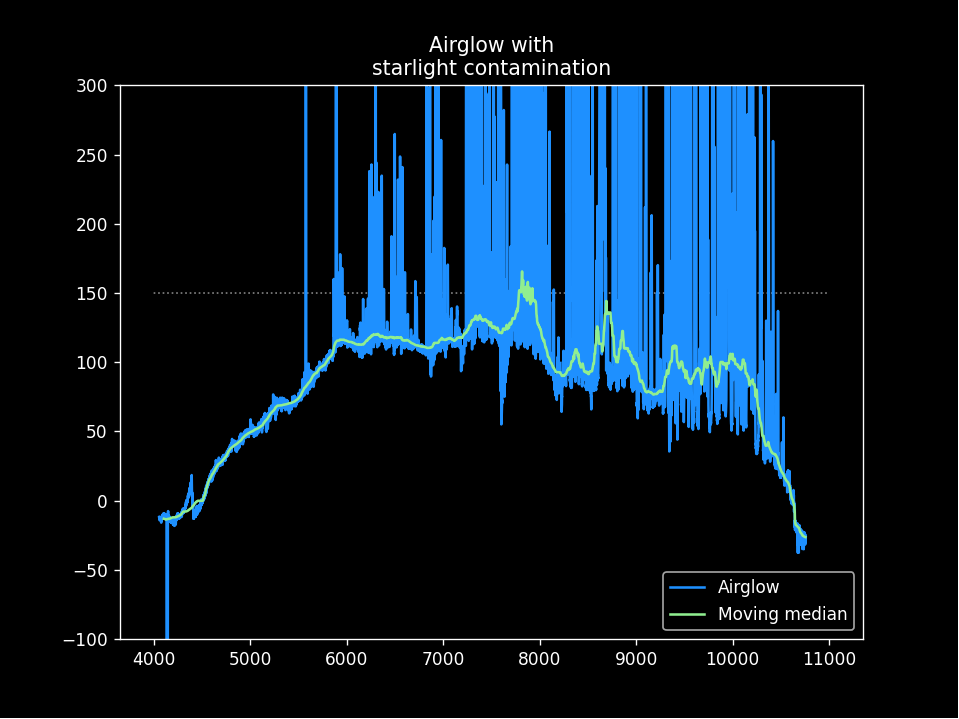

Text(0.5, 1.0, 'Airglow with\nstarlight contamination')

In [43]:
plt.figure(3)
plt.tight_layout()

# plt.subplot(1,2,18
plt.plot(rbwave, 150*np.ones(len(rbwave)), linestyle=':', linewidth=1.0, color='gray')
plt.plot(rbwave, fits_median, color='dodgerblue',  label='Airglow')
plt.plot(rbwave, moving_median_center_airglow, color='lightgreen', label='Moving median')
# plt.plot(rbwave, airglow_median_but_better, color='red', label='Moving median, improved(???)', linestyle='-')
# plt.plot(rbwave, median_poly, color='gold', label='Polynomial')

plt.ylim(-100,300)
plt.legend()
plt.title('Airglow with\nstarlight contamination')

# plt.figure()
# plt.subplot(1,2,2)
# plt.plot(rbwave, test_flux-moving_median_center,label='Optimized flux - Moving median')
# plt.legend()
# plt.title('Optimized flux\n (contamination removed)')

<IPython.core.display.Javascript object>


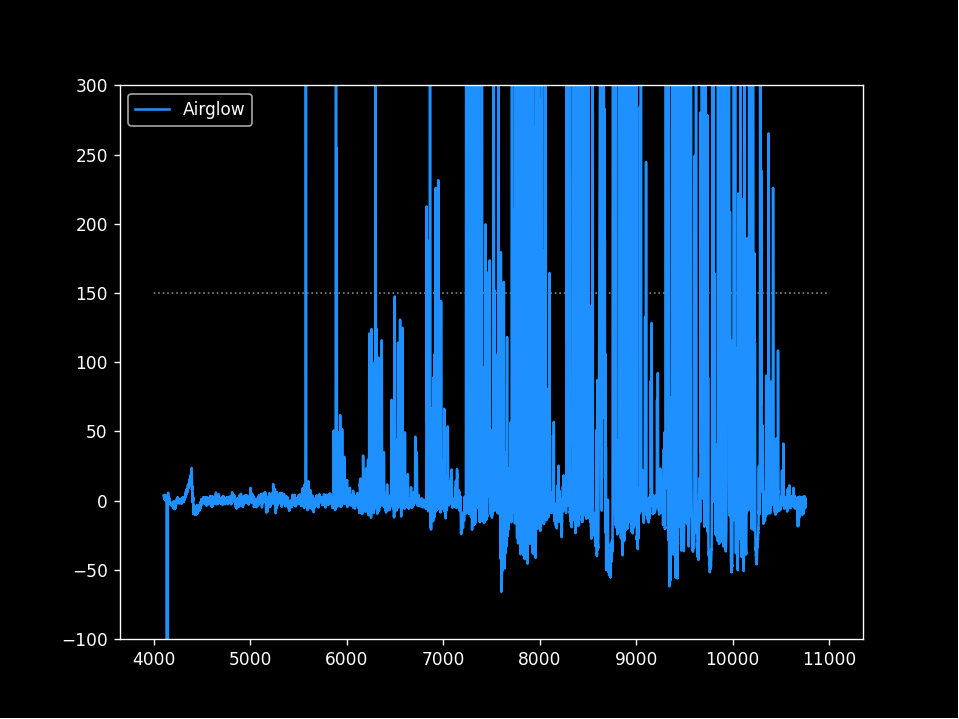

In [44]:
plt.figure(4)
plt.tight_layout()

# plt.subplot(1,2,18
plt.plot(rbwave, 150*np.ones(len(rbwave)), linestyle=':', linewidth=1.0, color='gray')
plt.plot(rbwave, fits_median - moving_median_center_airglow, color='dodgerblue',  label='Airglow')
# plt.plot(rbwave, , color='lightgreen', label='Moving median')
# plt.plot(rbwave, airglow_median_but_better, color='red', label='Moving median, improved(???)', linestyle='-')
# plt.plot(rbwave, median_poly, color='gold', label='Polynomial')

plt.ylim(-100,300)
plt.legend()

In [138]:
poly_const_second_deg = np.polyfit(rbwave,airglow_median_but_better,2)
median_poly = poly_const_second_deg[0]*(rbwave**2) + poly_const_second_deg[1]*rbwave + poly_const_second_deg[2]

LinAlgError: SVD did not converge in Linear Least Squares

In [15]:
%matplotlib inline

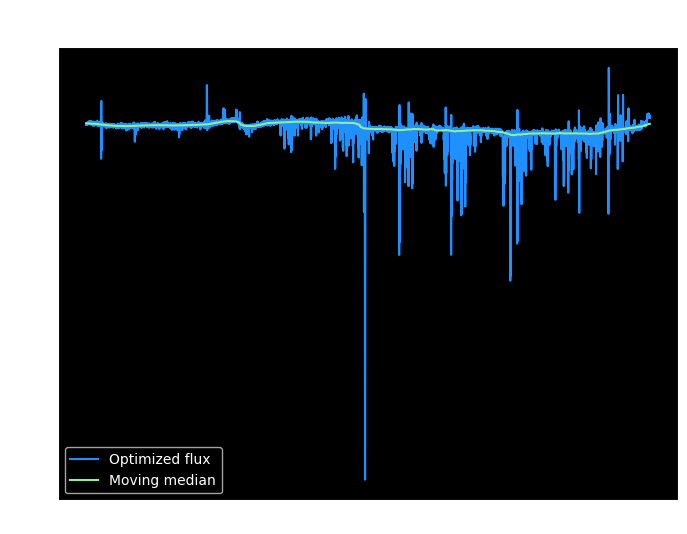

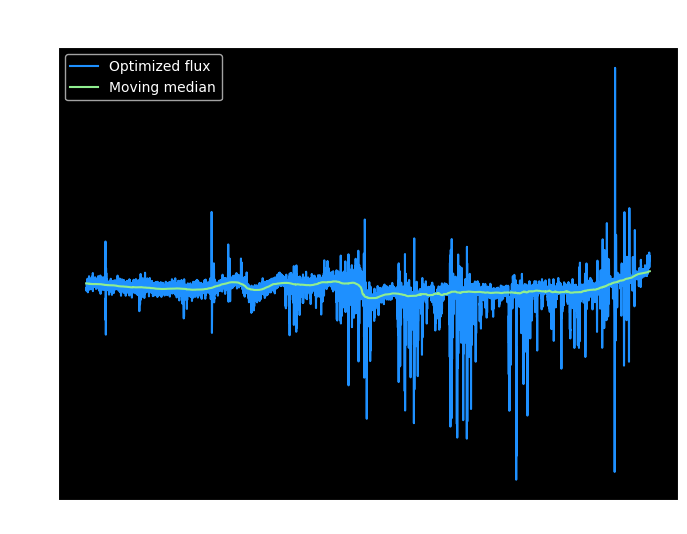

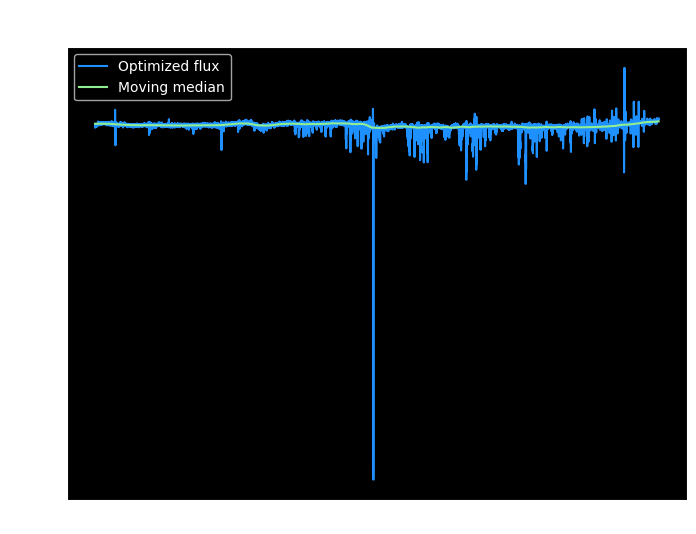

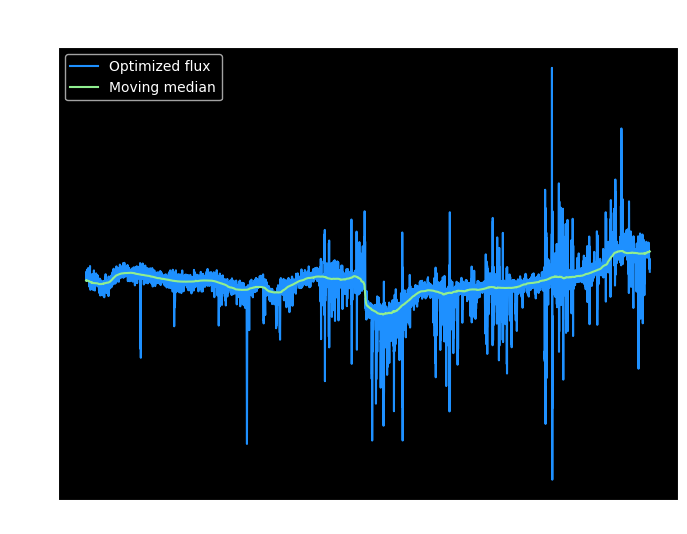

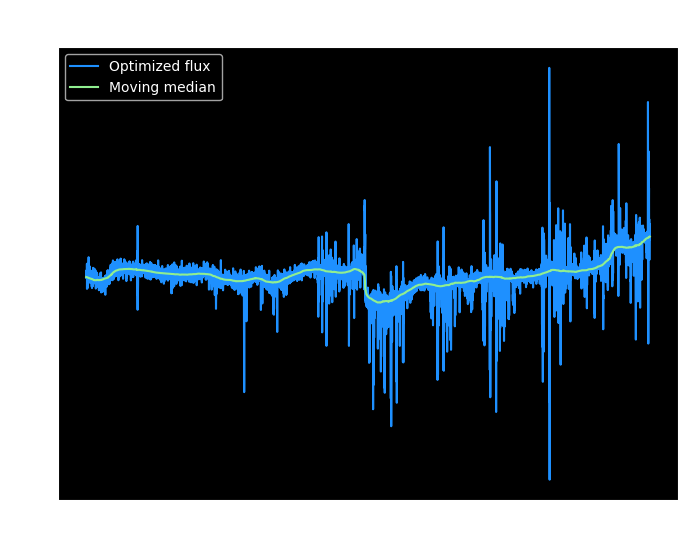

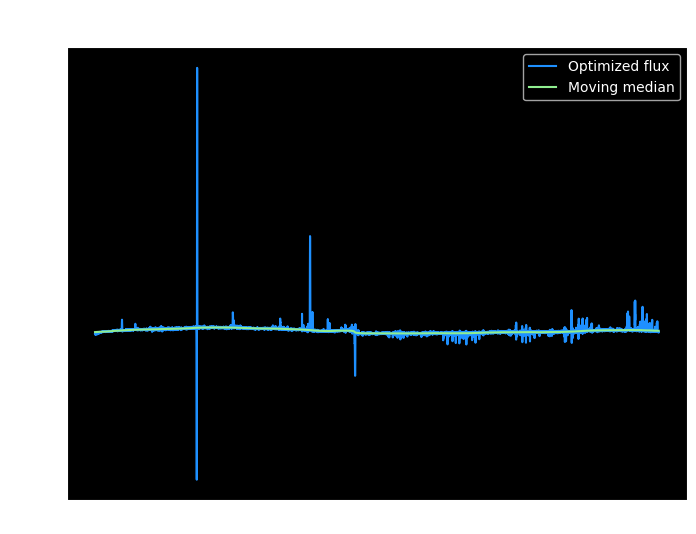

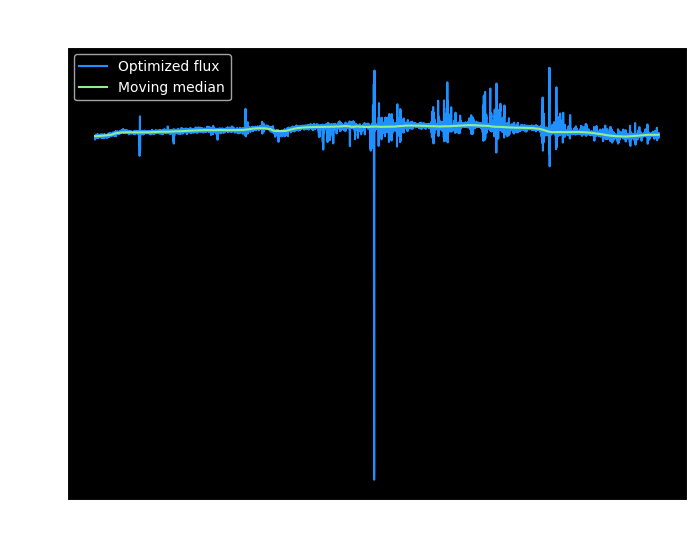

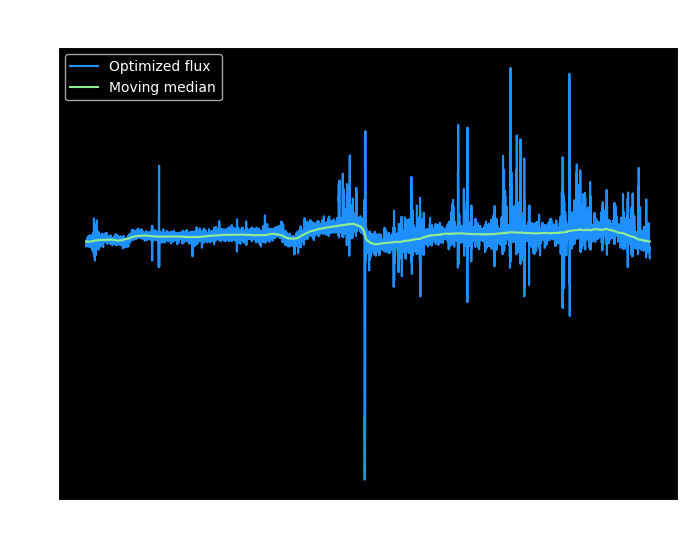

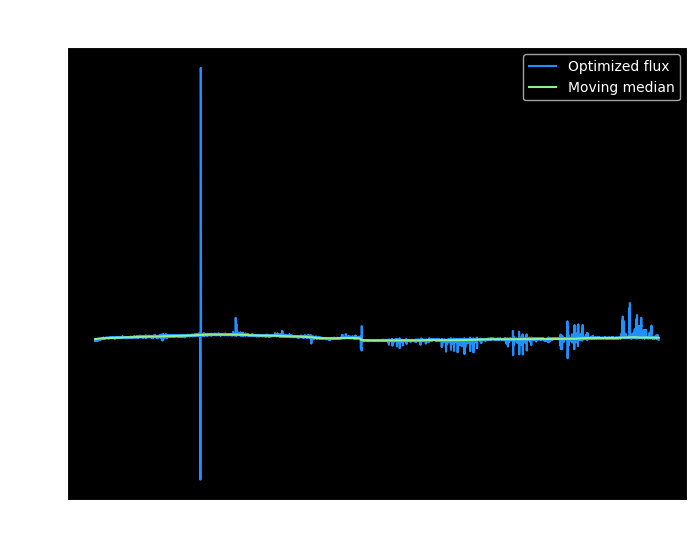

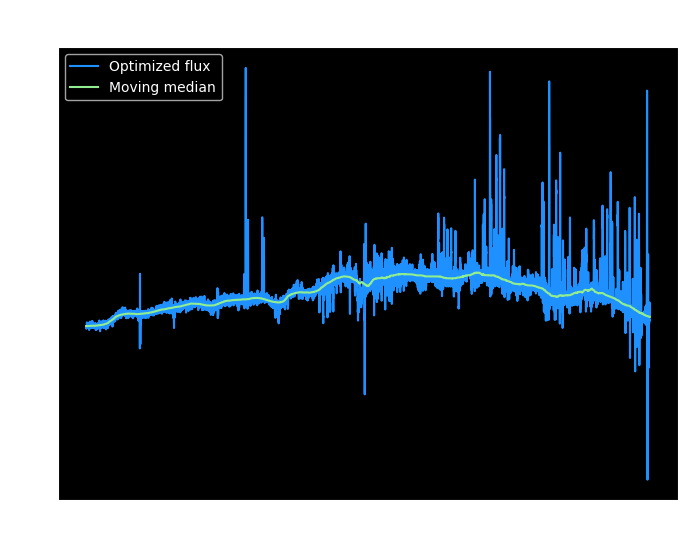

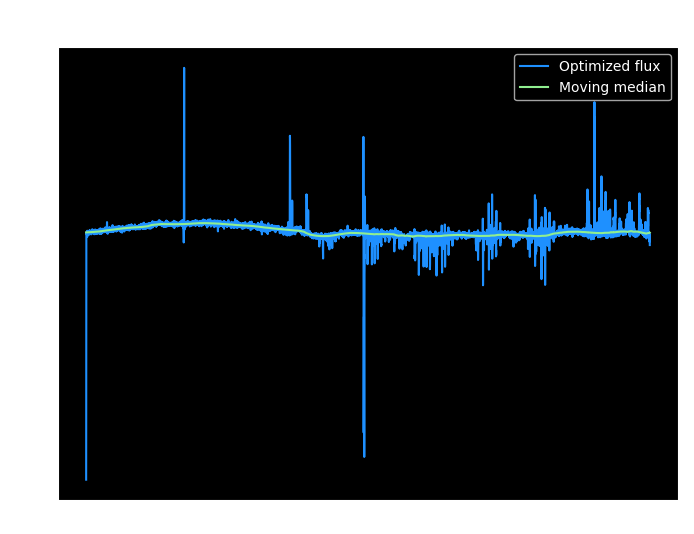

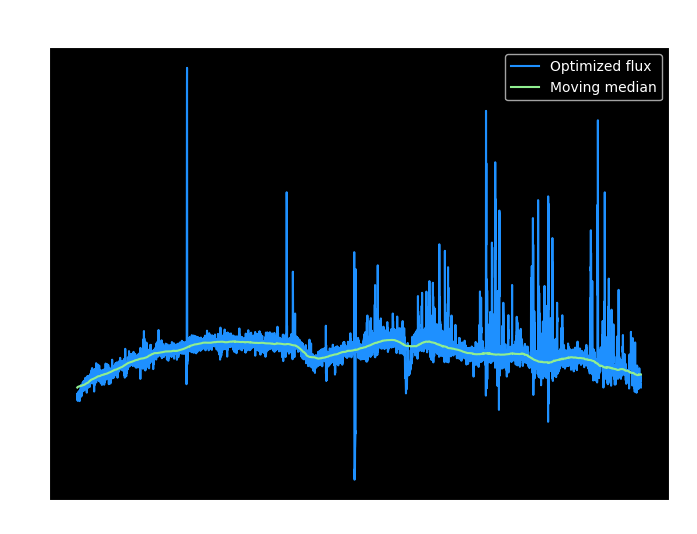

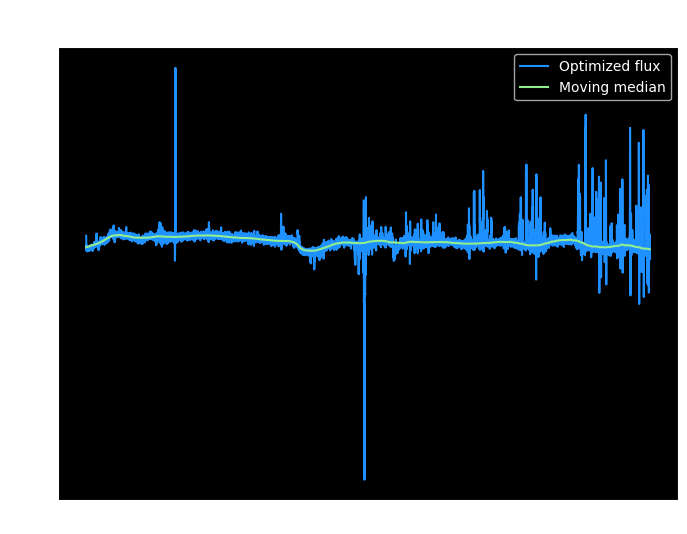

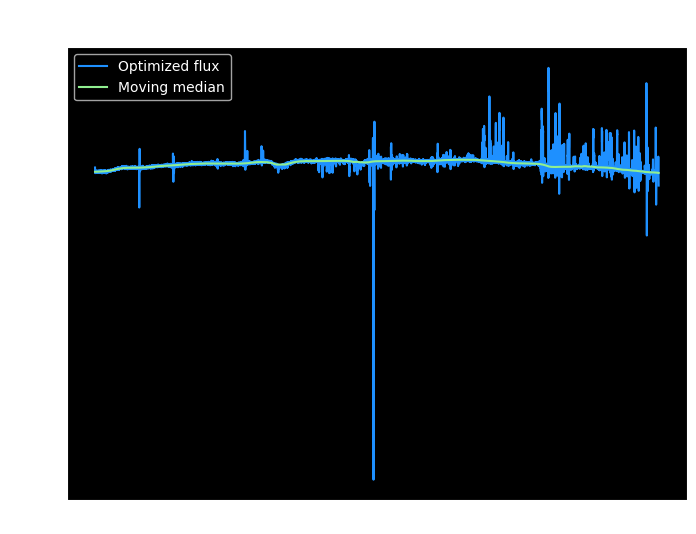

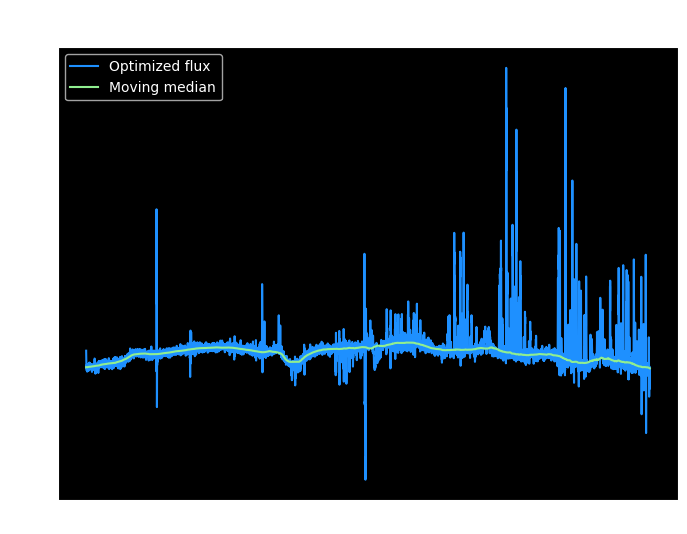

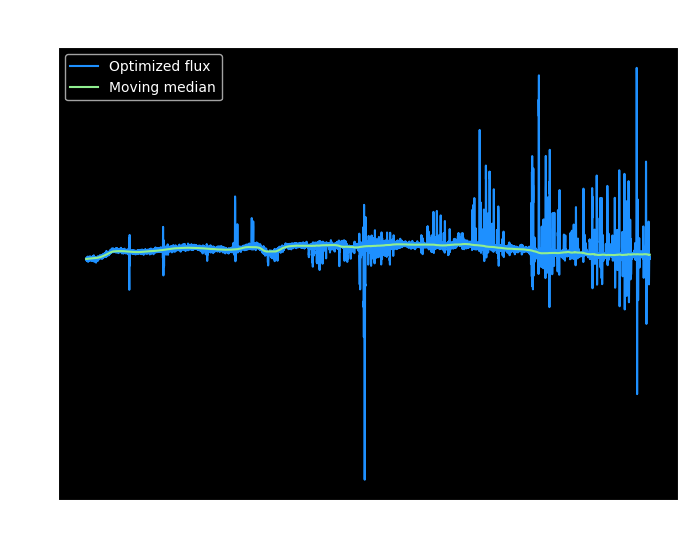

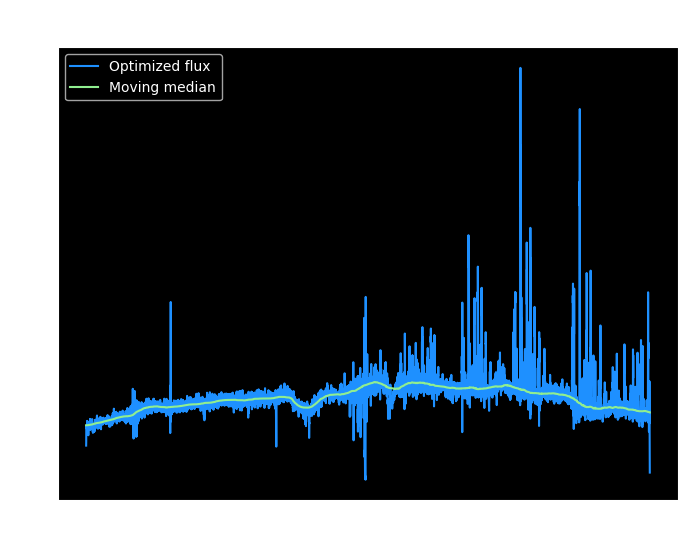

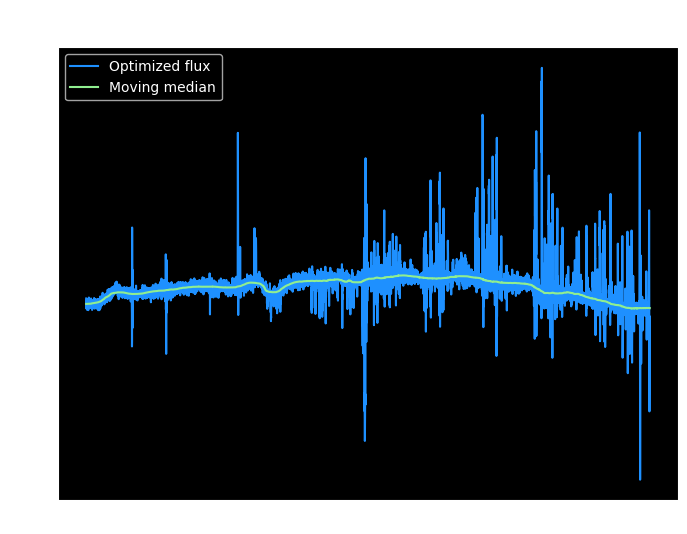

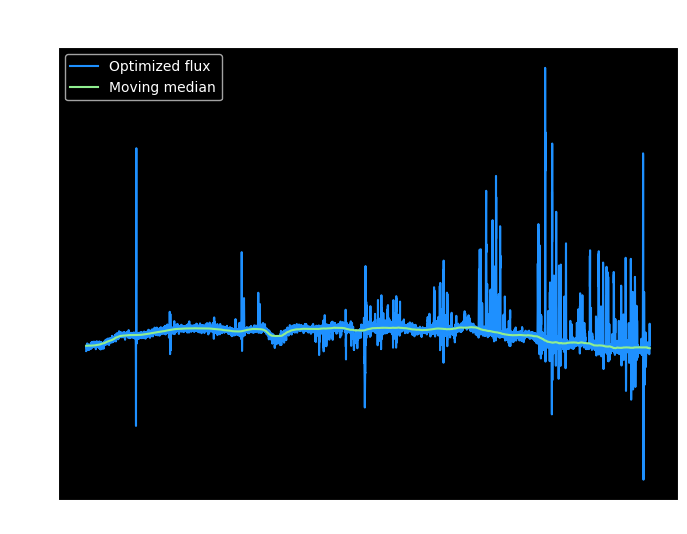

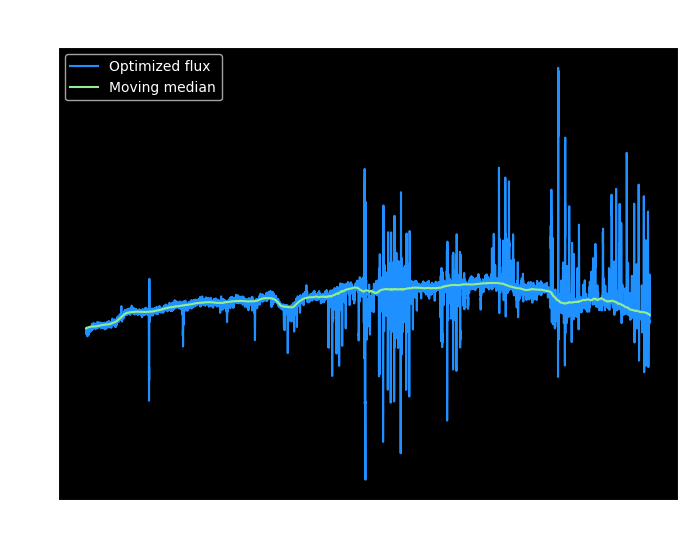

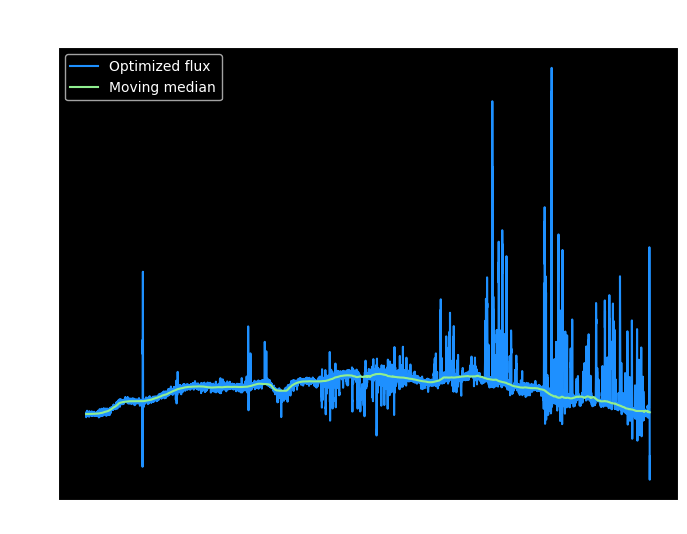

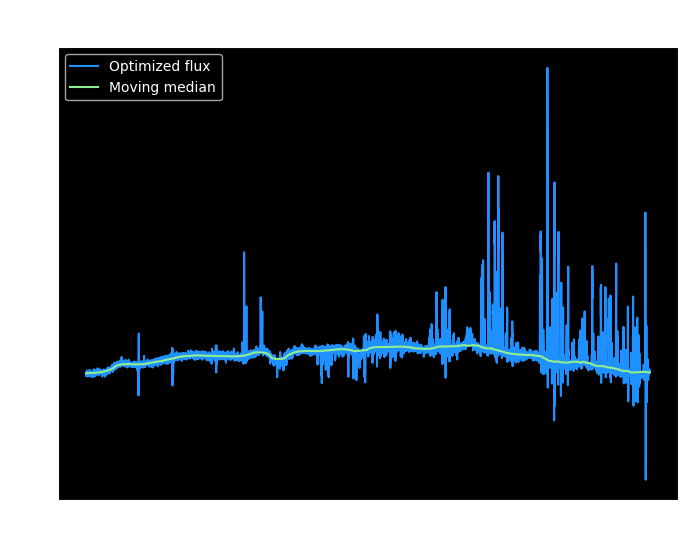

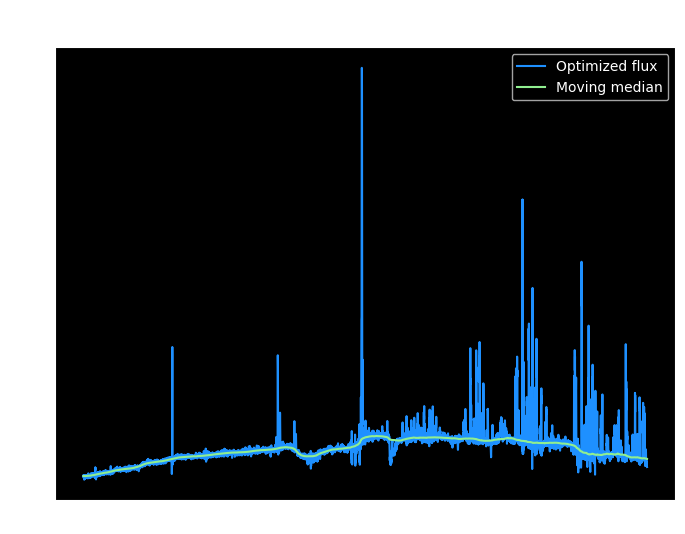

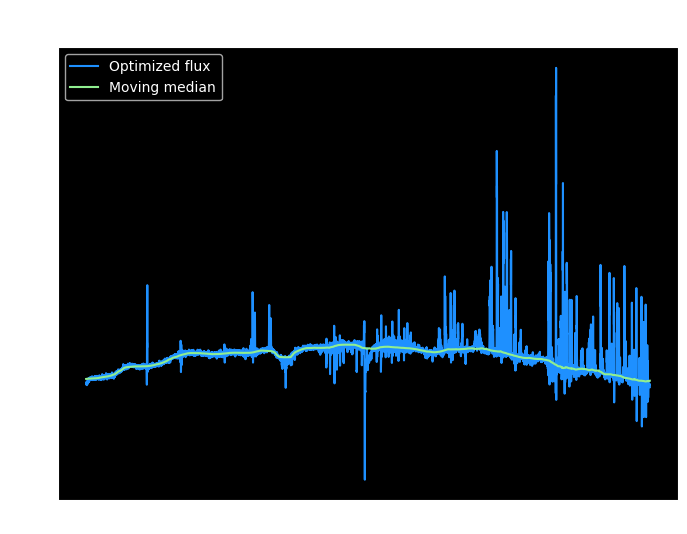

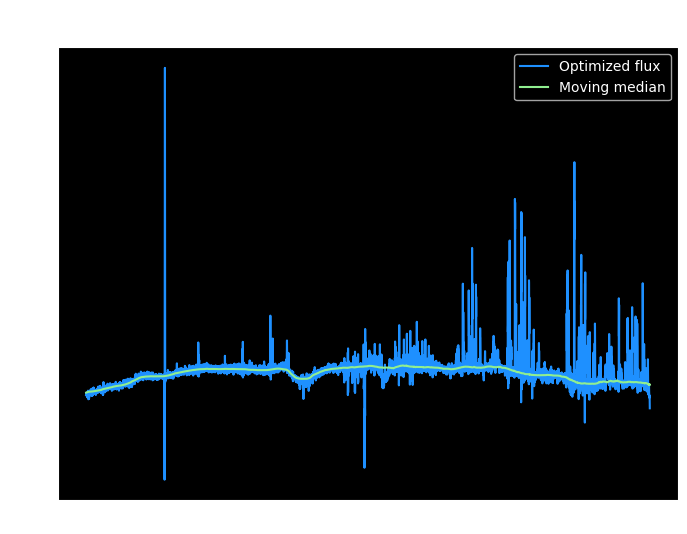

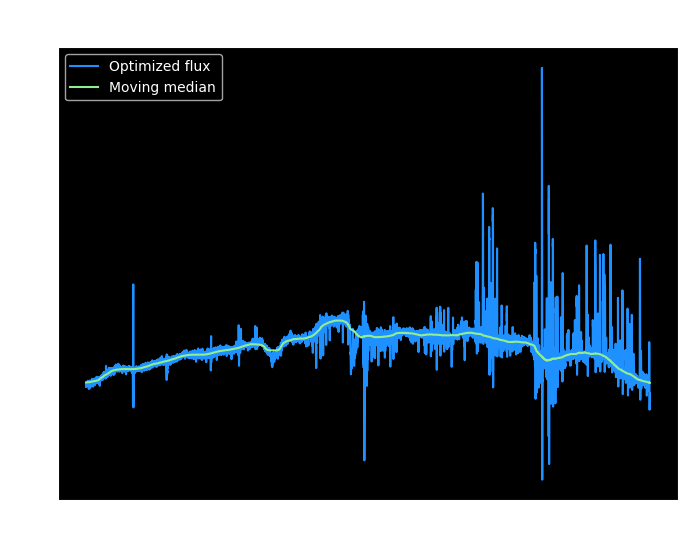

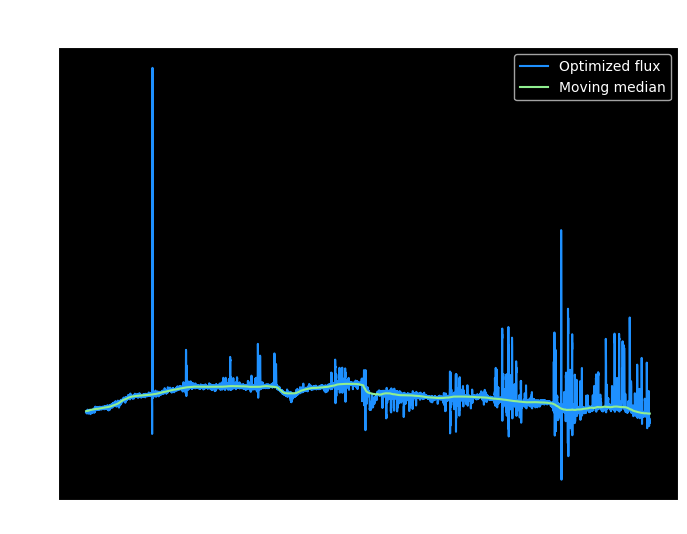

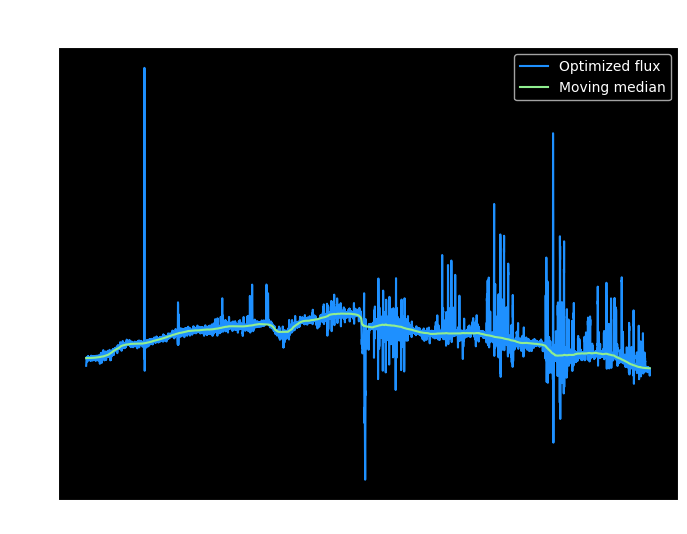

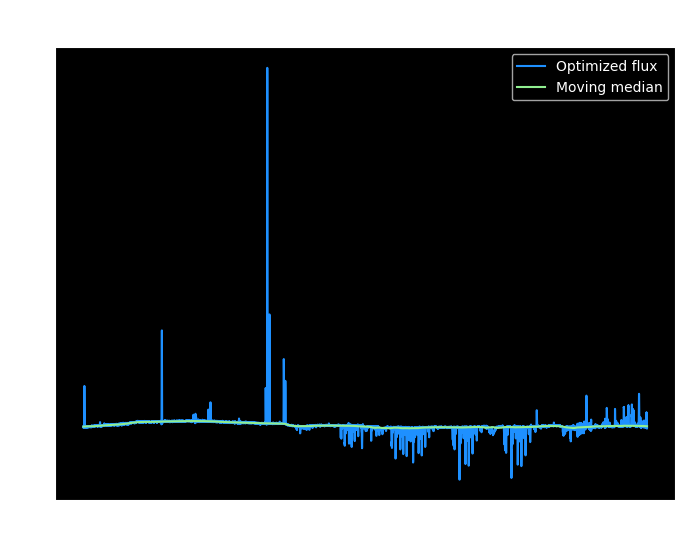

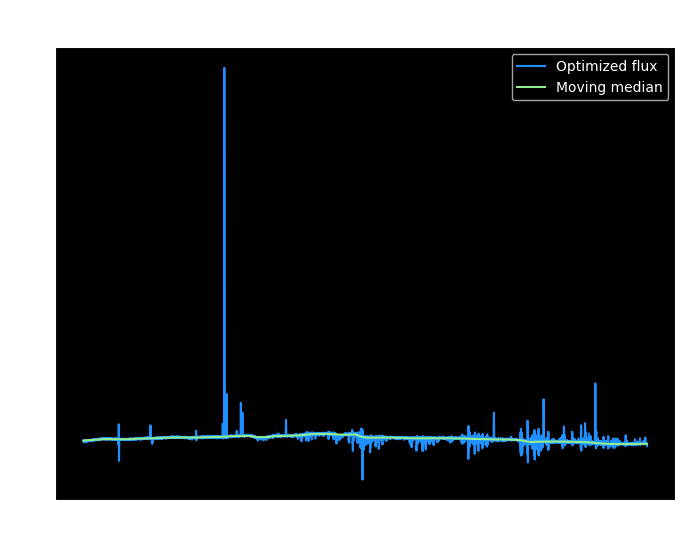

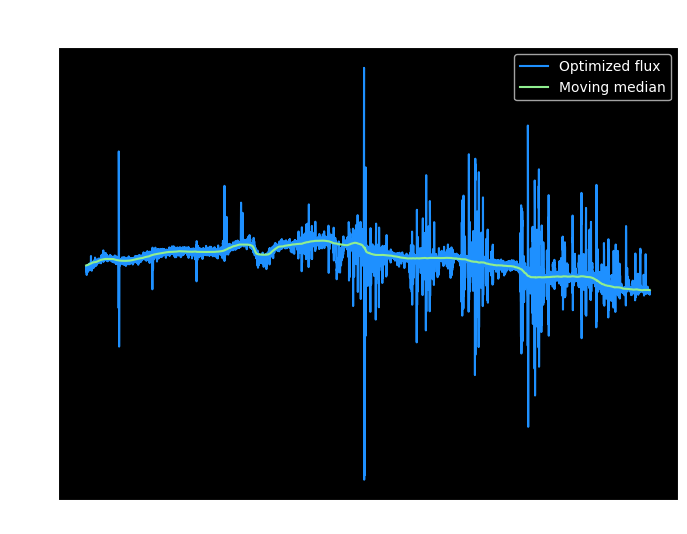

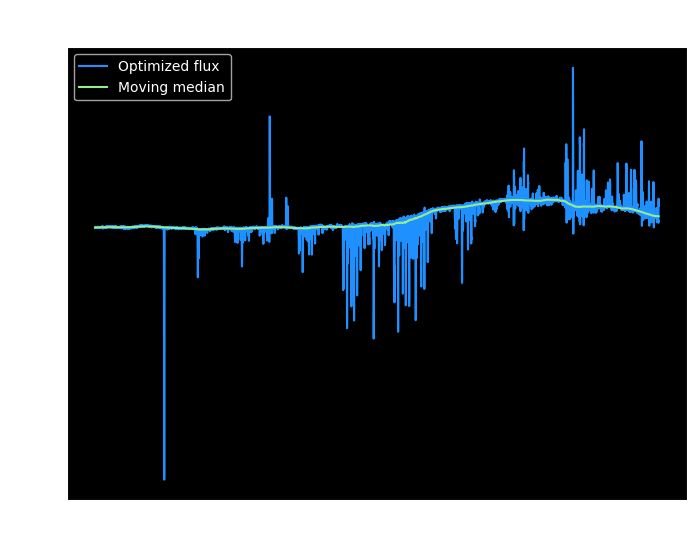

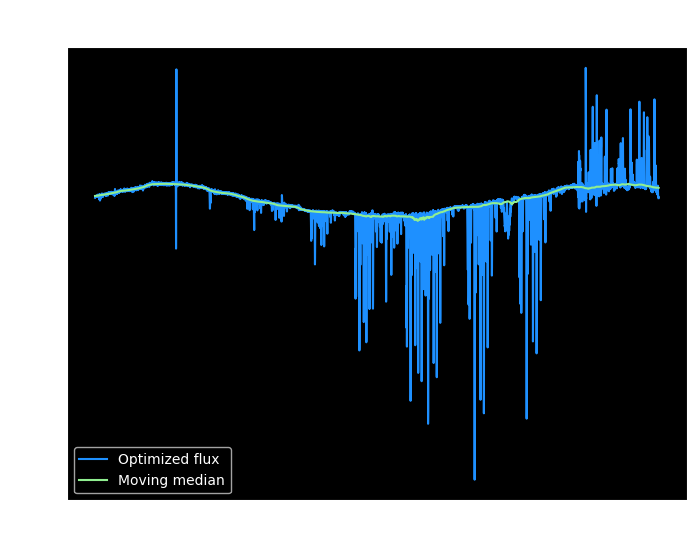

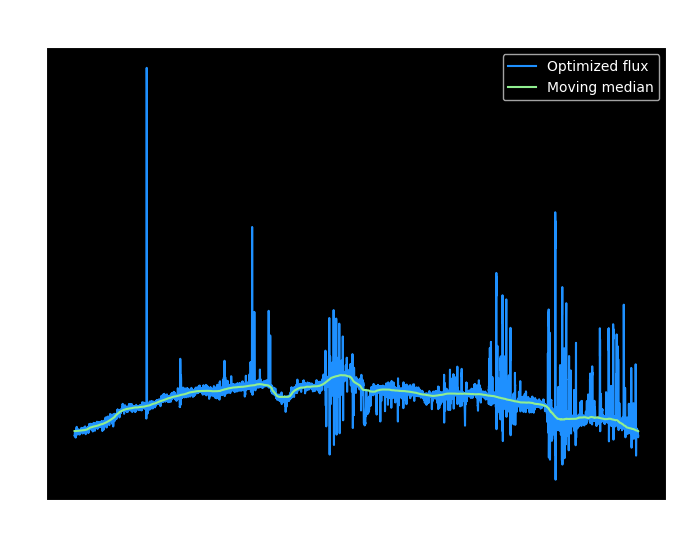

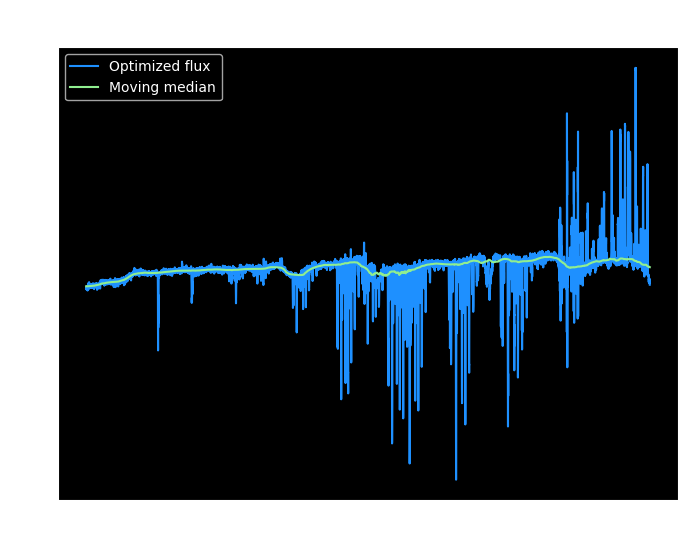

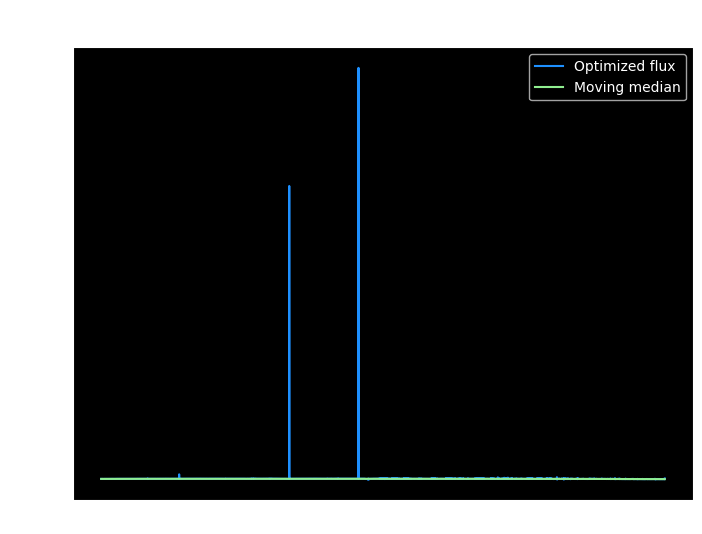

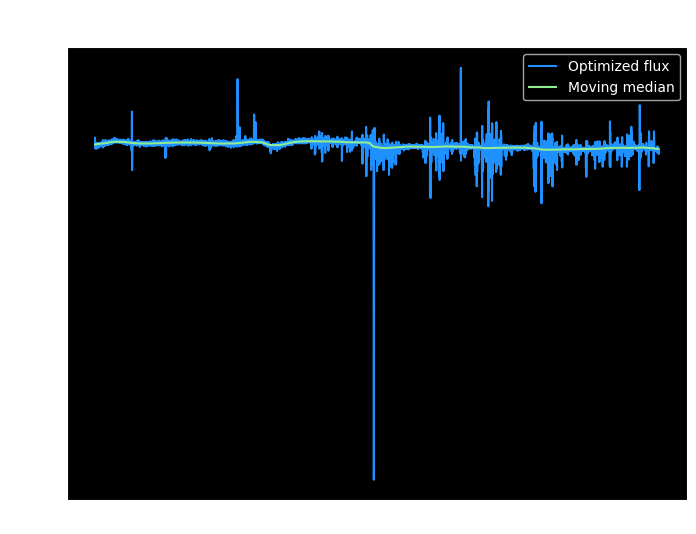

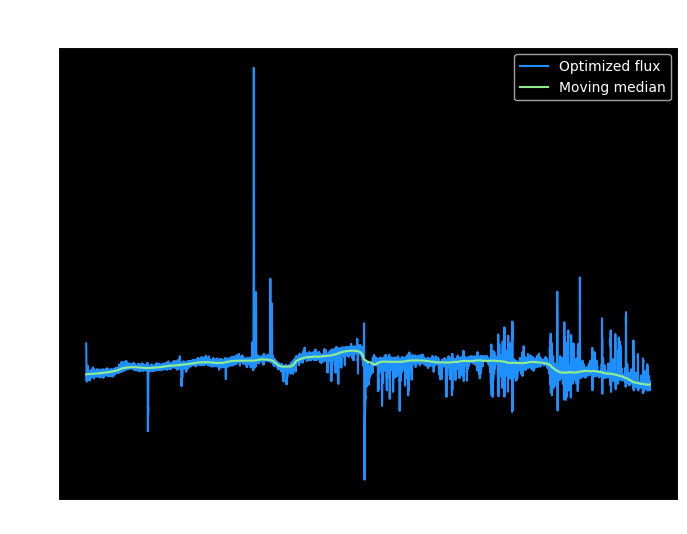

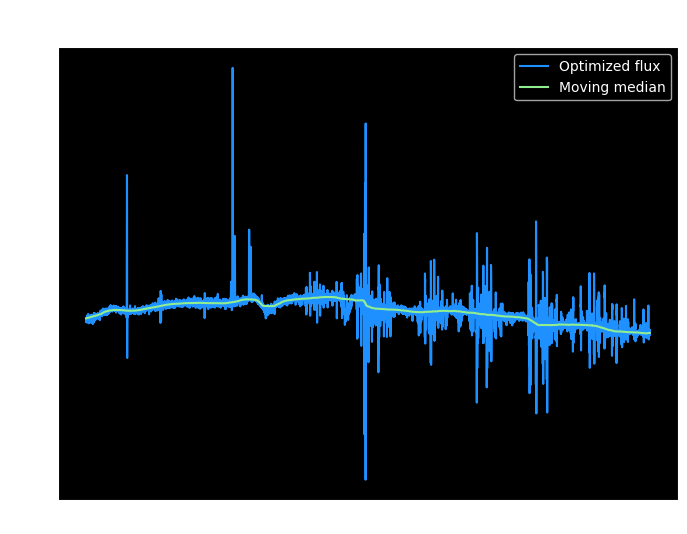

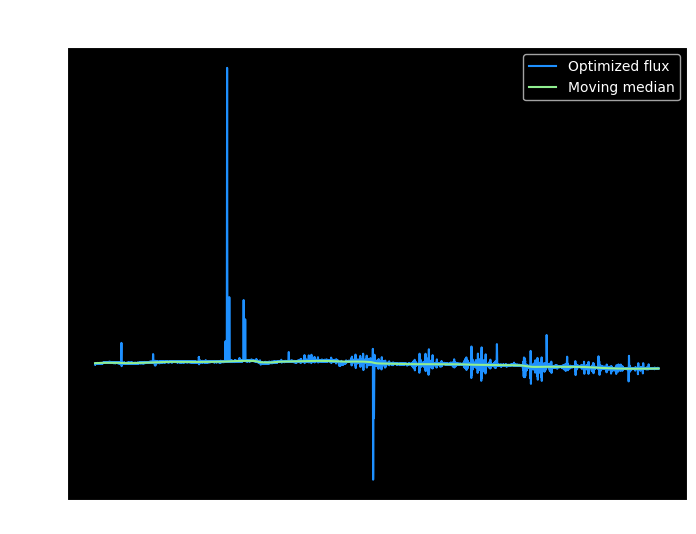

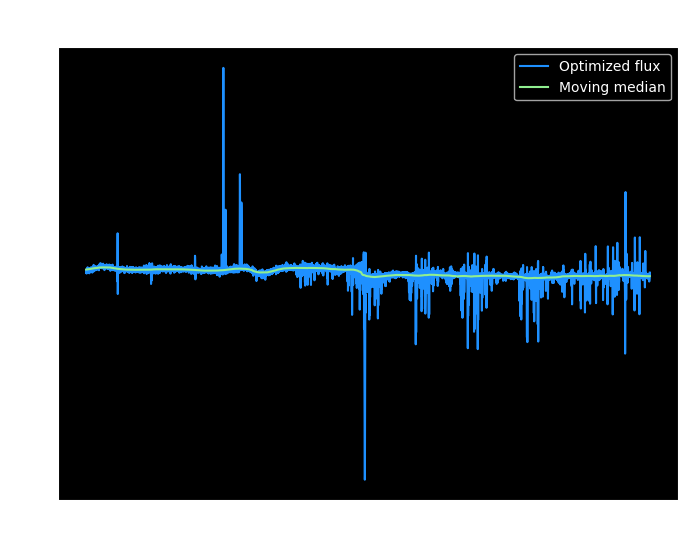

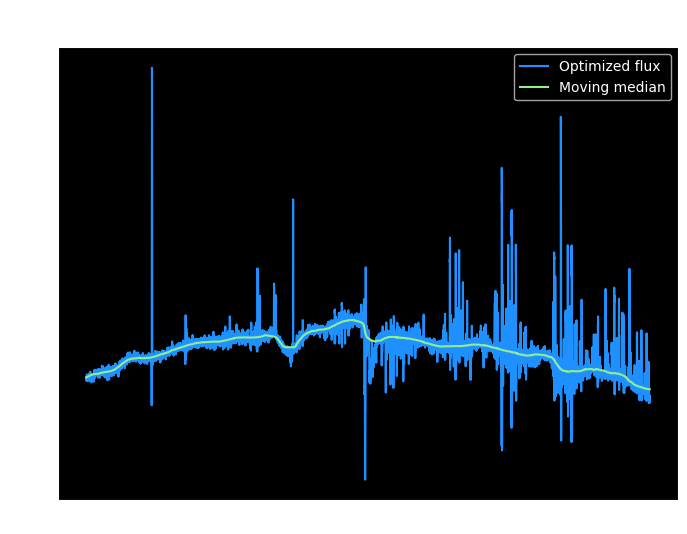

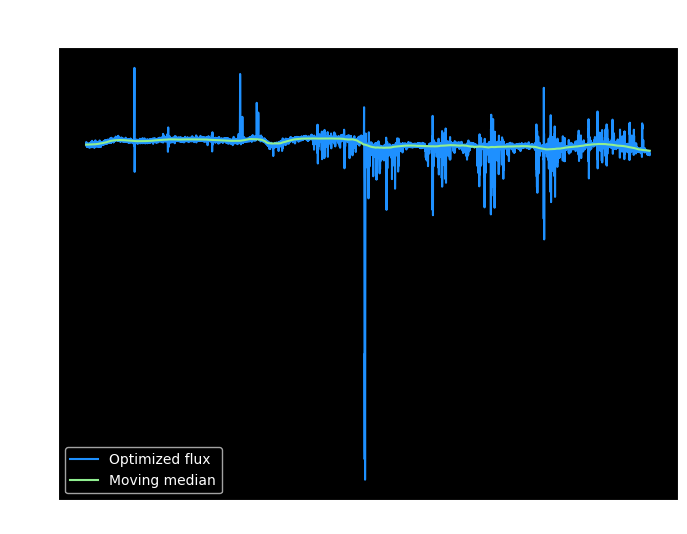

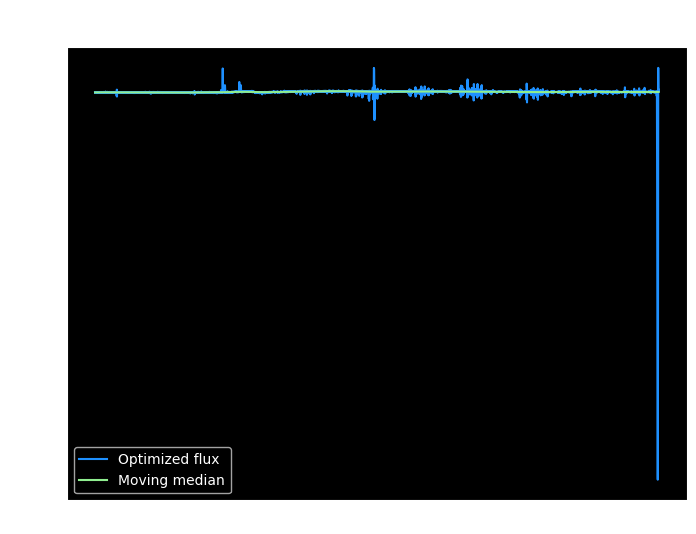

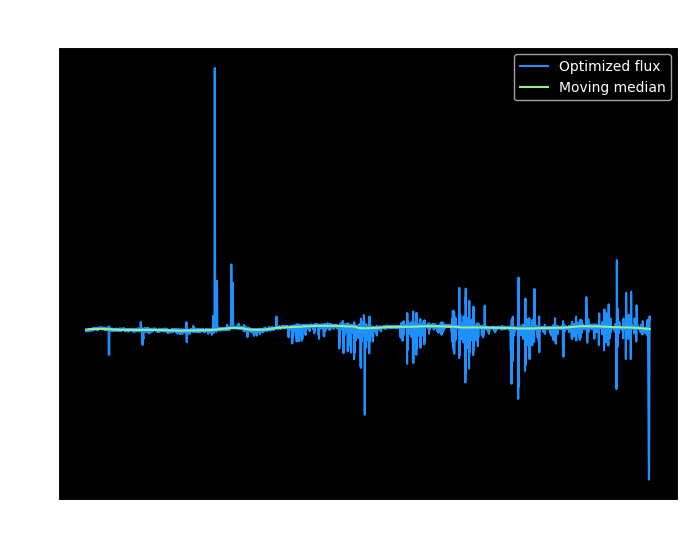

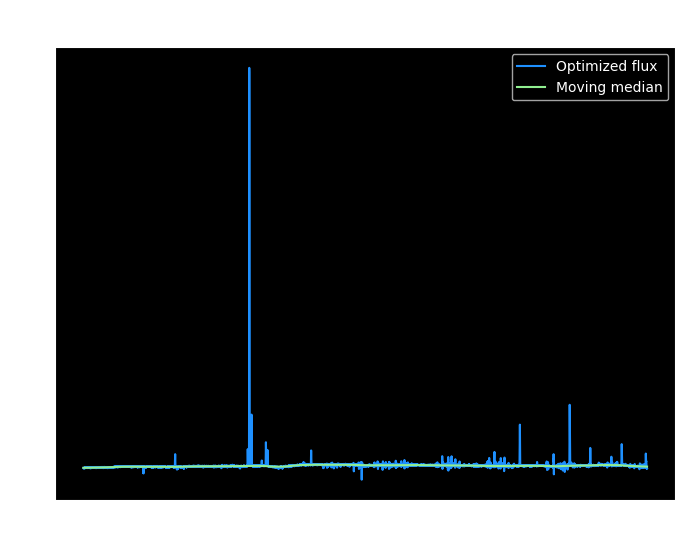

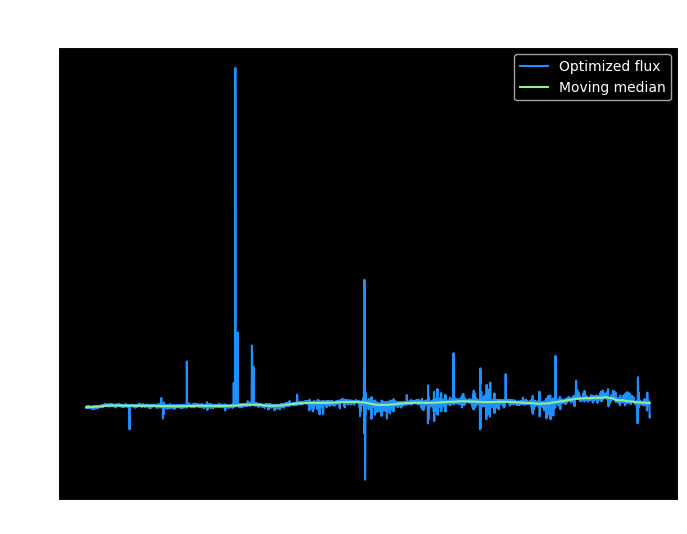

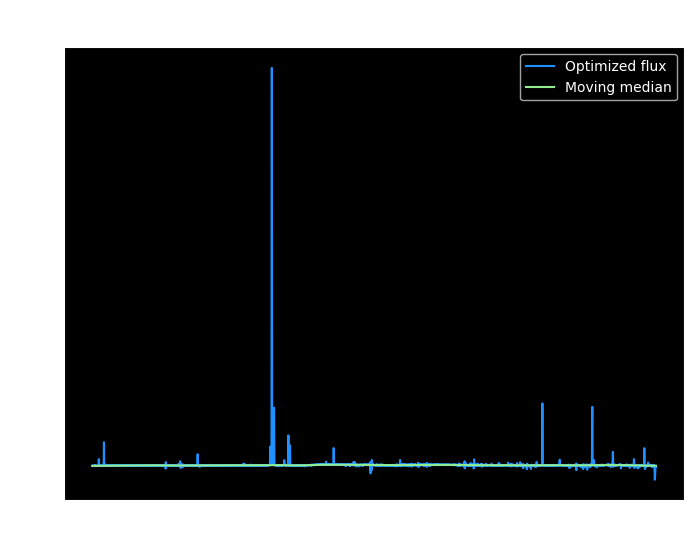

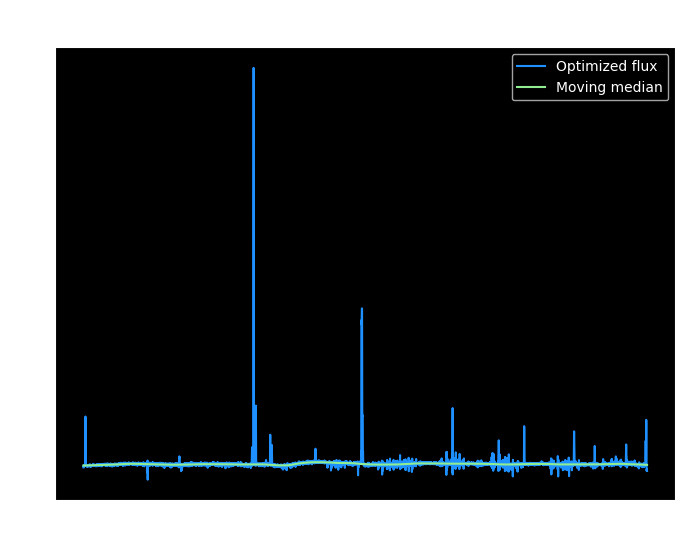

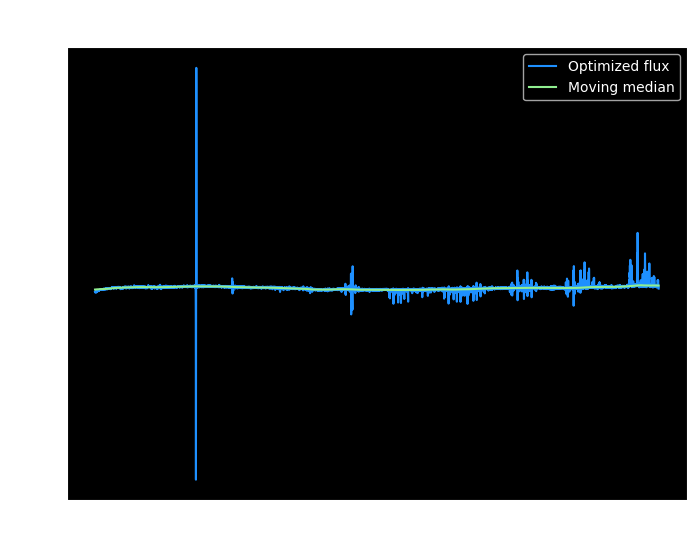

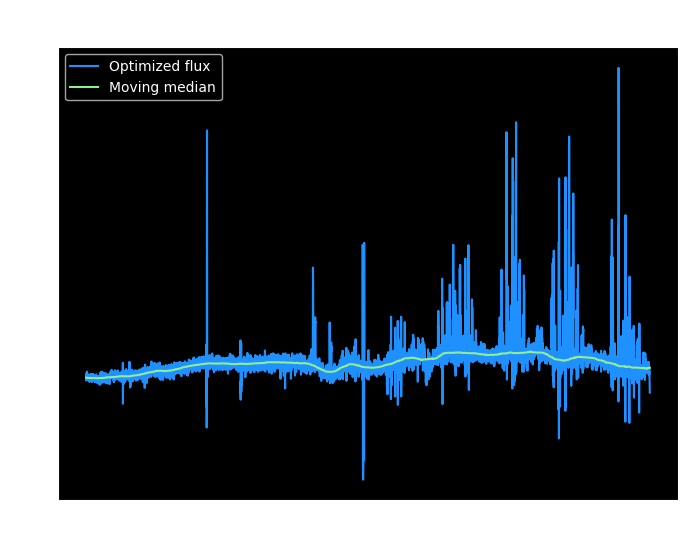

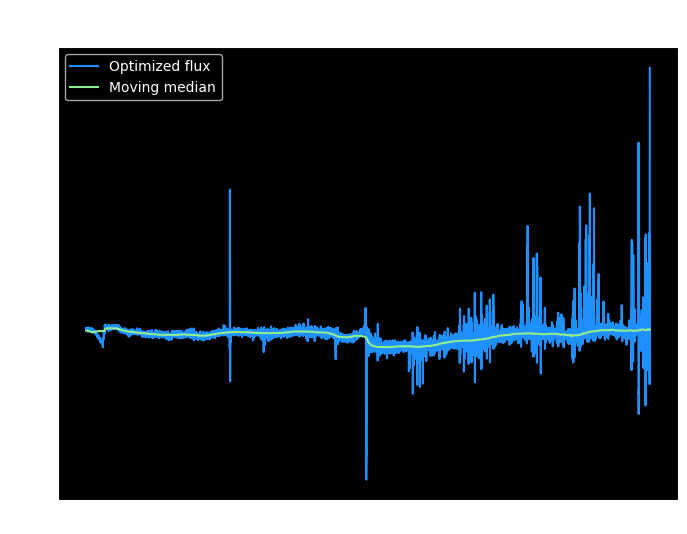

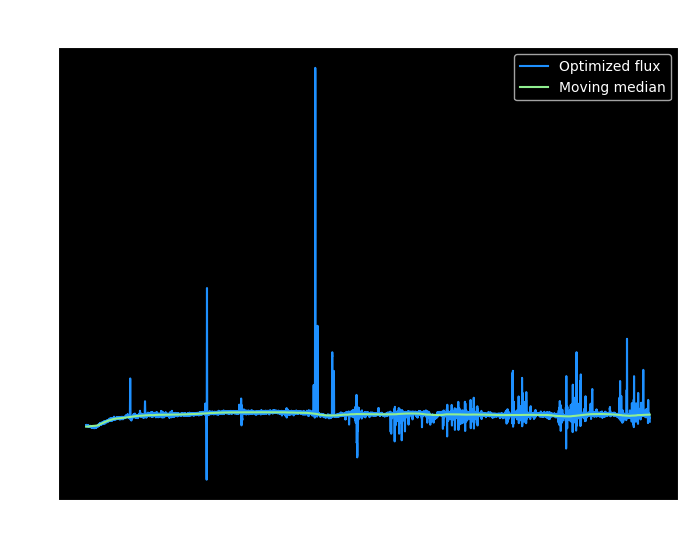

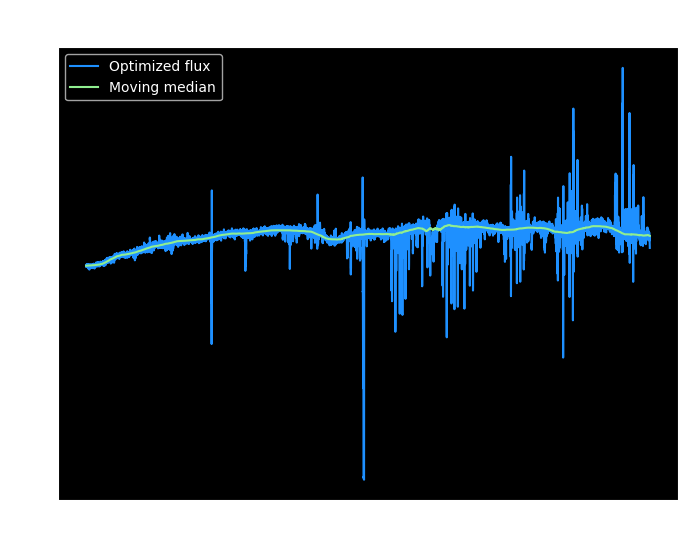

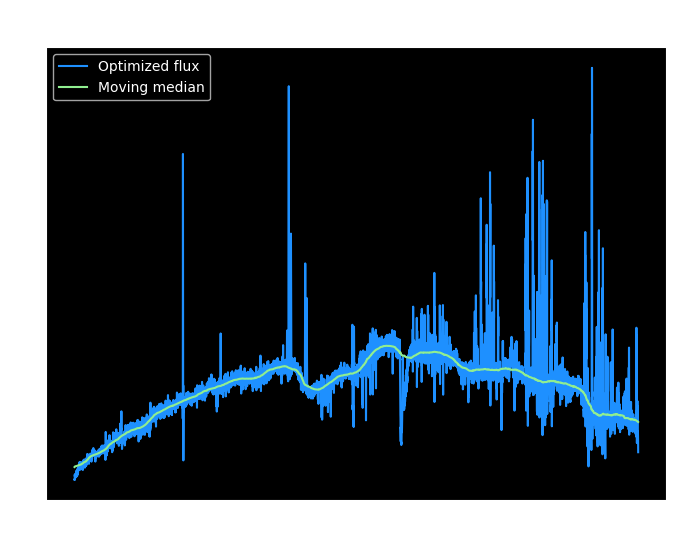

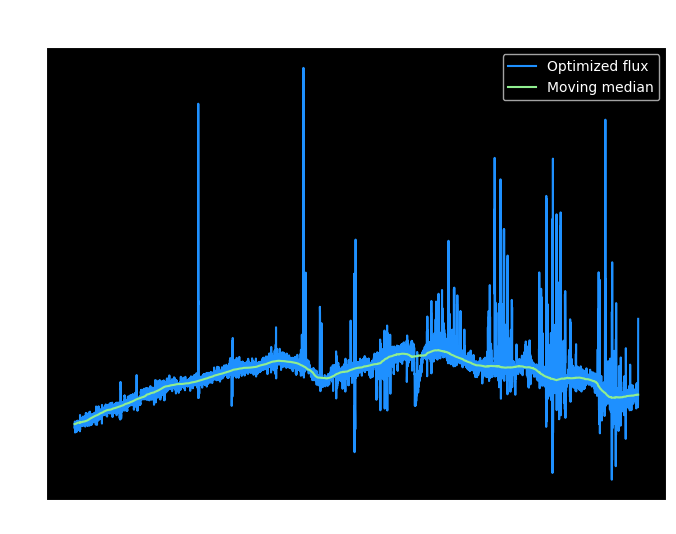

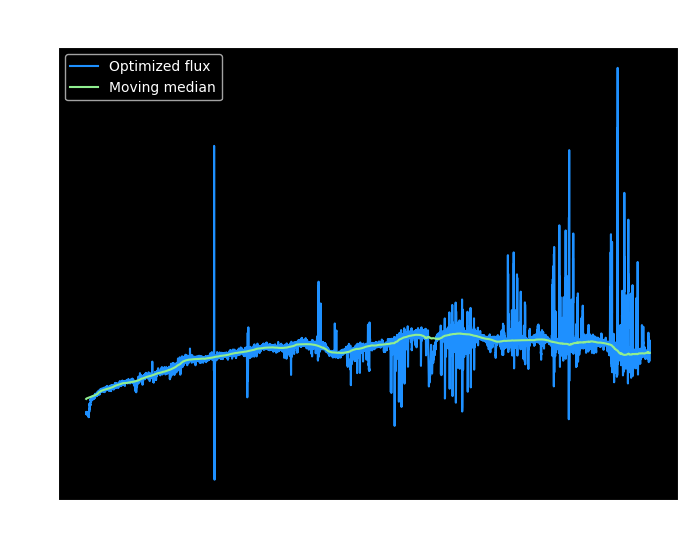

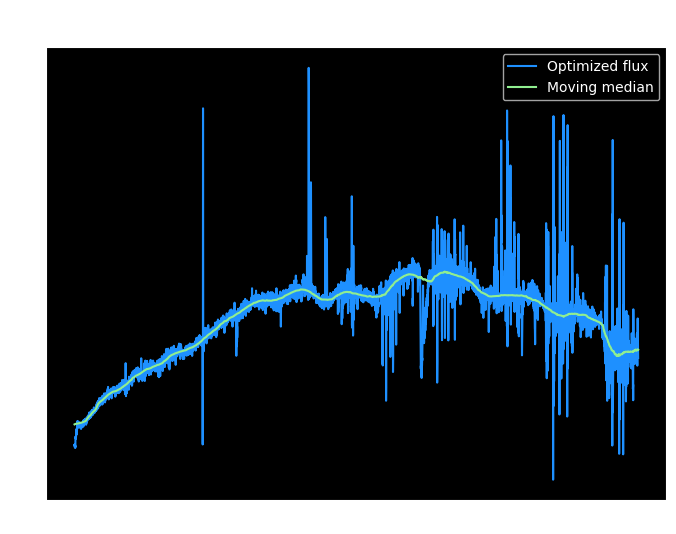

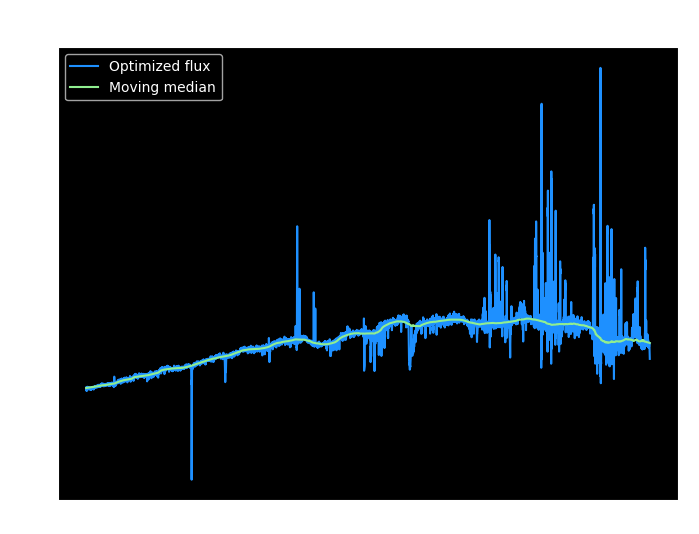

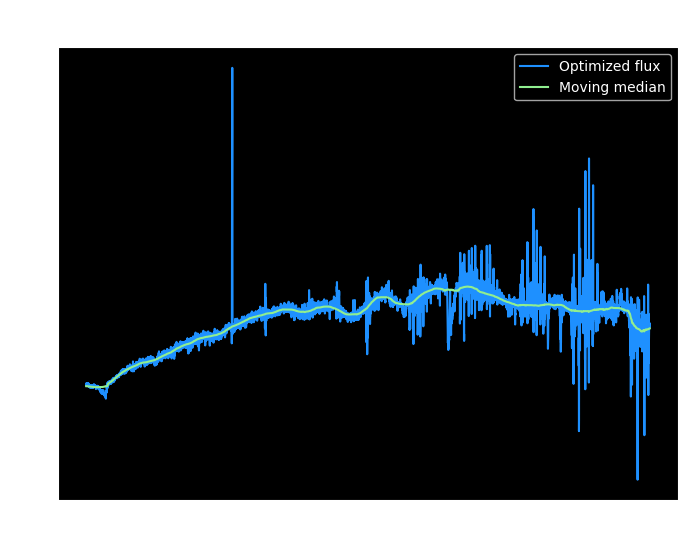

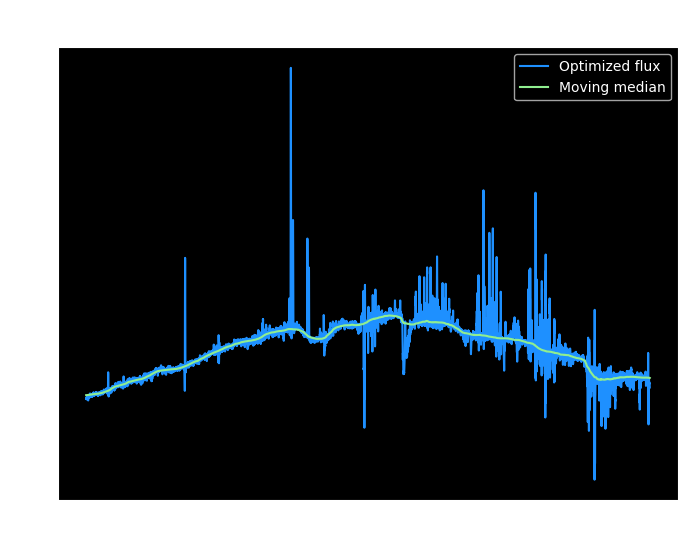

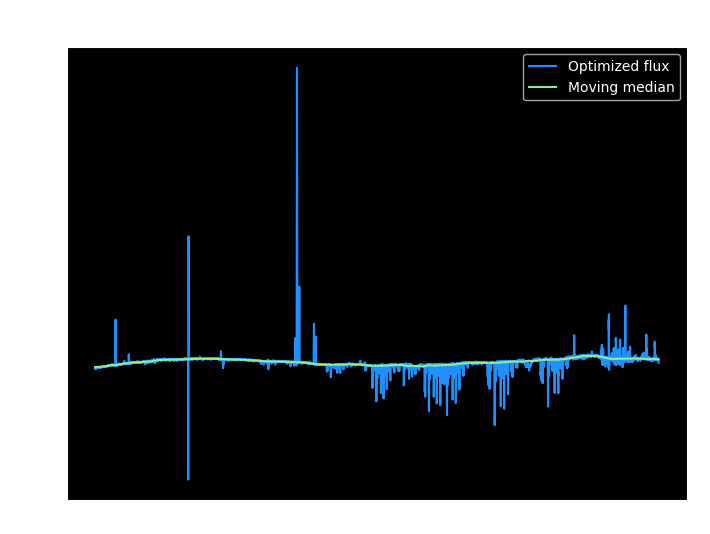

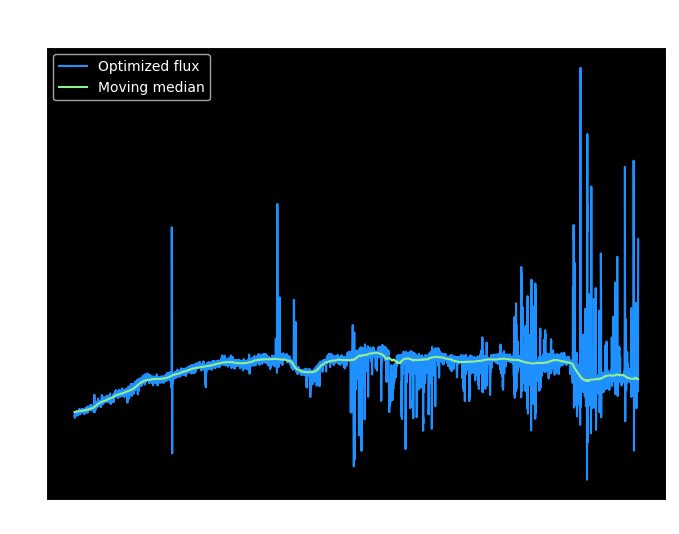

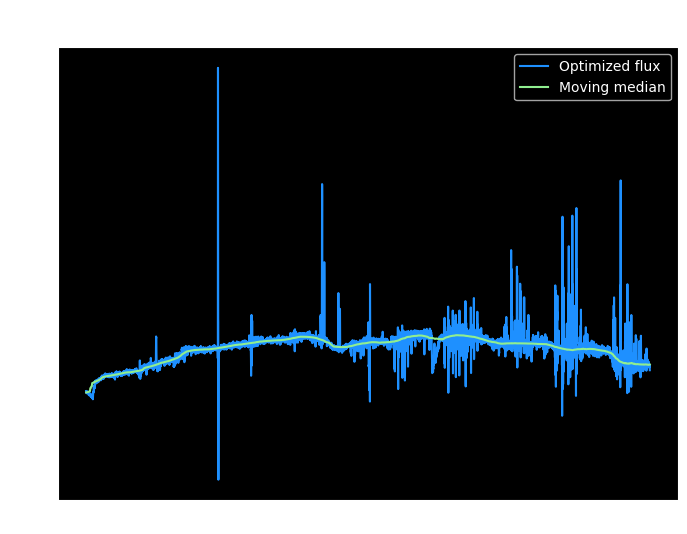

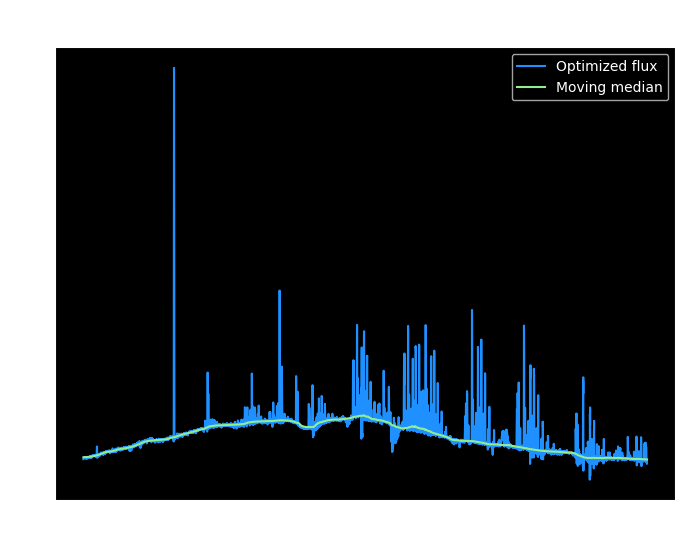

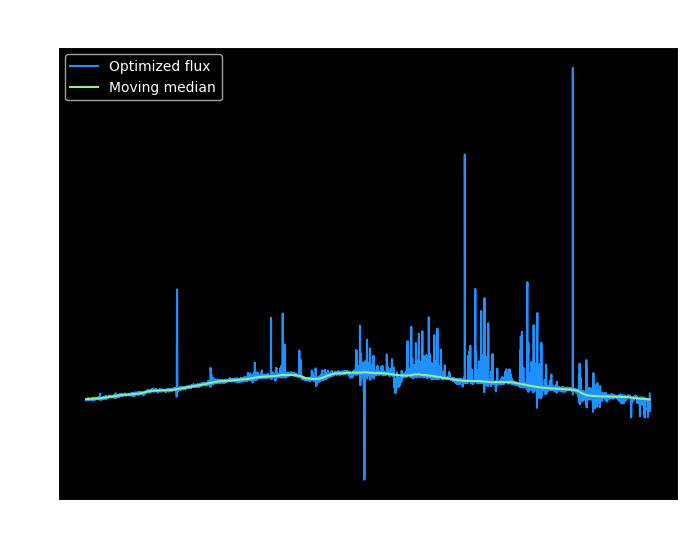

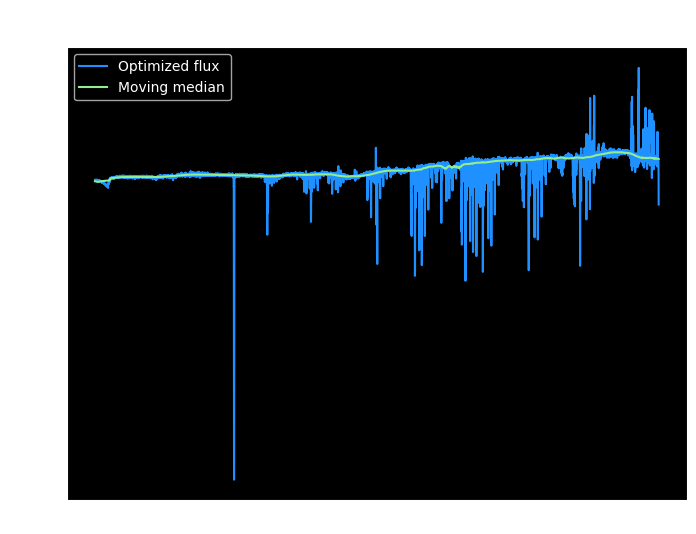

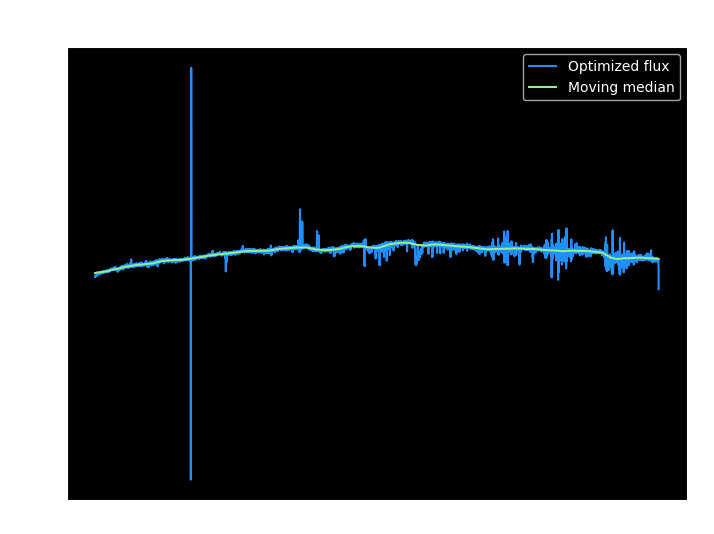

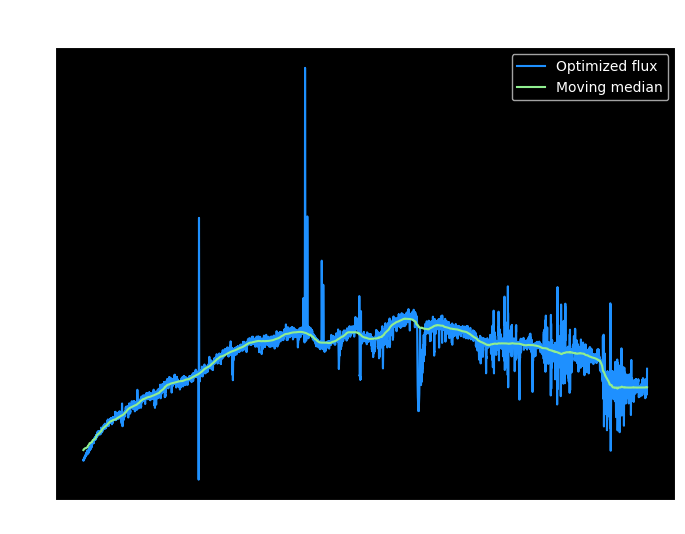

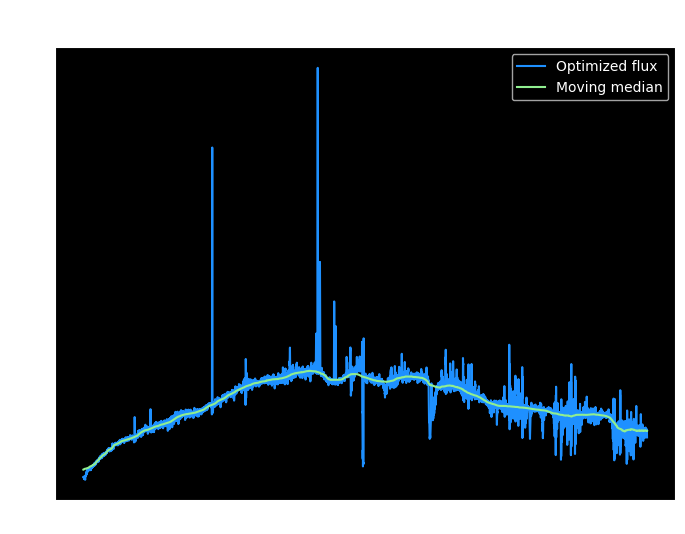

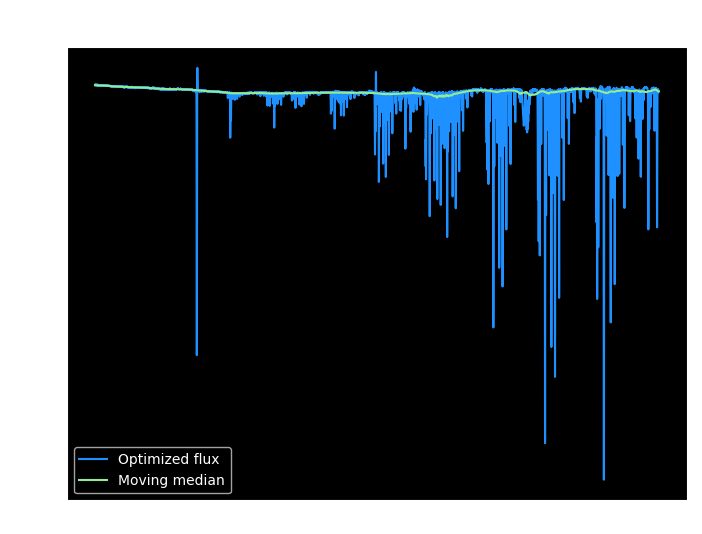

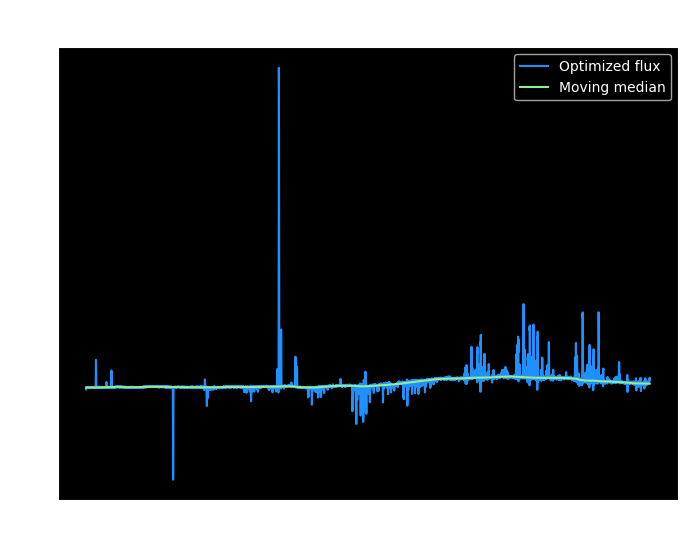

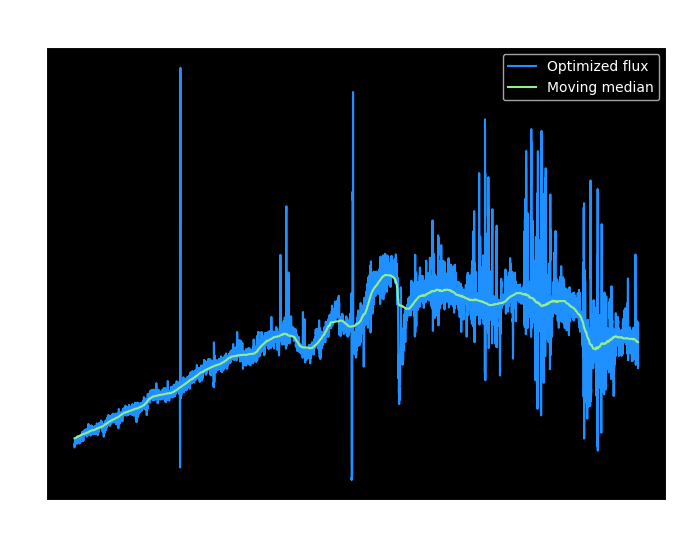

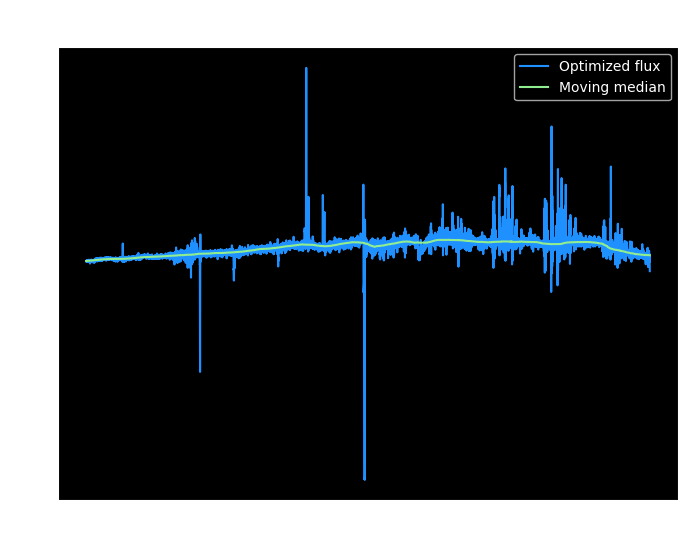

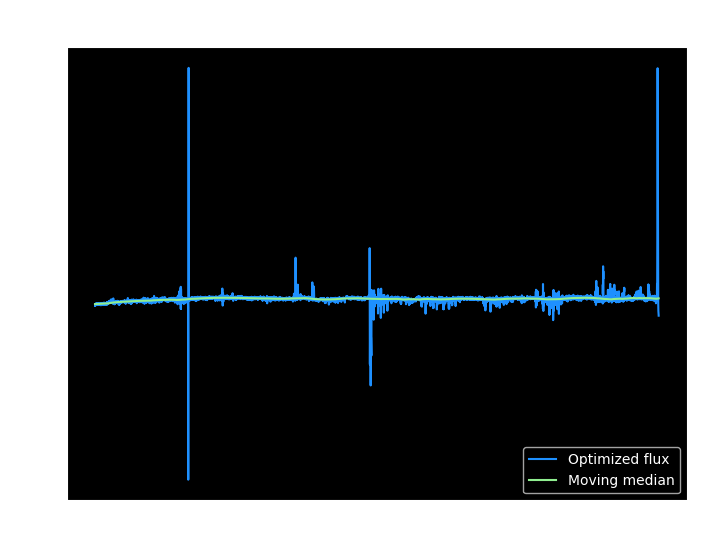

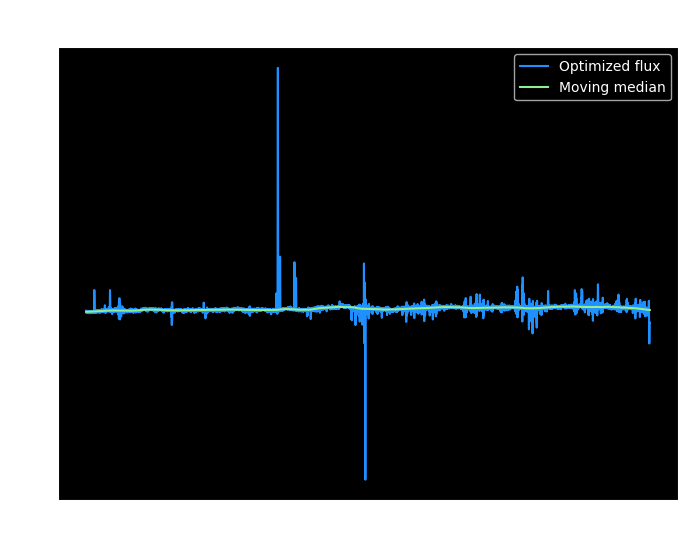

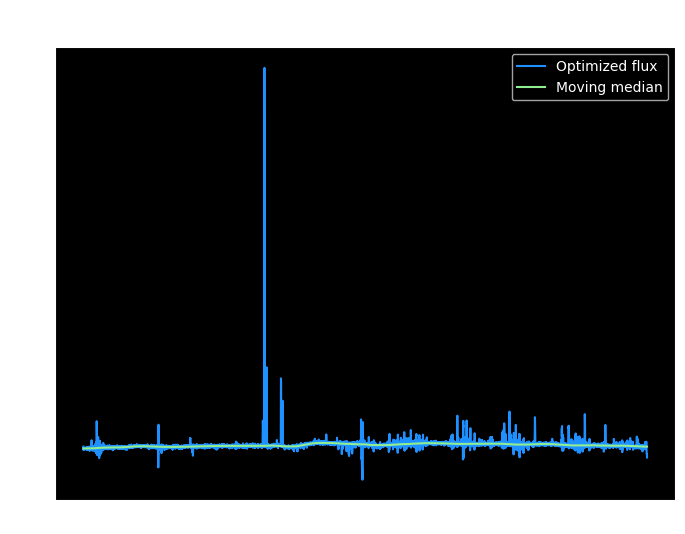

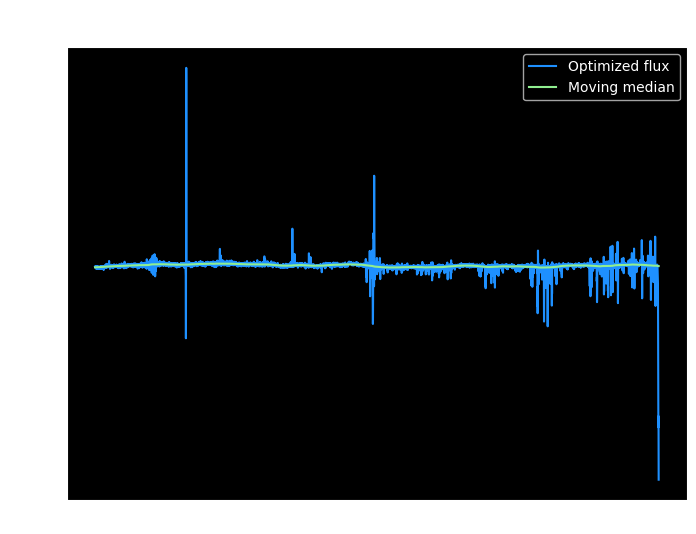

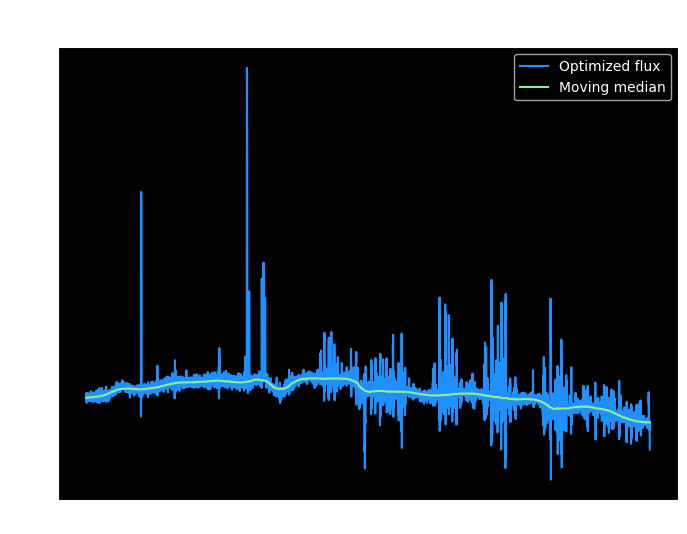

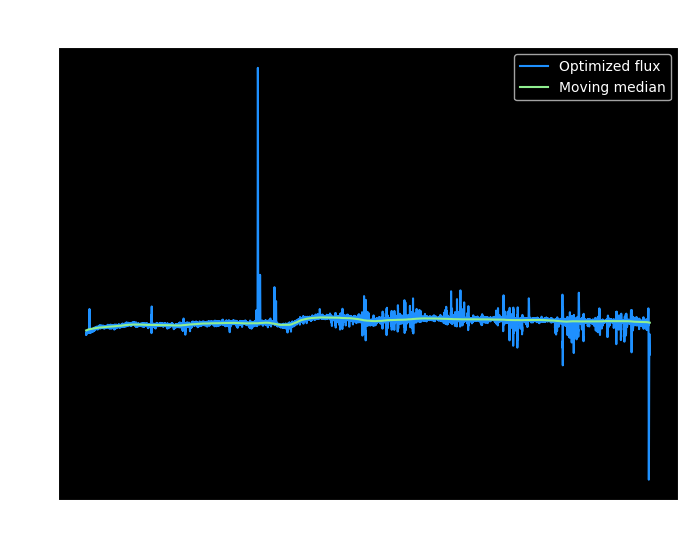

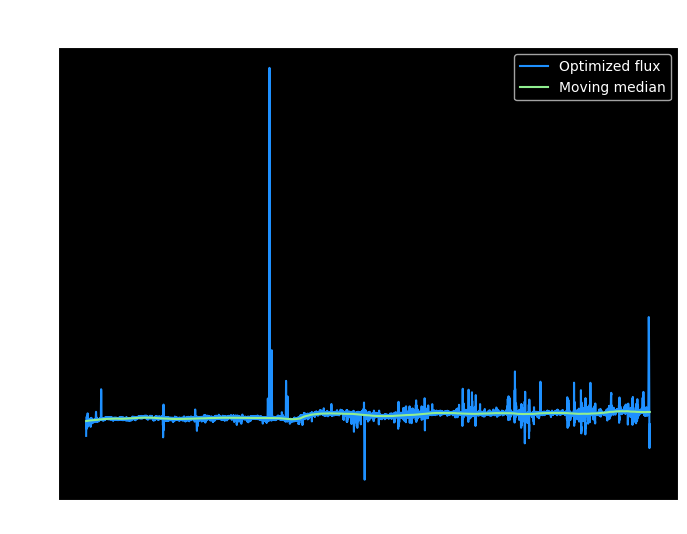

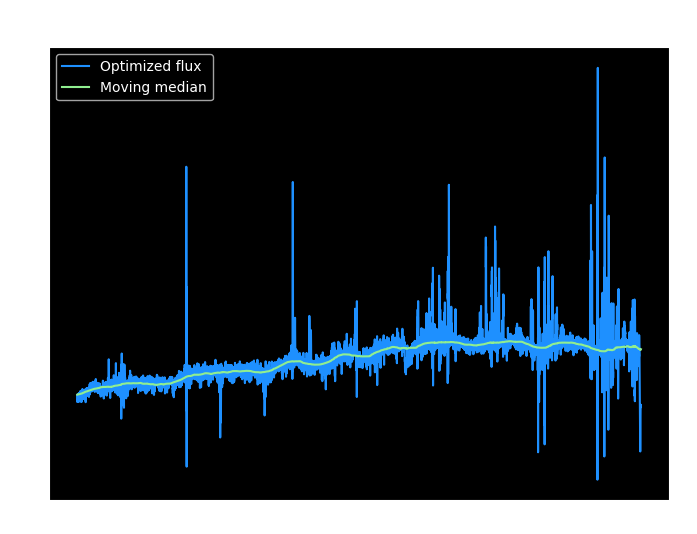

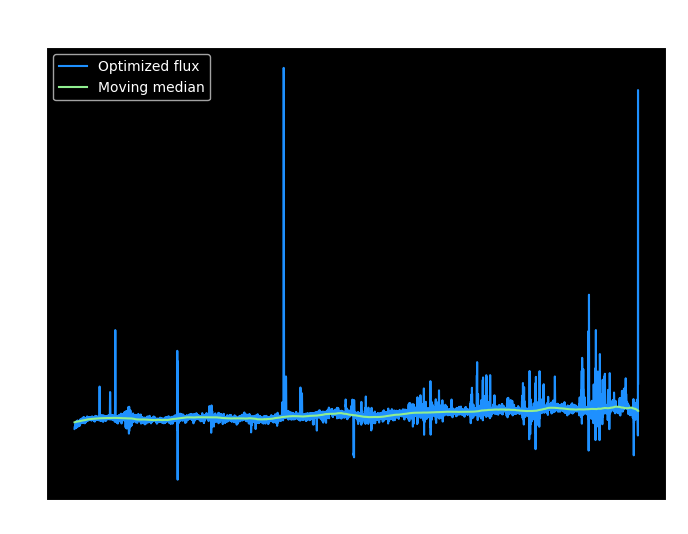

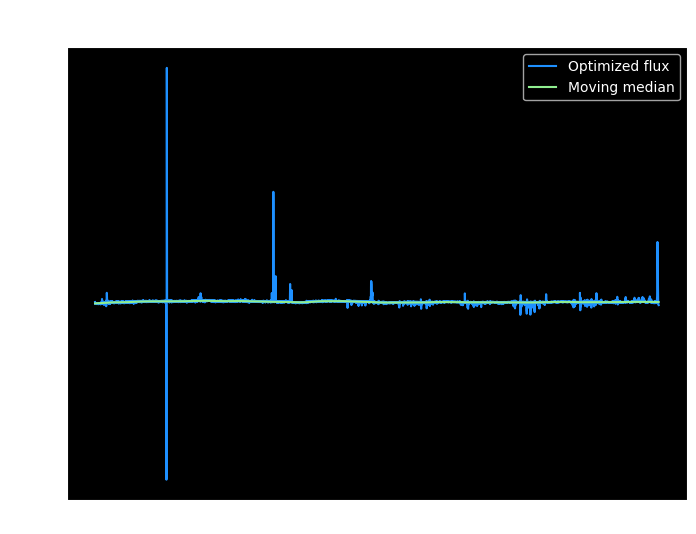

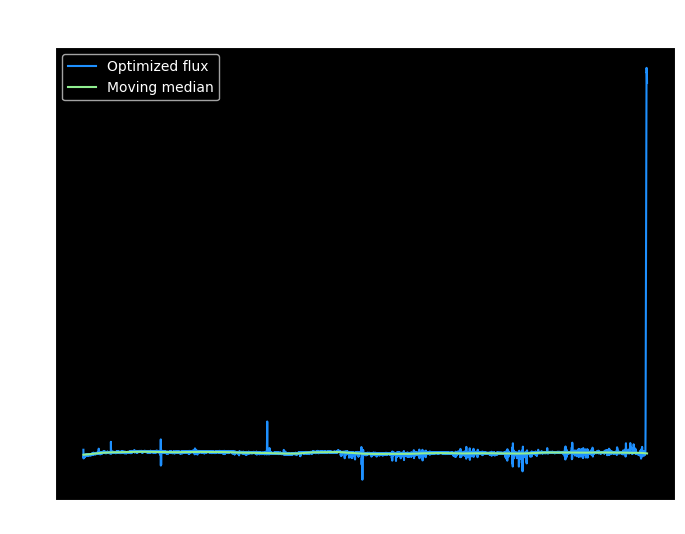

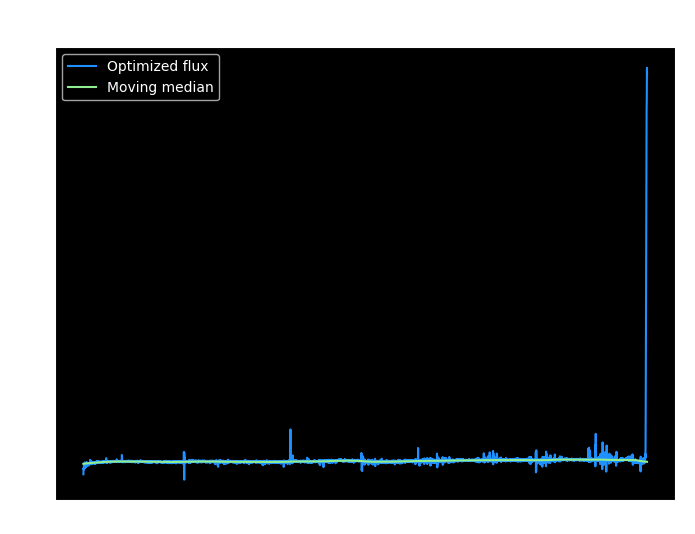

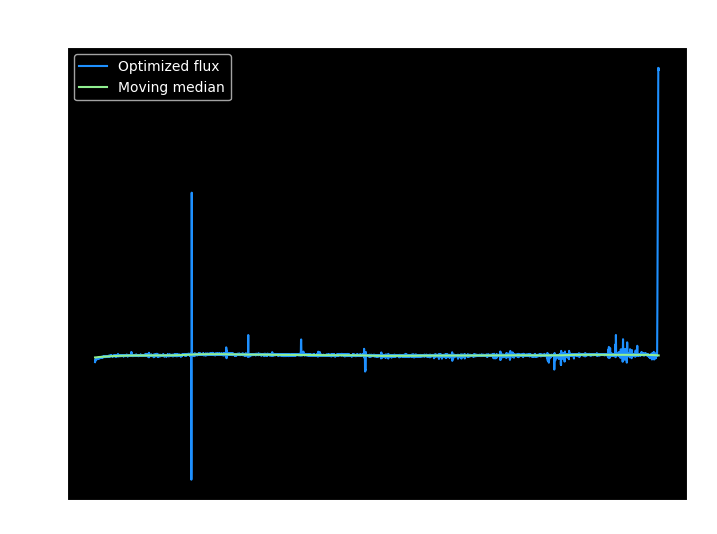

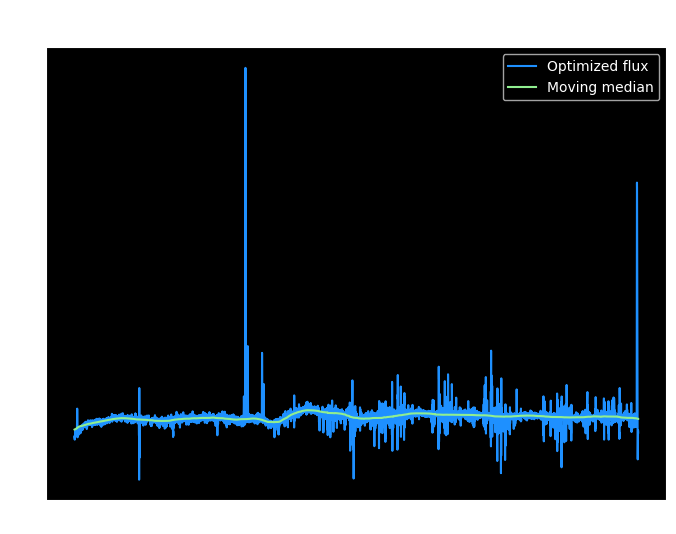

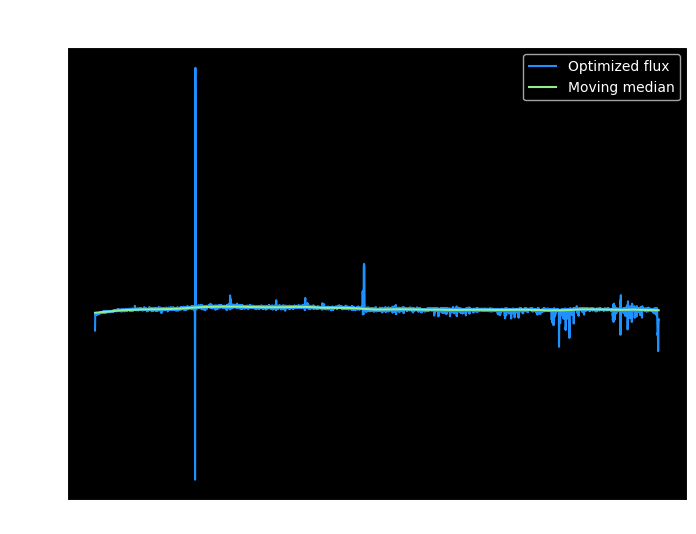

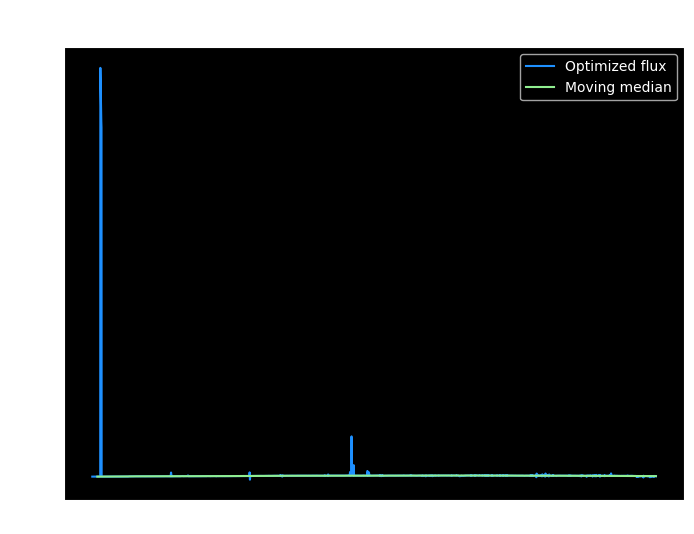

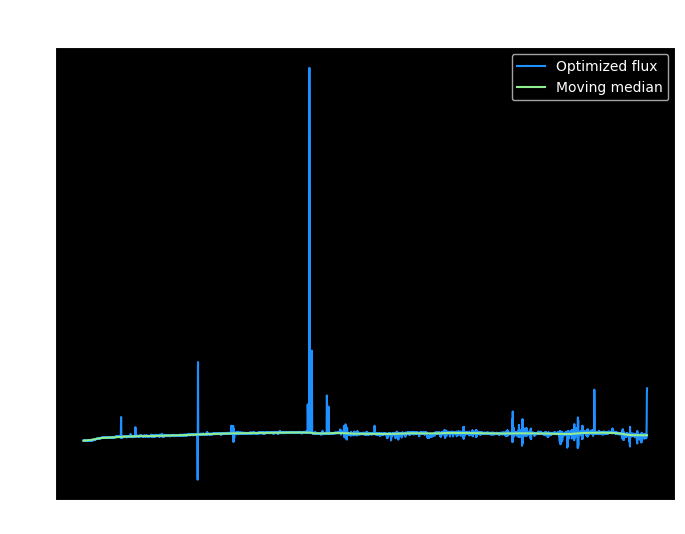

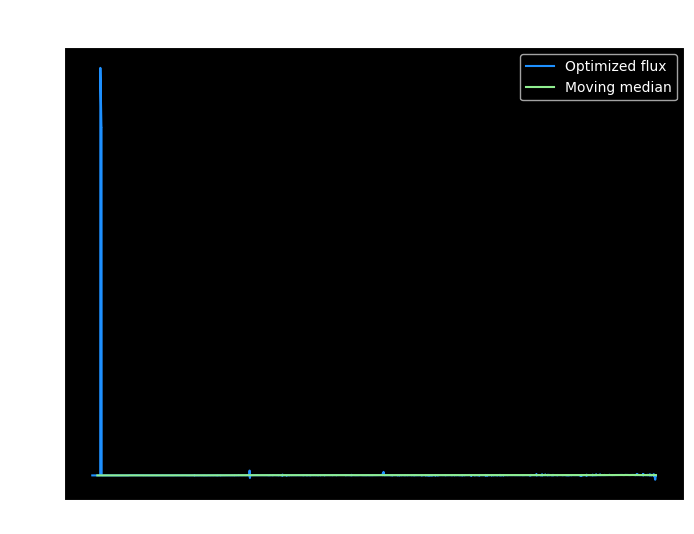

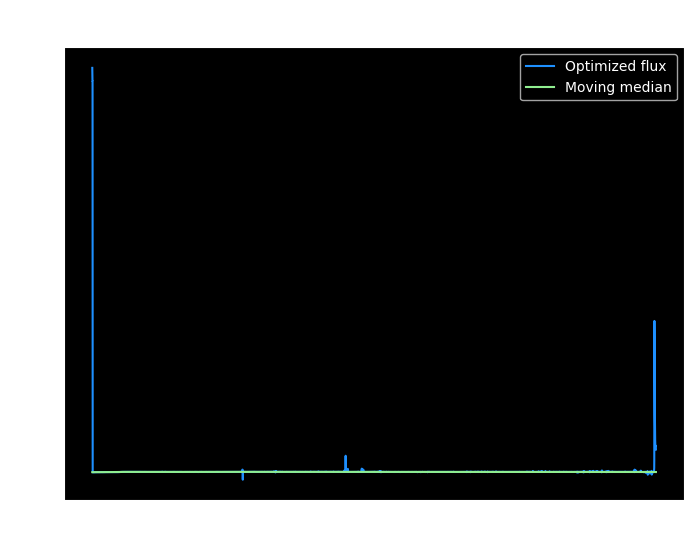

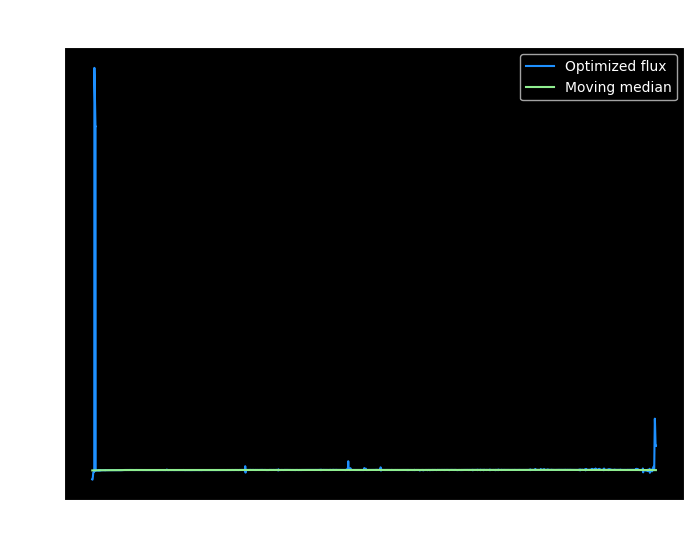

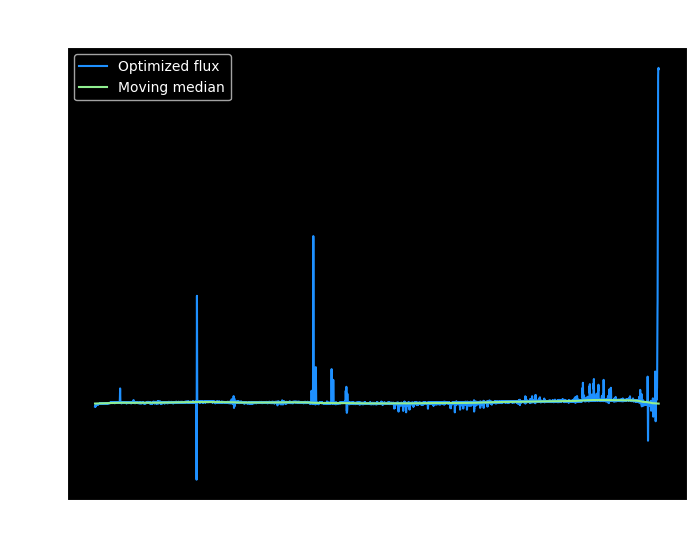

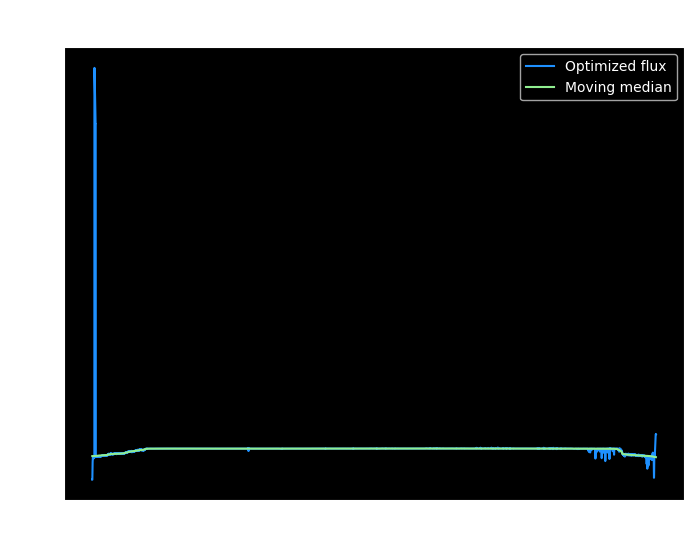

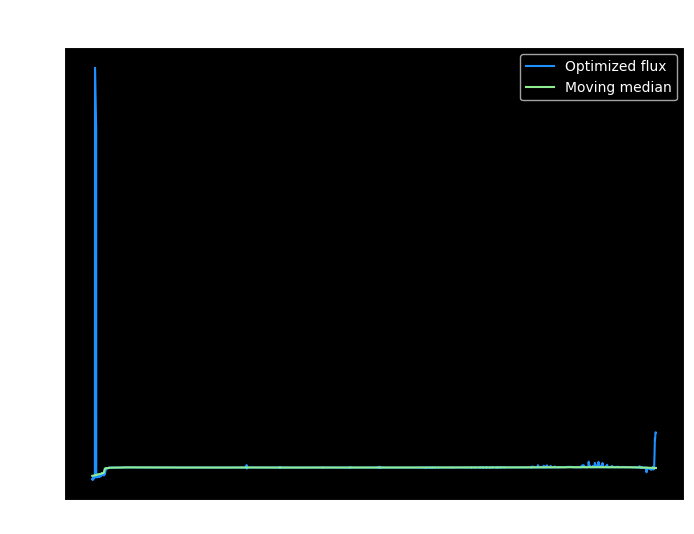

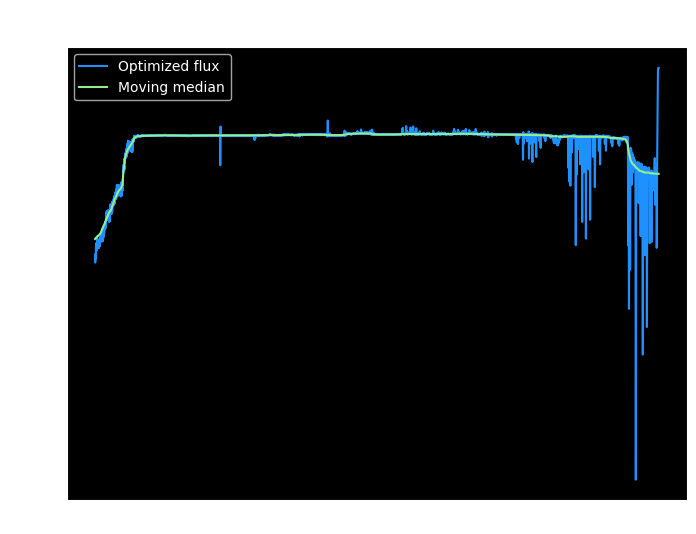

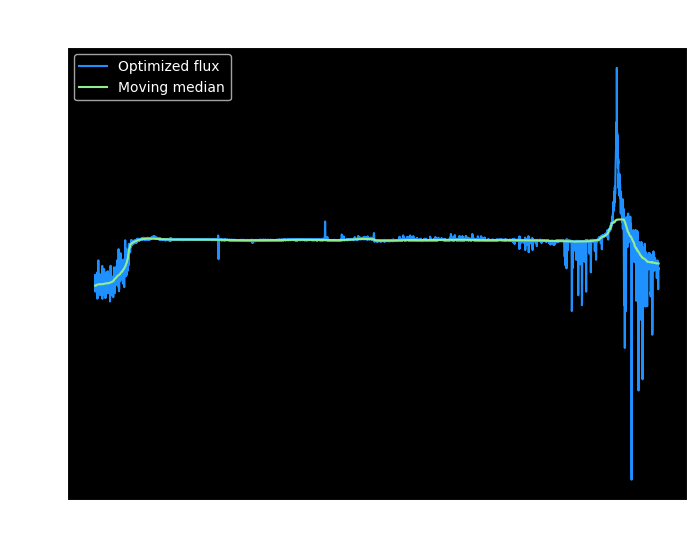

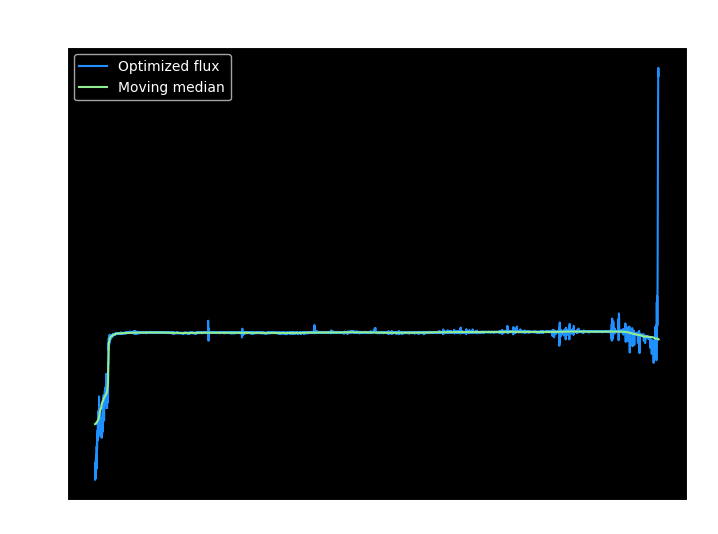

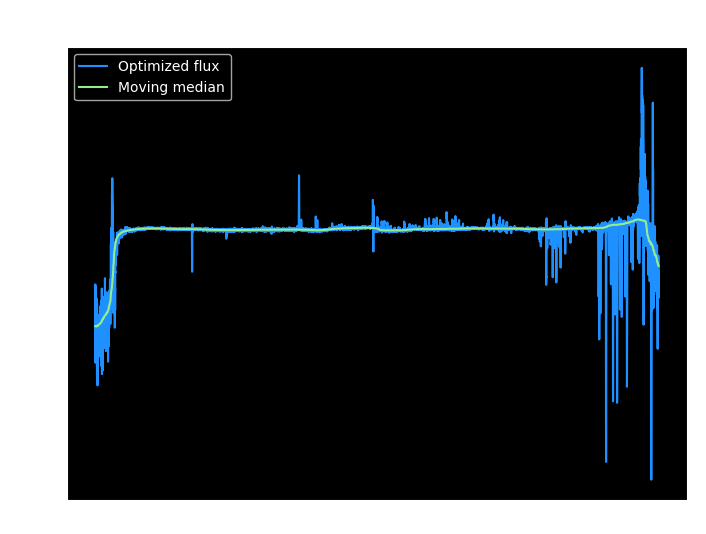

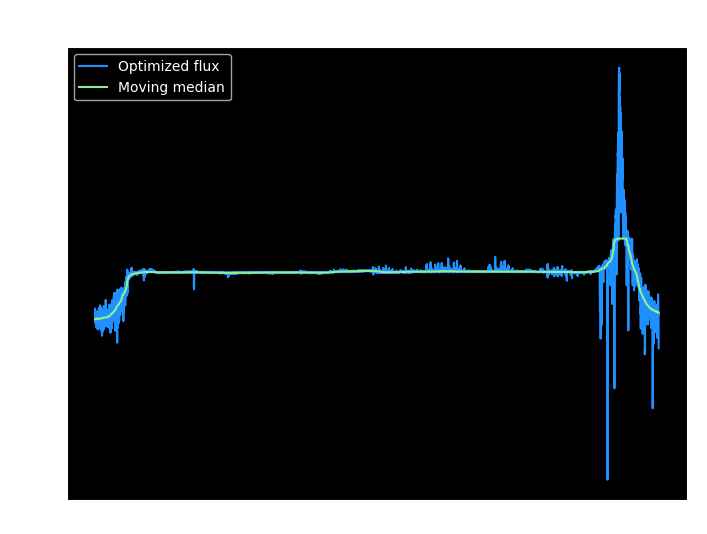

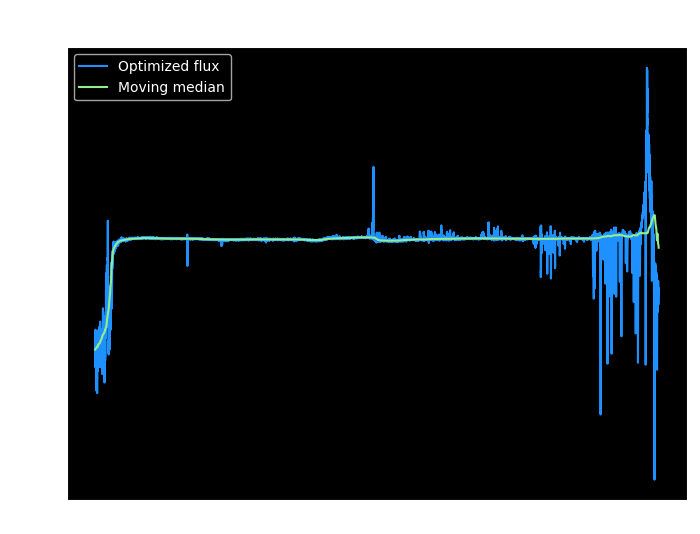

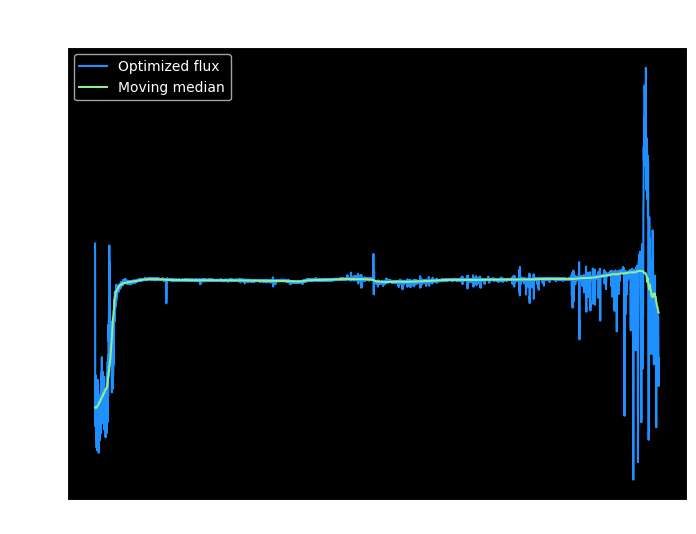

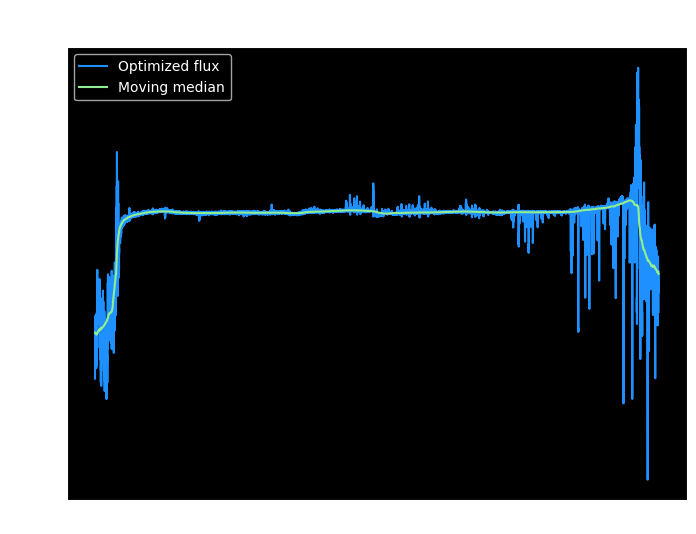

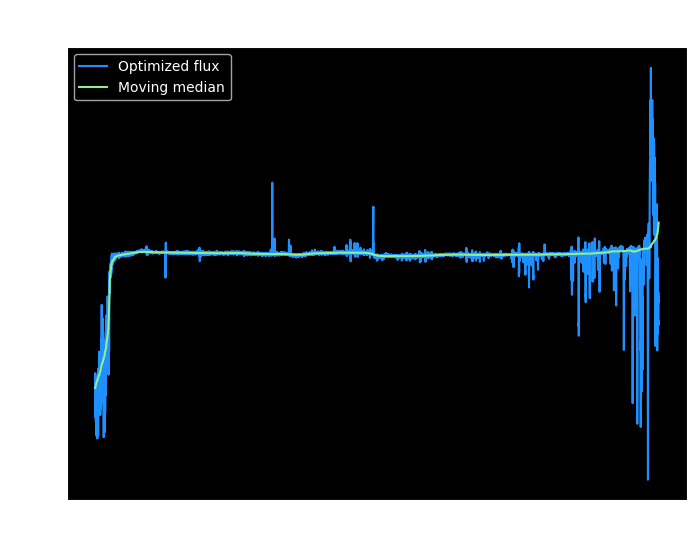

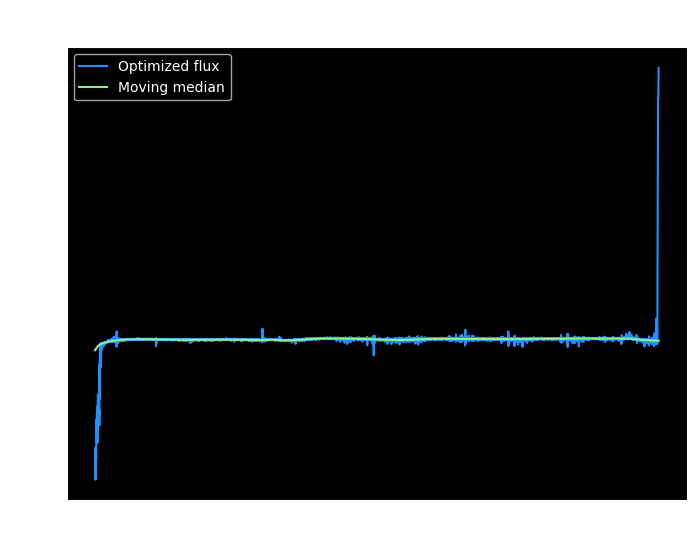

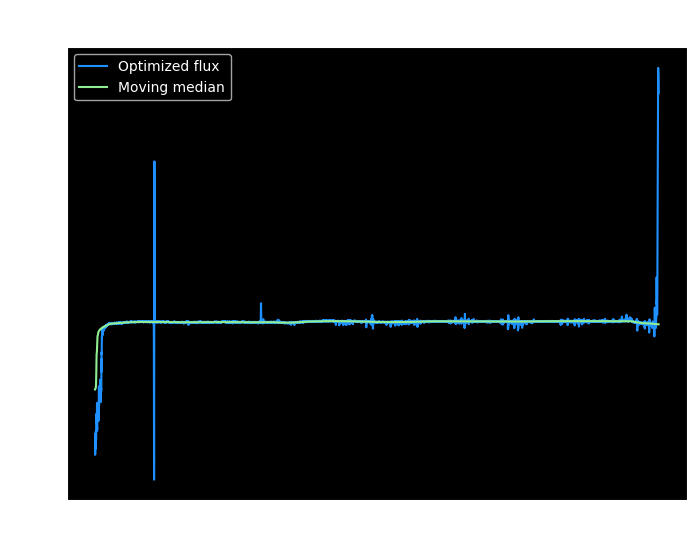

In [18]:
for i in slit_nums_exclude:
    test_flux_i = excluded_fluxes_dict[i]
    moving_median_center_i = moving_median_new(test_flux_i, window=325, center_align=True)
    plt.figure(figsize=(8,6), dpi=100)
    plt.tight_layout()

    # plt.subplot(1,2,1)
    plt.plot(rbwave, test_flux_i, color='dodgerblue', label='Optimized flux')
    plt.plot(rbwave, moving_median_center_i, color='lightgreen', label='Moving median')
    plt.legend()
    plt.title('Optimized flux with starlight contamination\nMask: {0},  Slit:{1}'.format(mask_name,i))
    plt.show()
    plt.close()

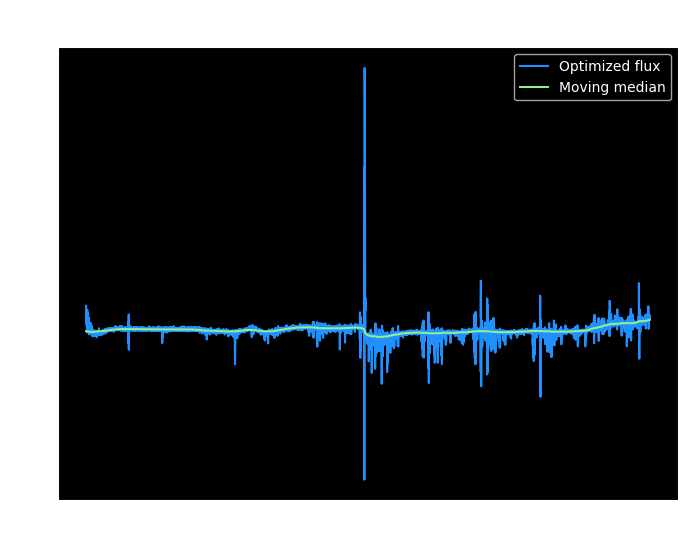

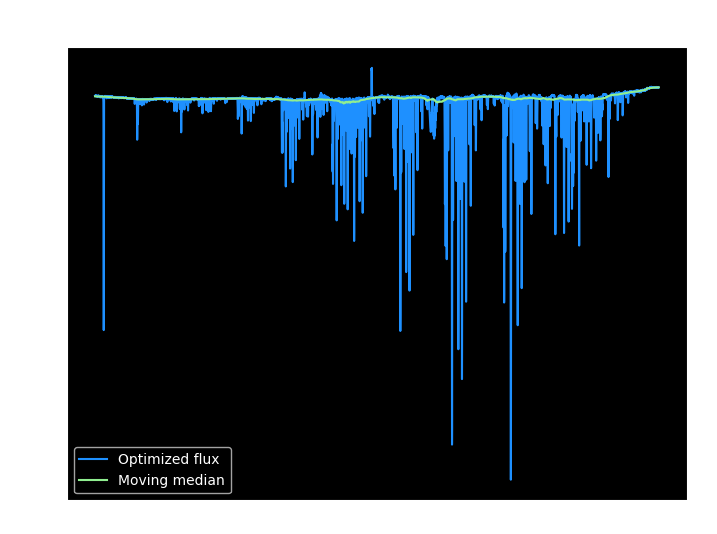

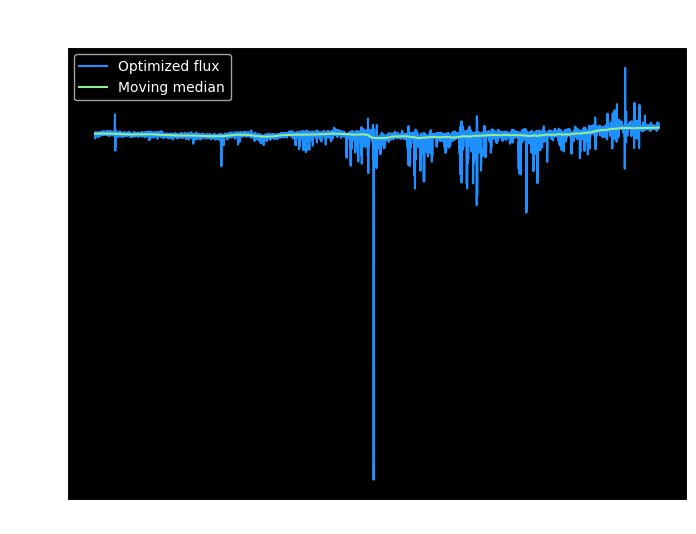

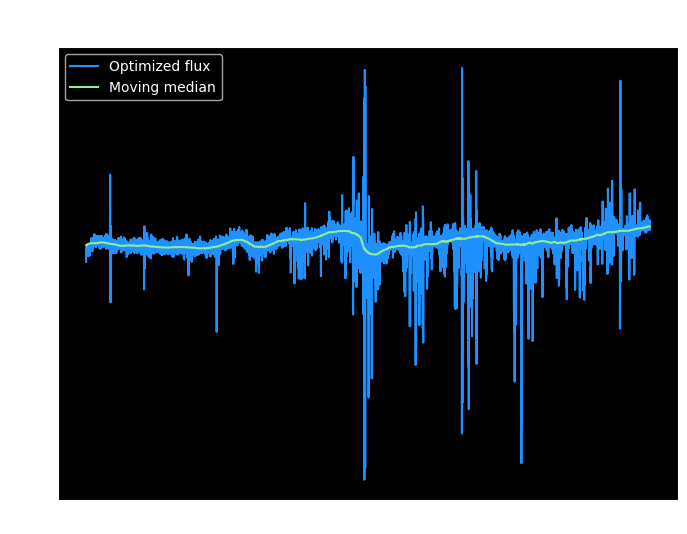

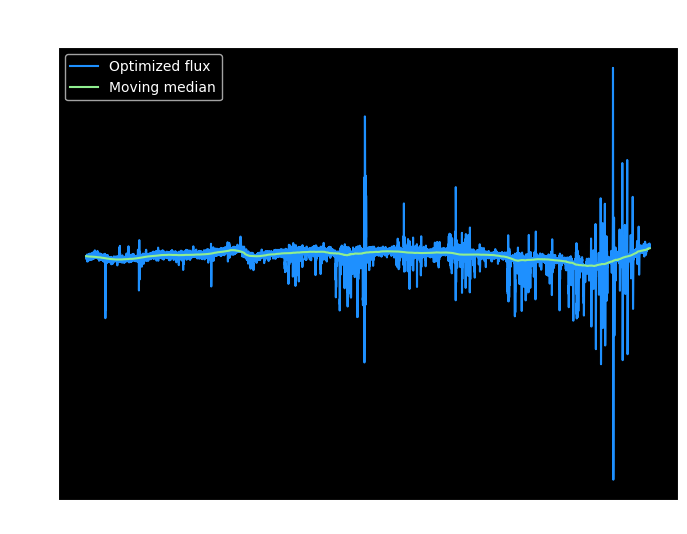

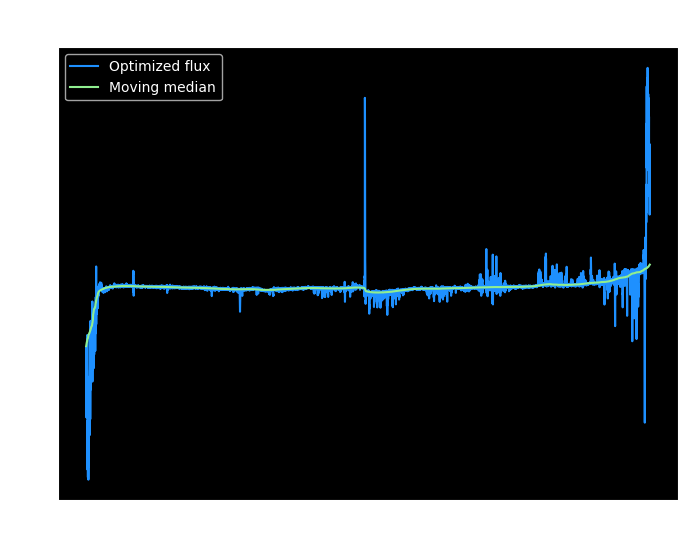

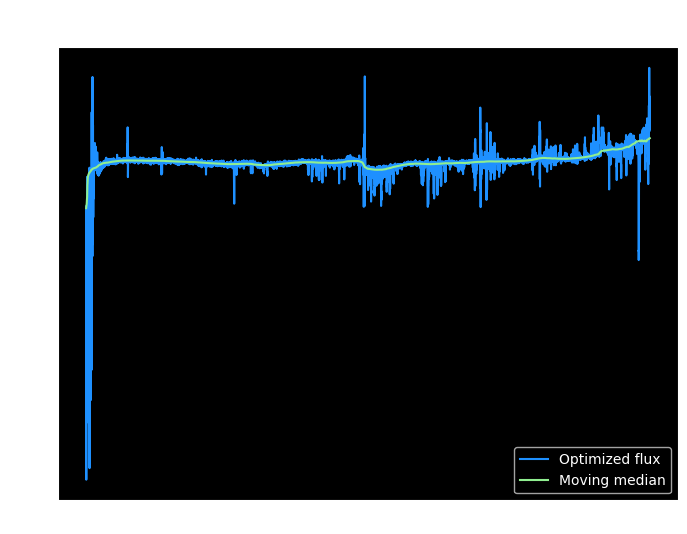

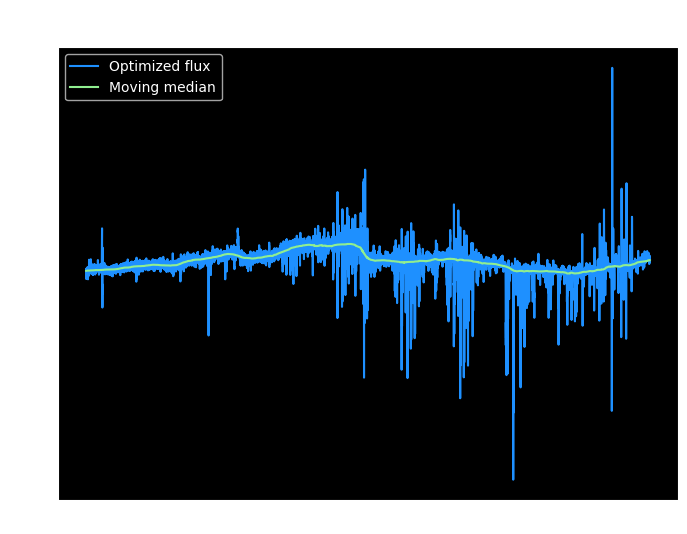

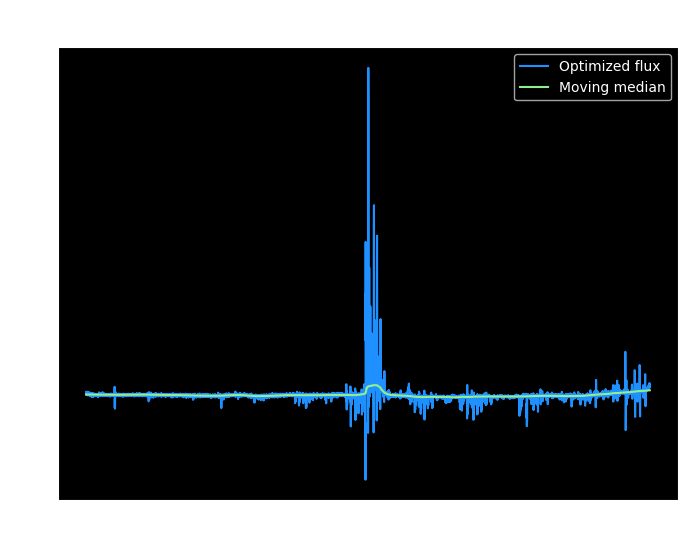

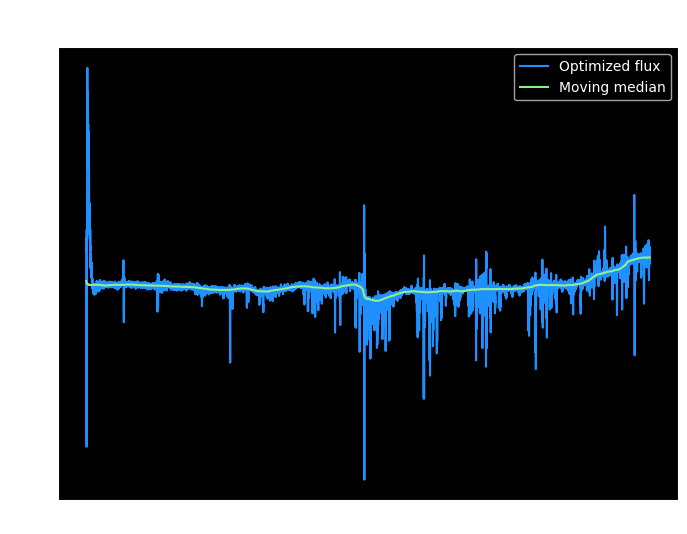

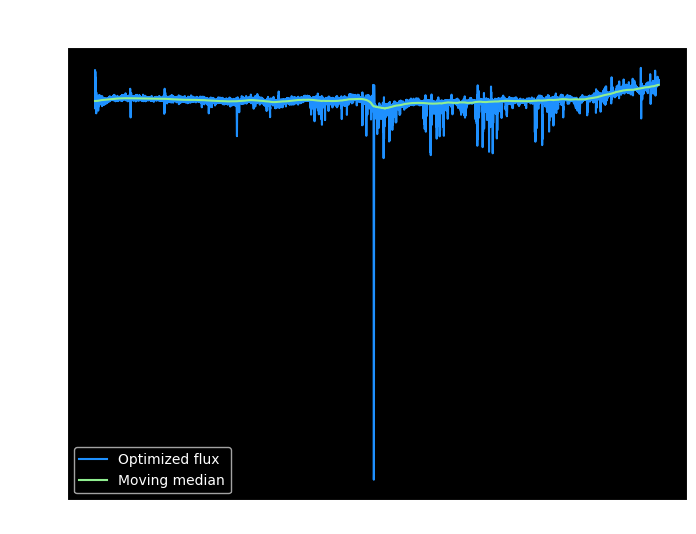

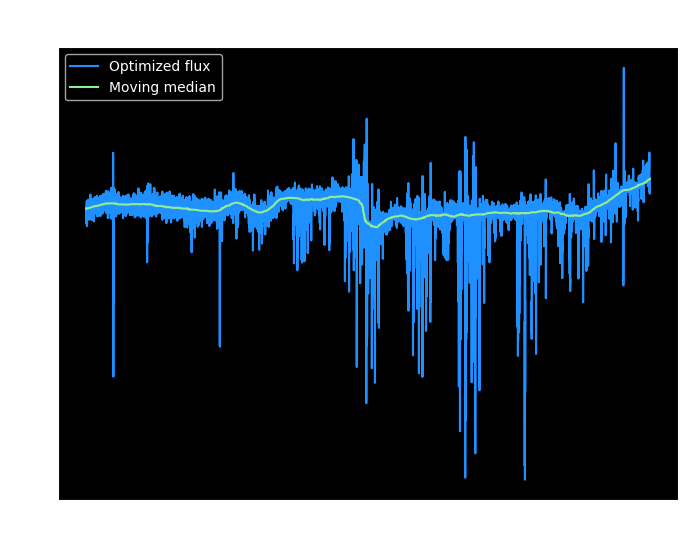

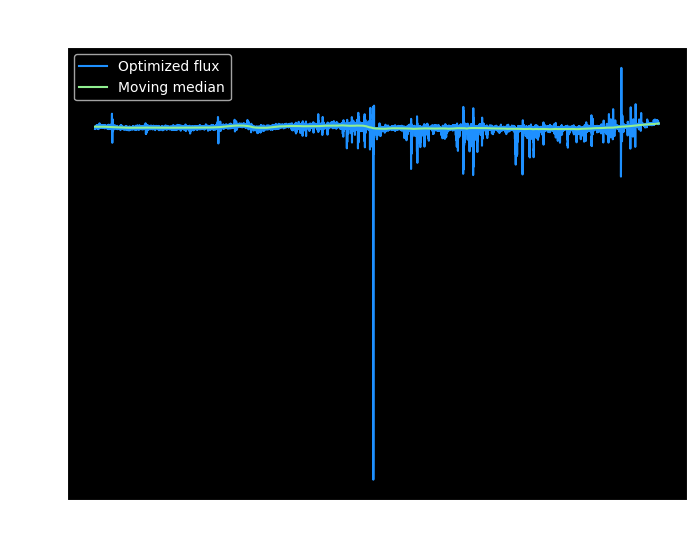

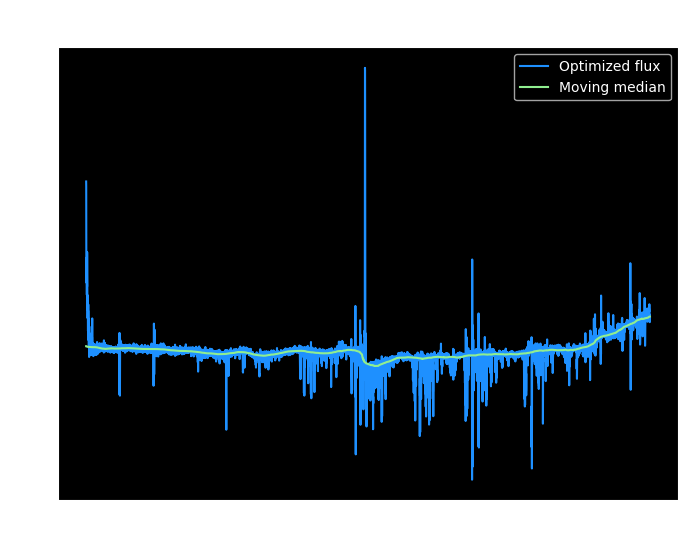

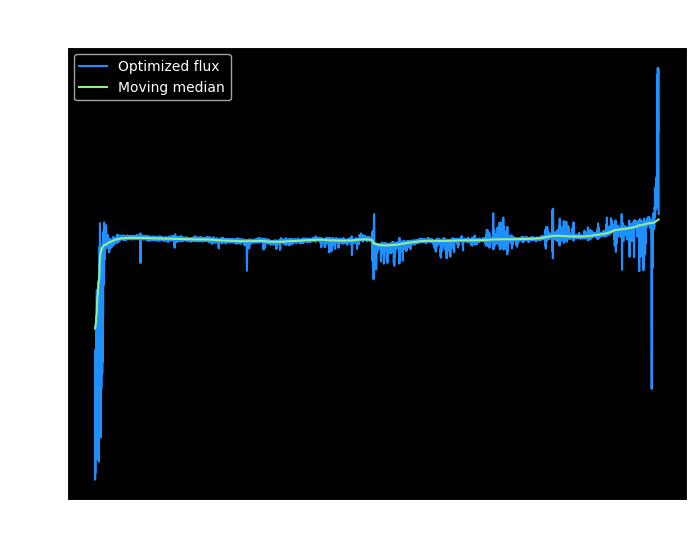

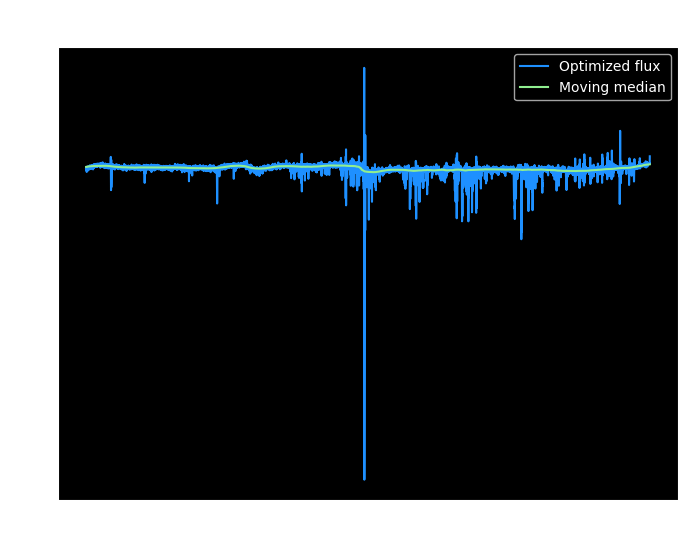

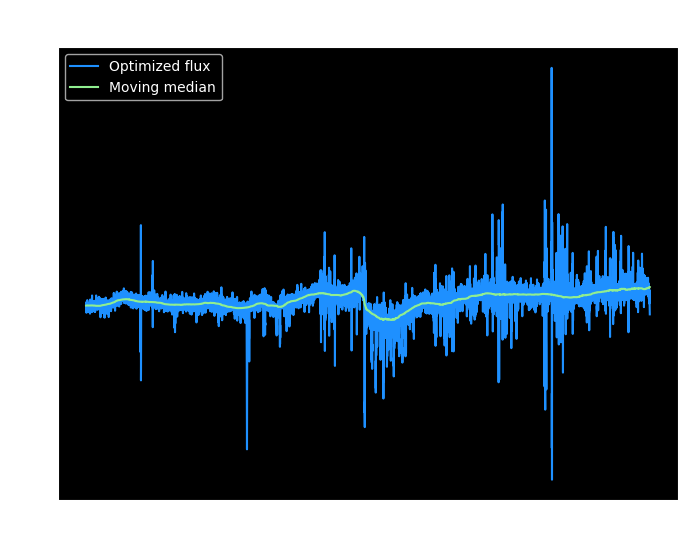

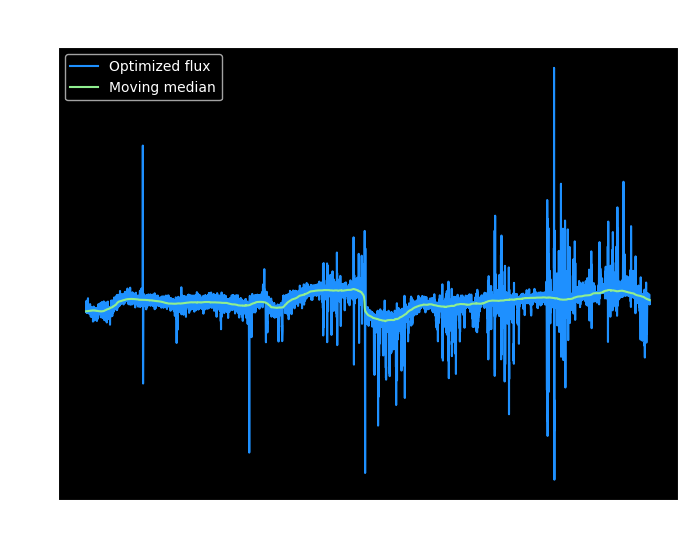

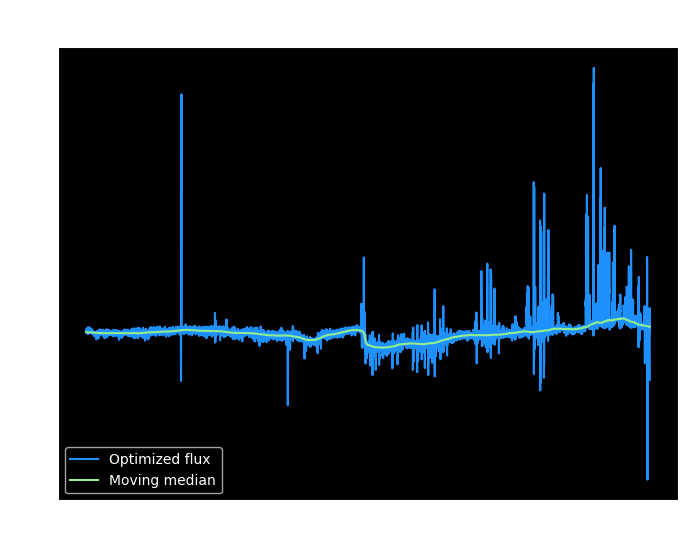

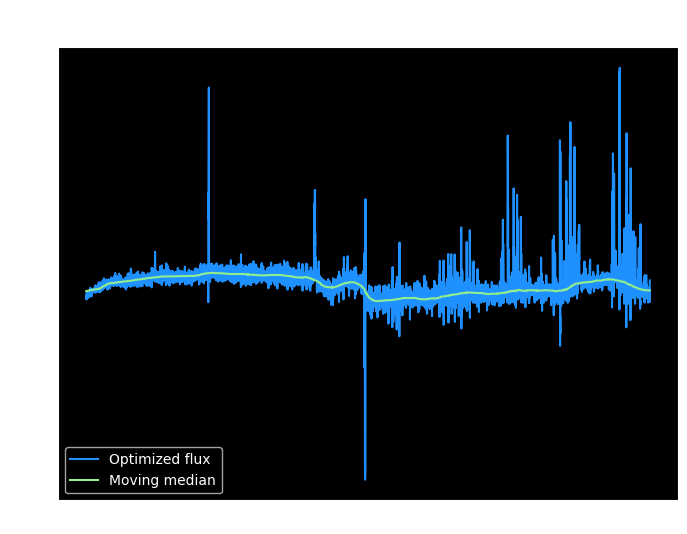

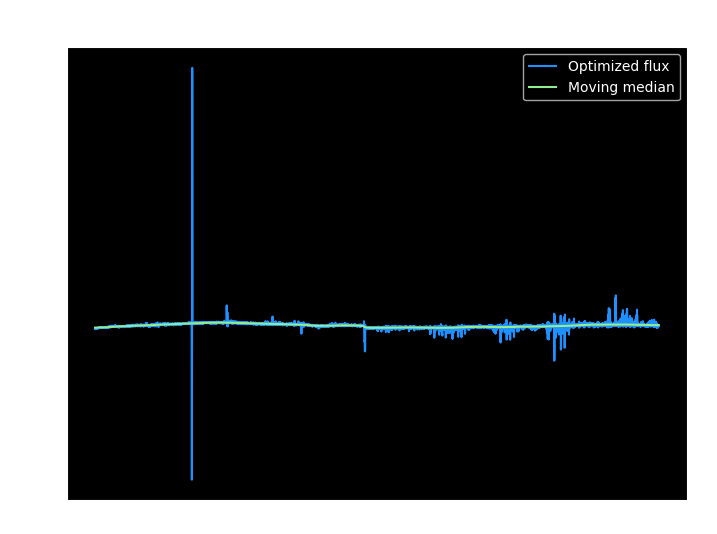

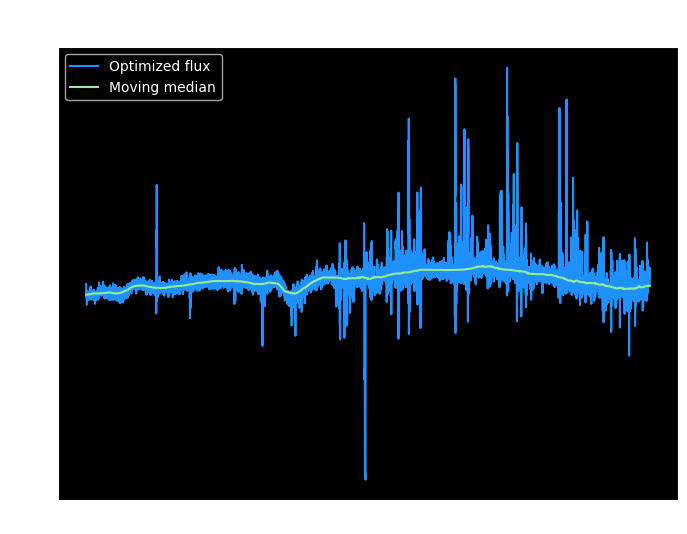

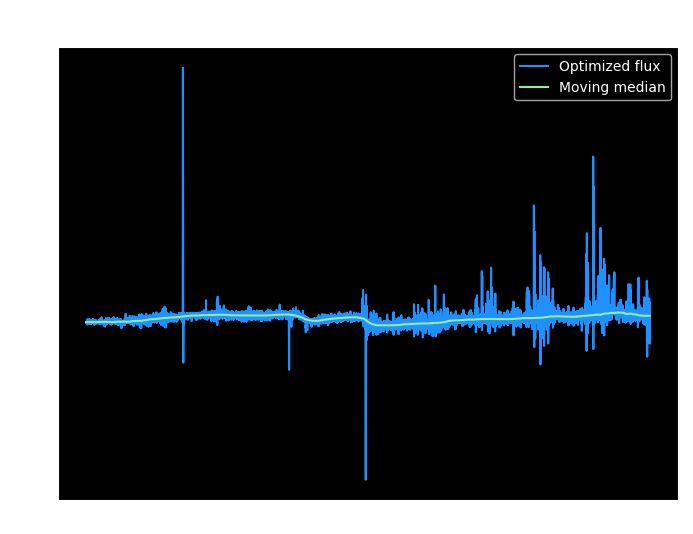

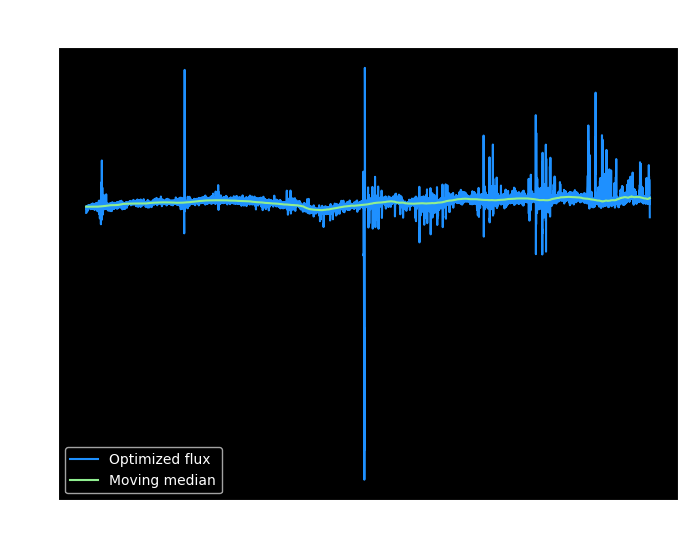

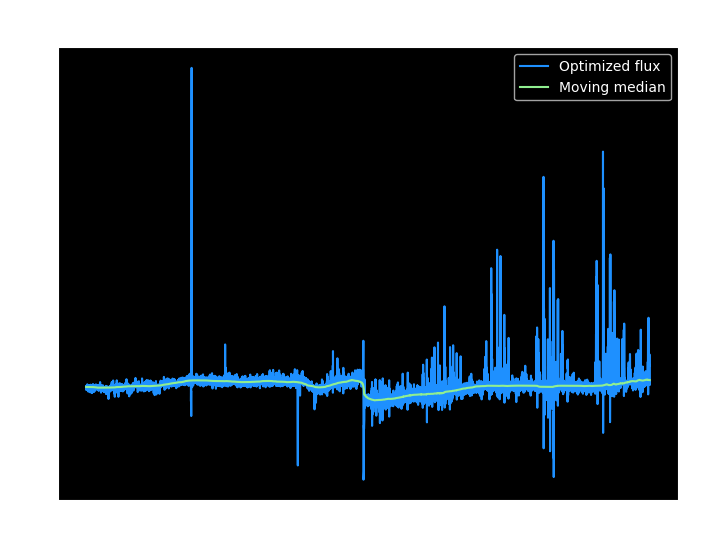

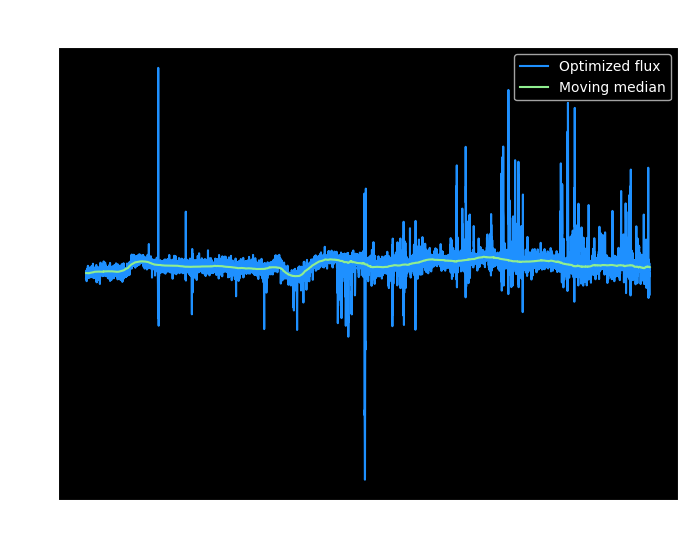

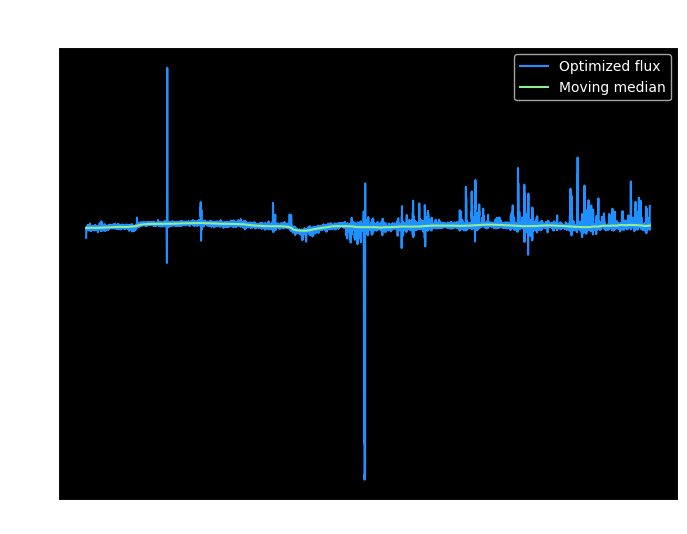

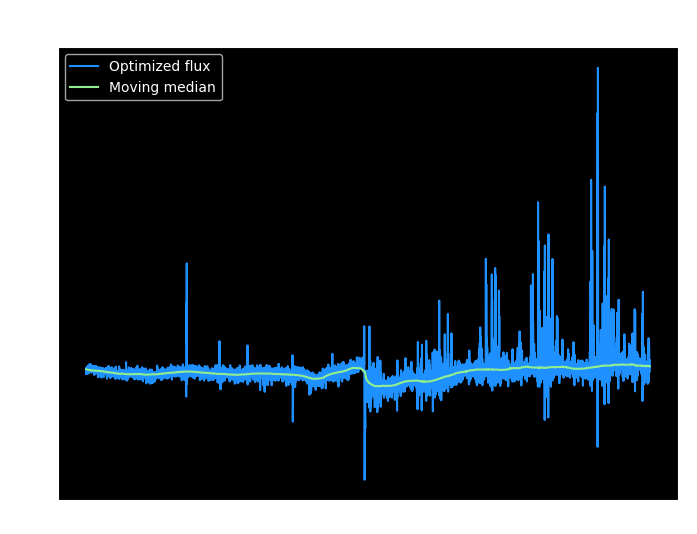

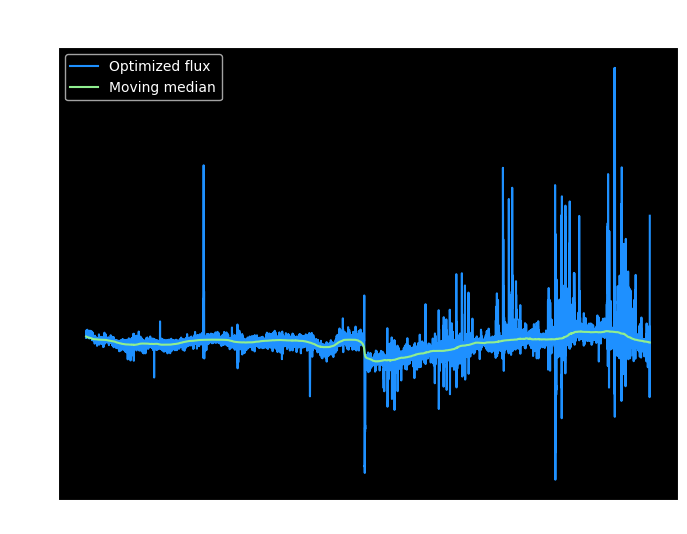

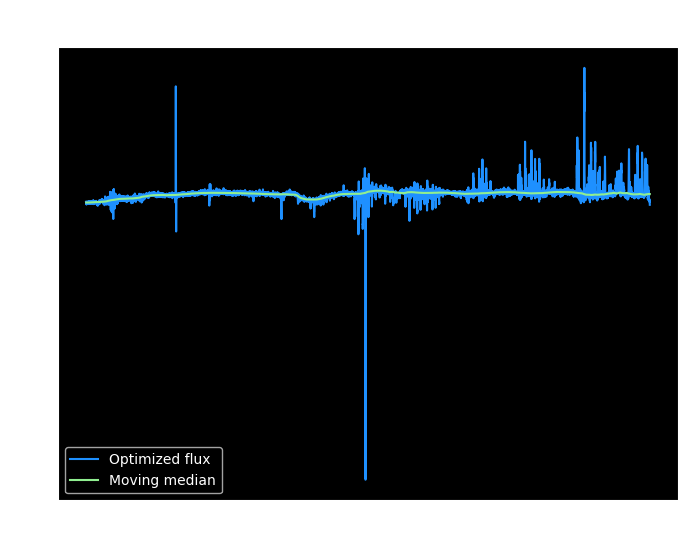

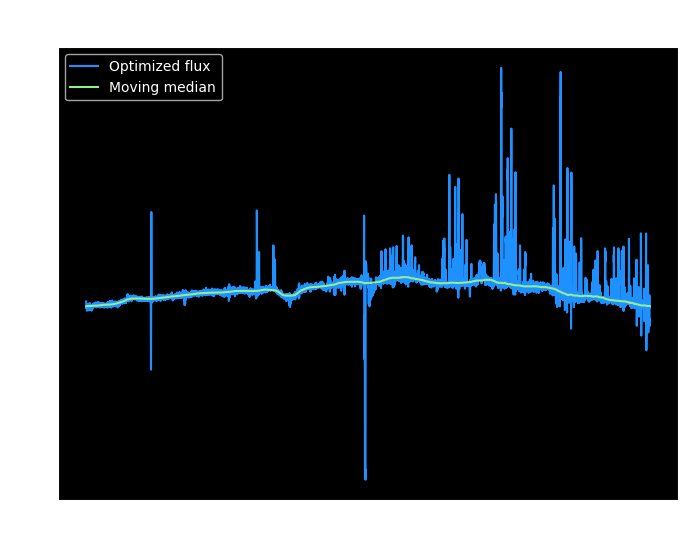

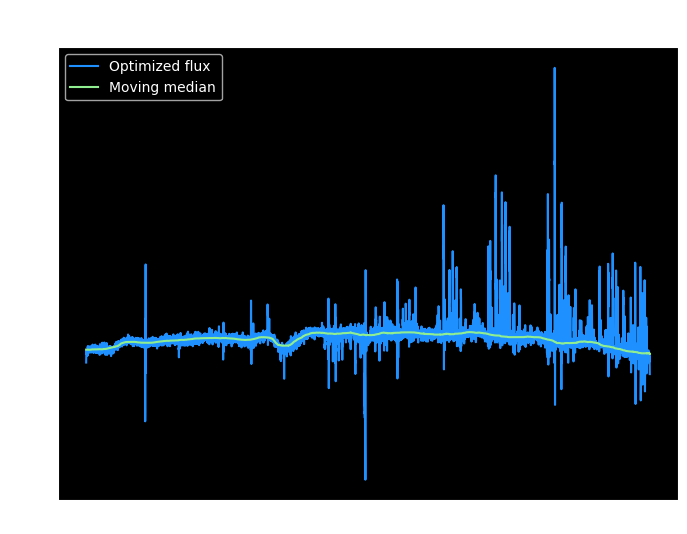

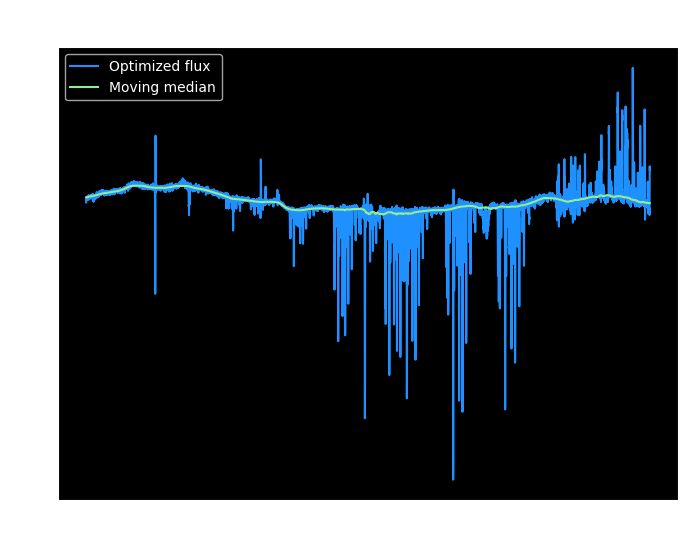

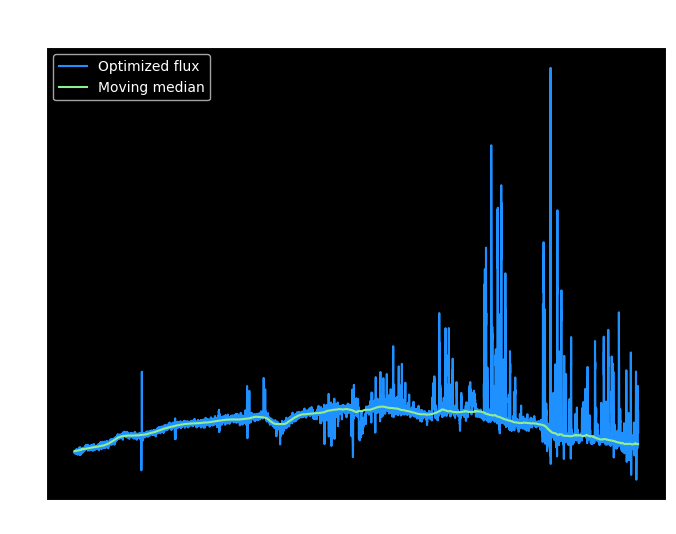

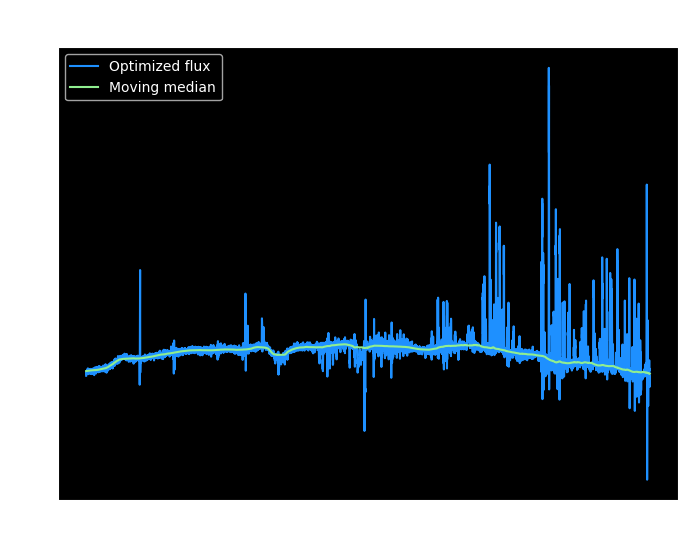

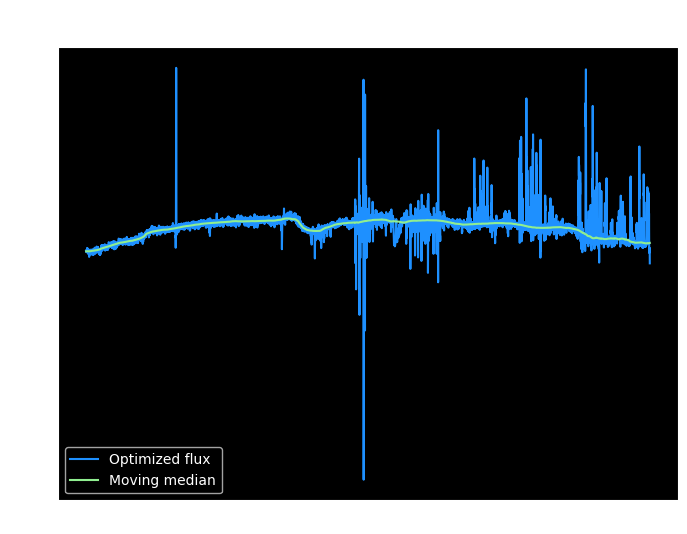

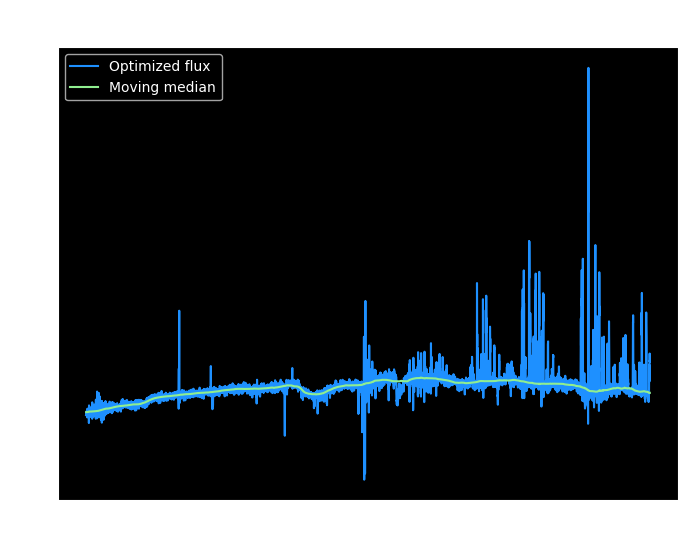

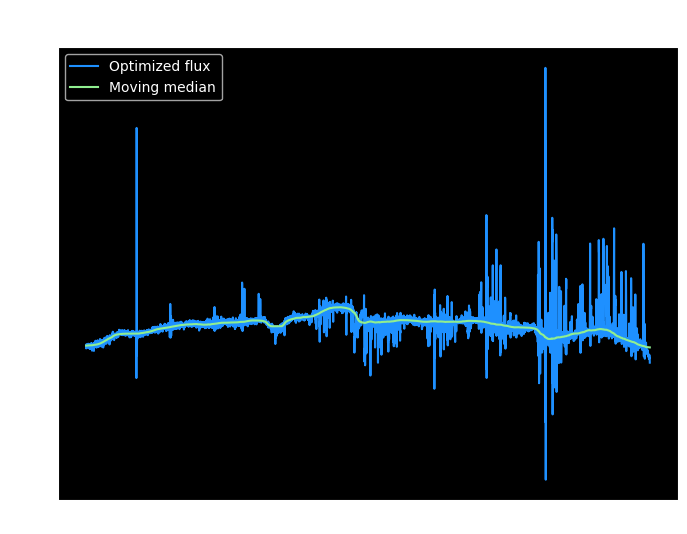

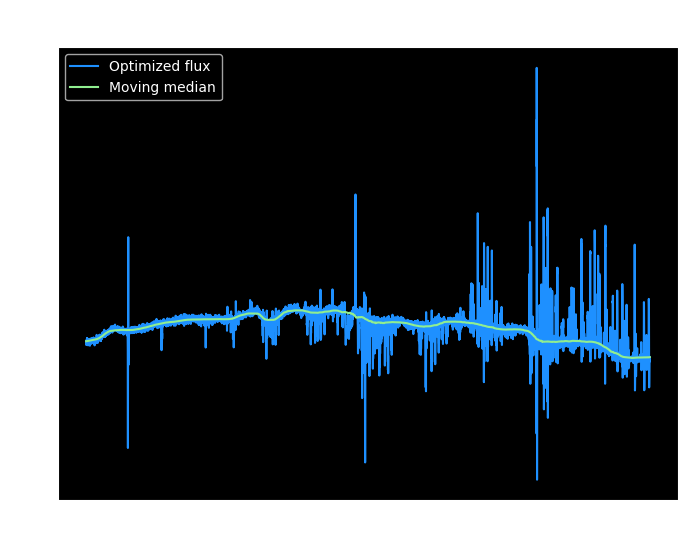

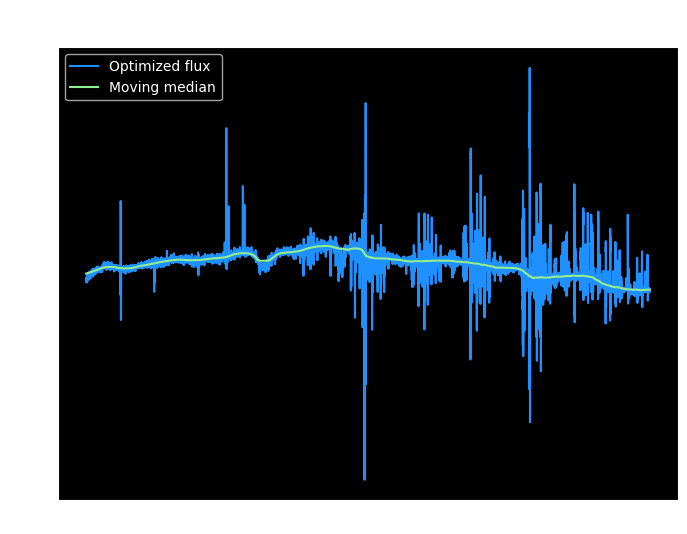

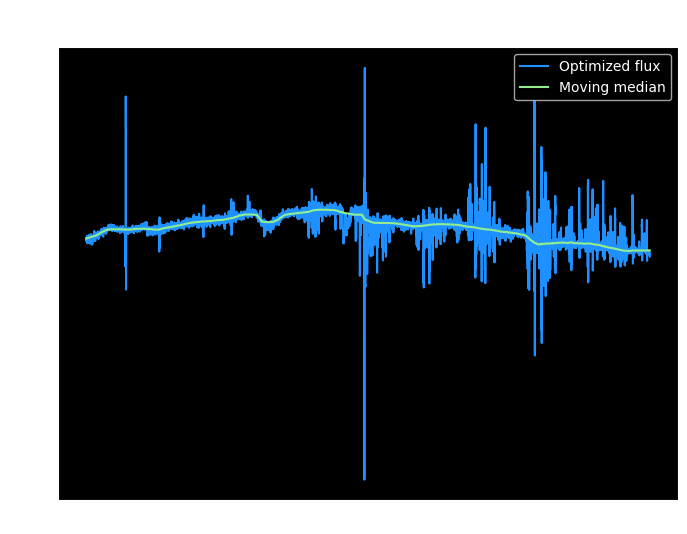

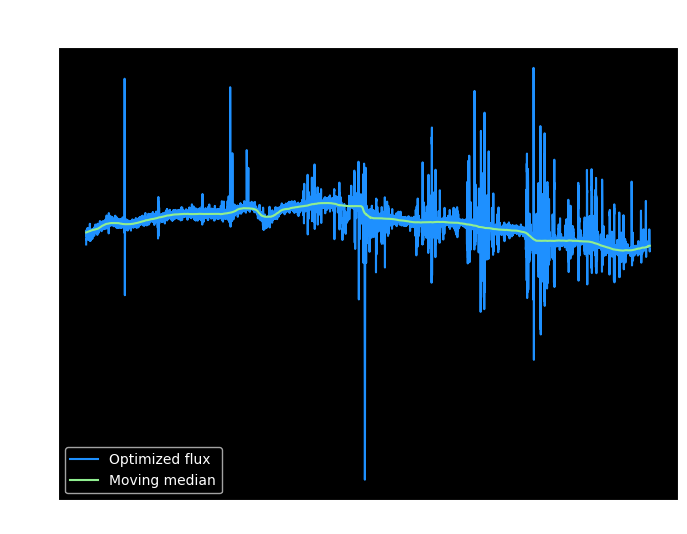

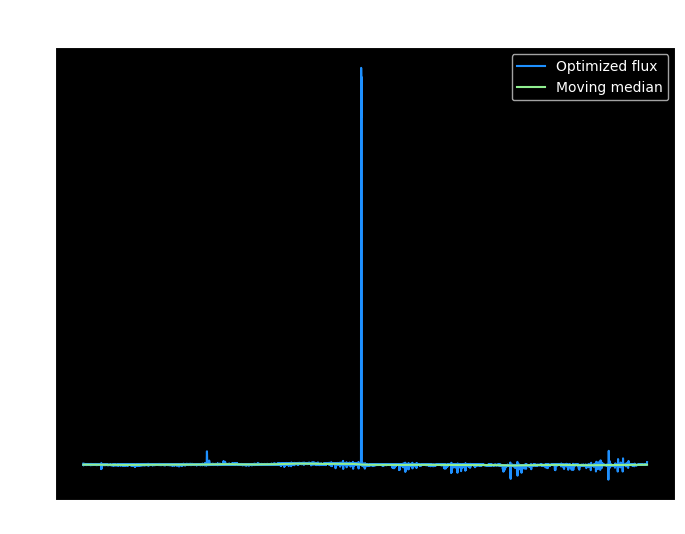

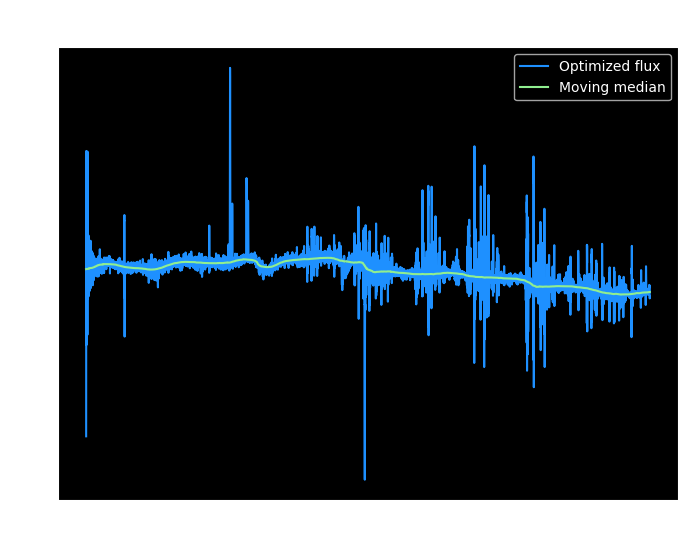

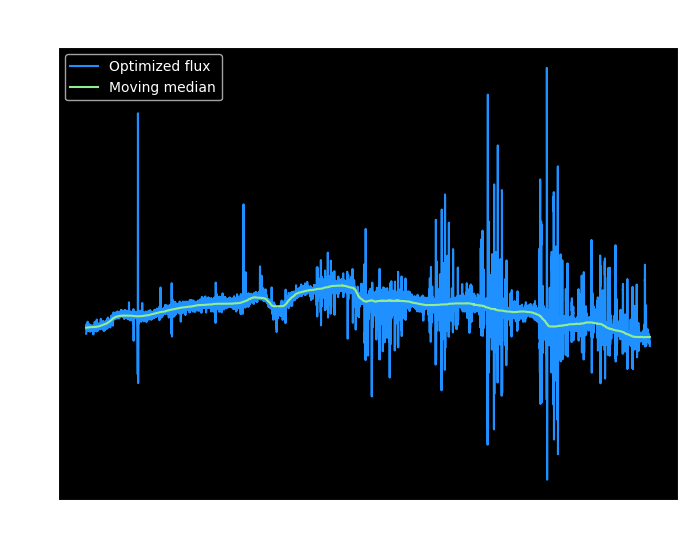

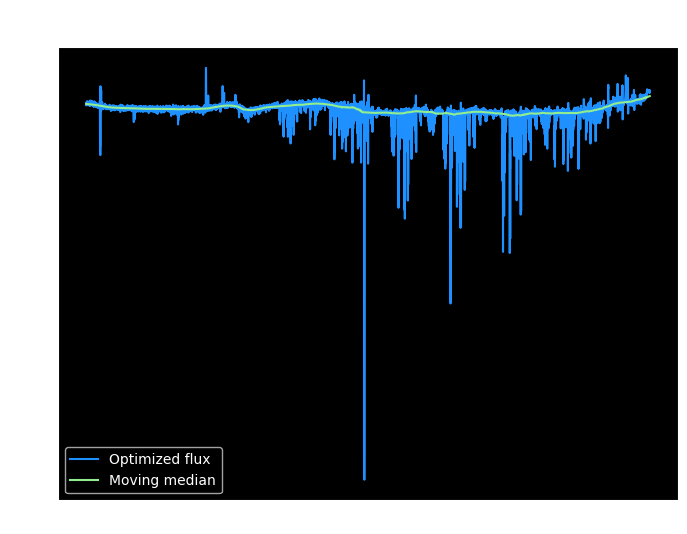

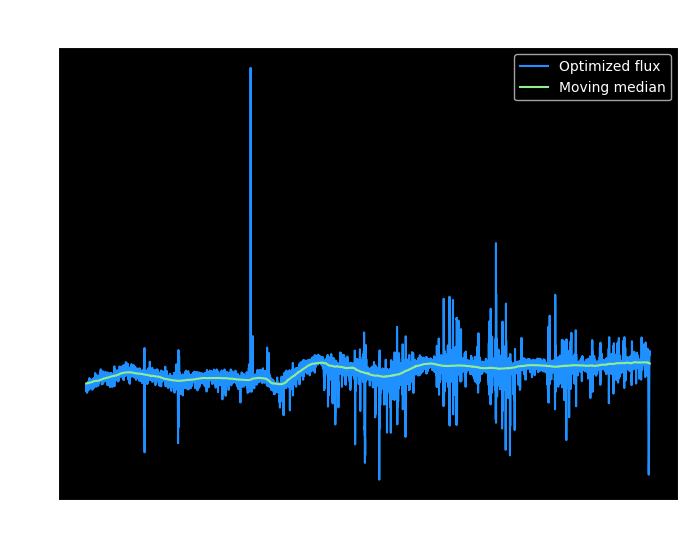

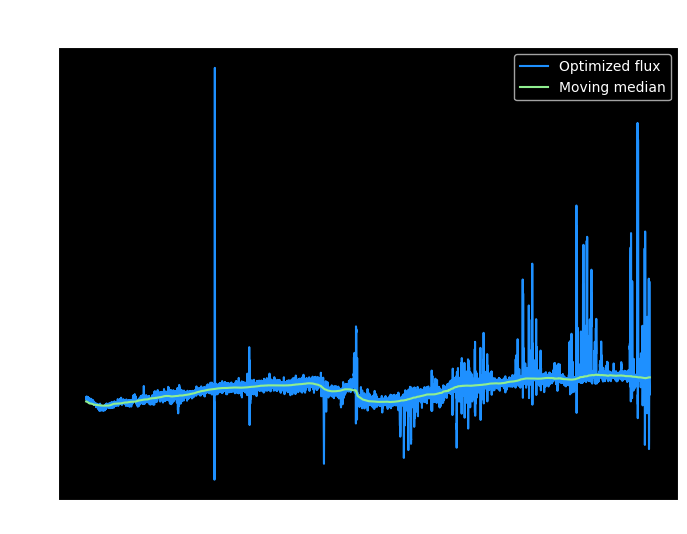

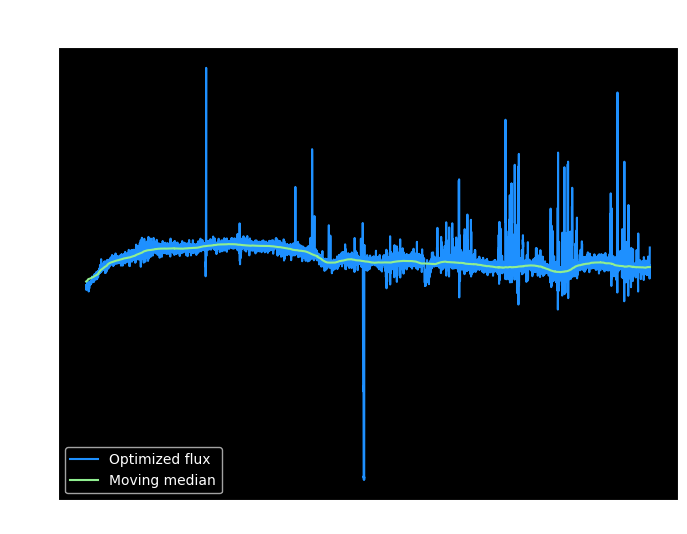

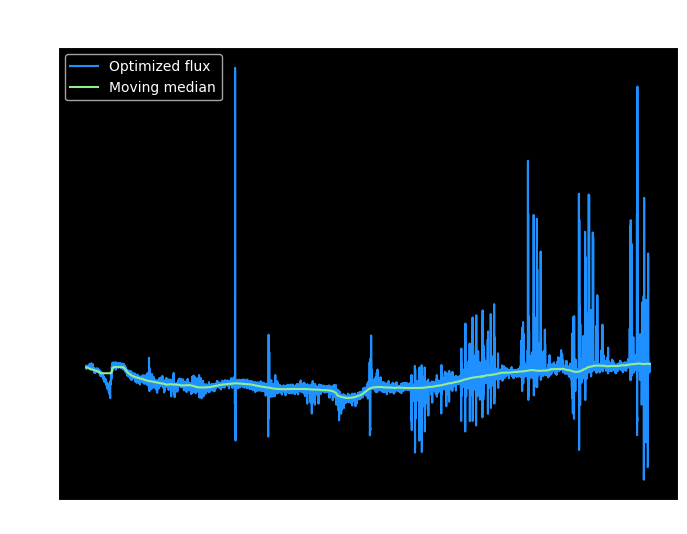

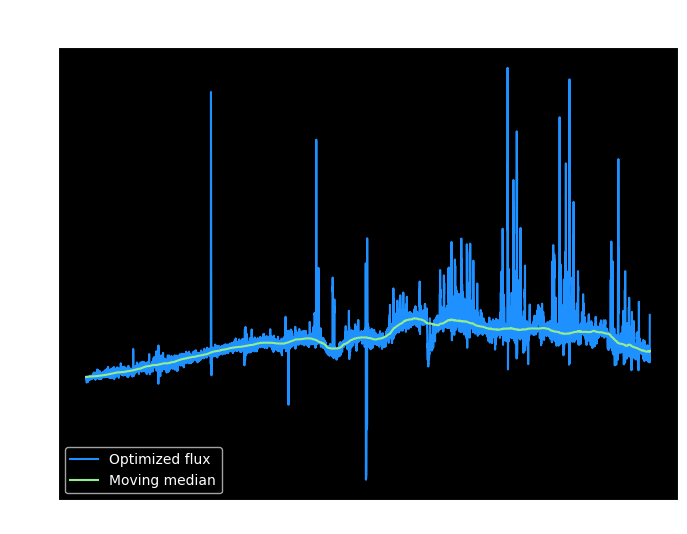

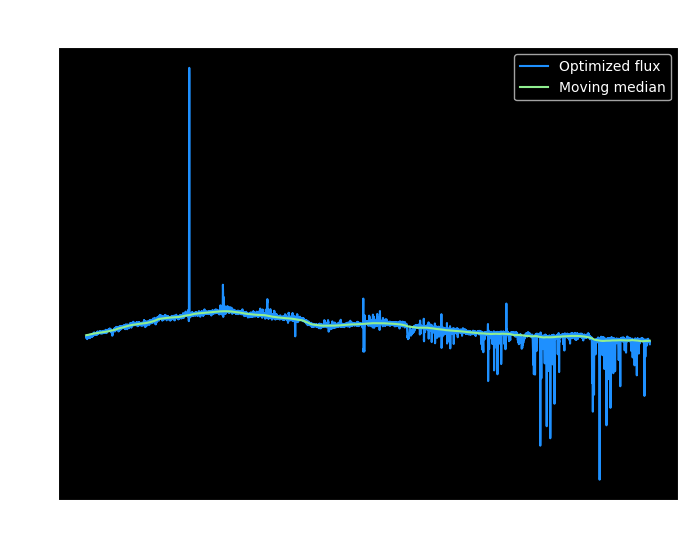

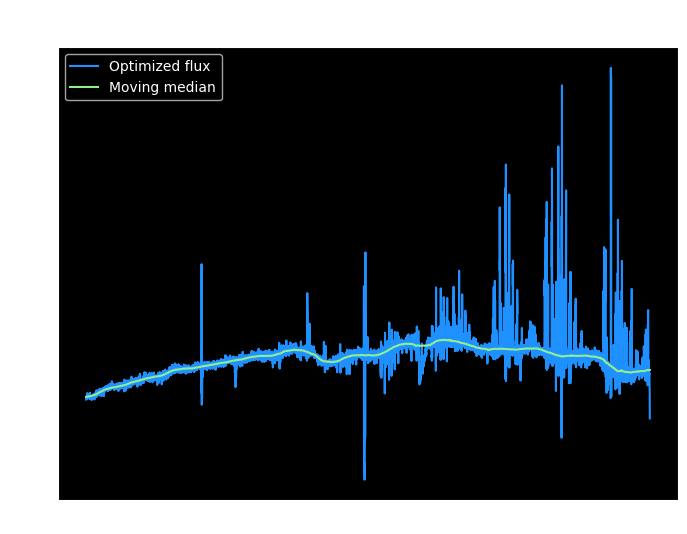

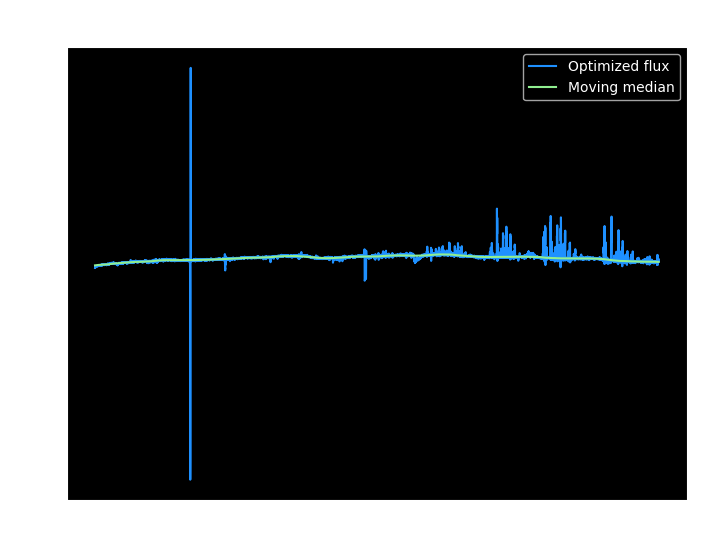

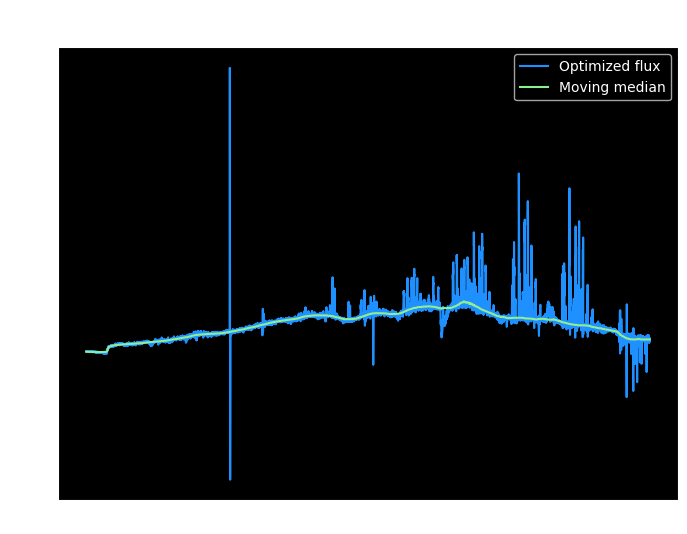

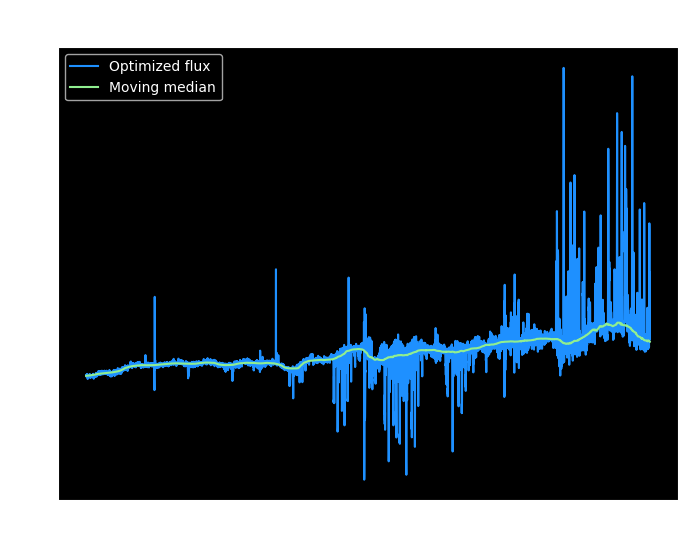

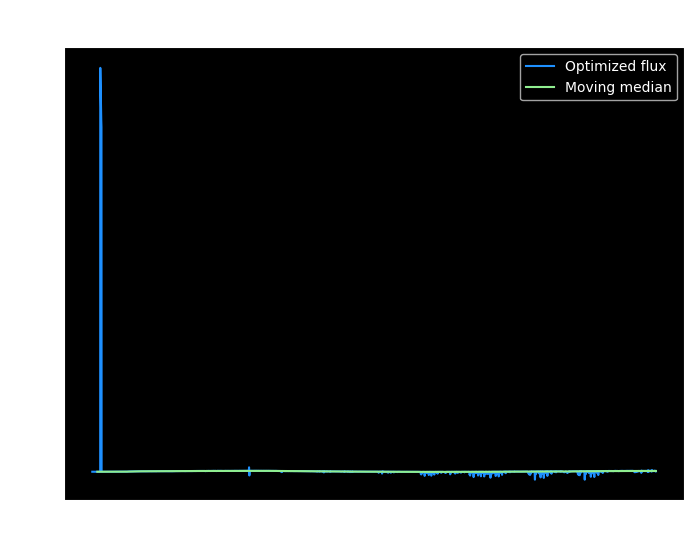

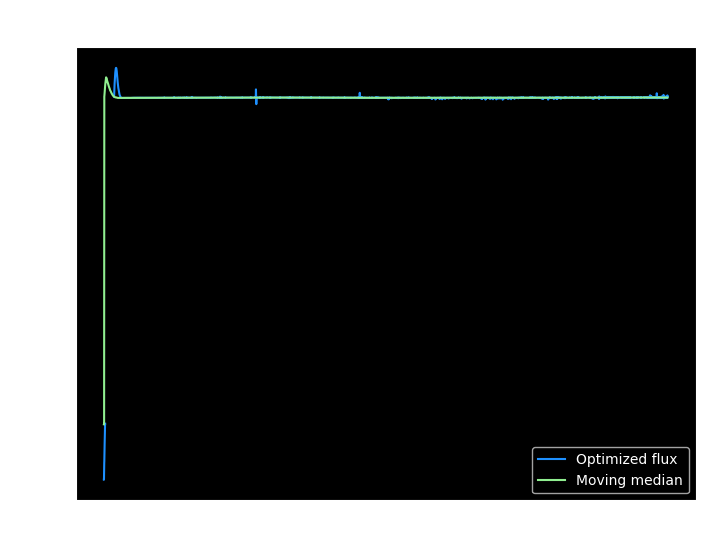

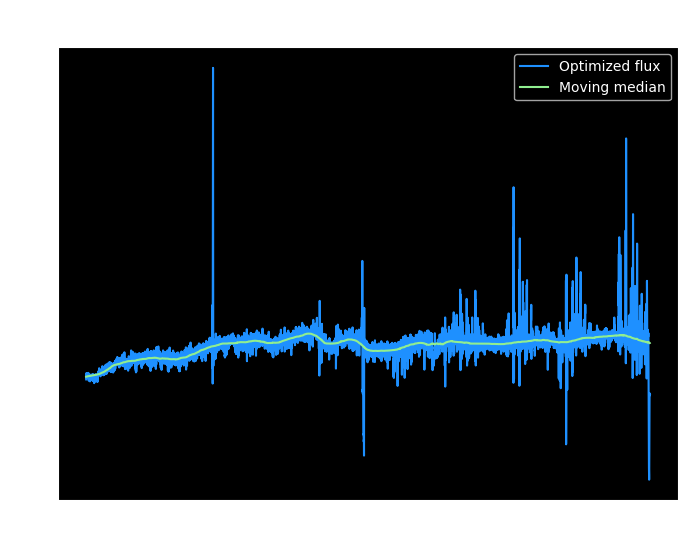

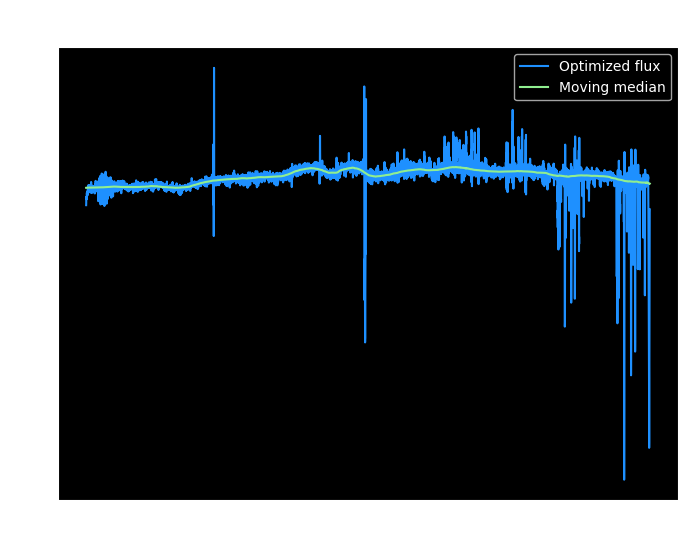

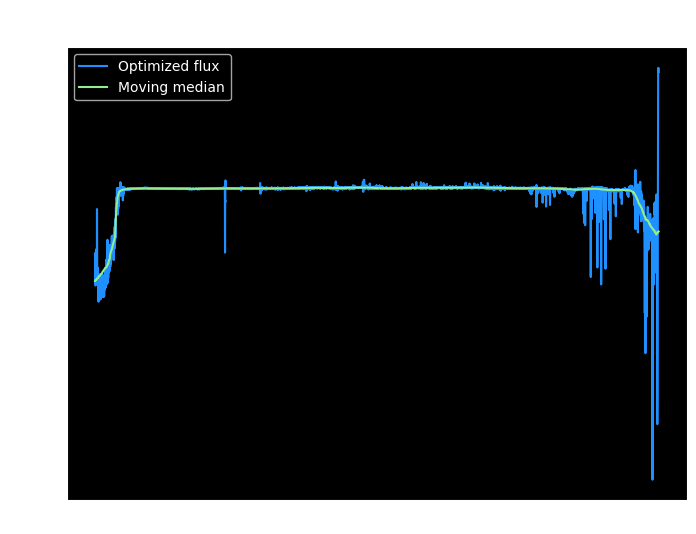

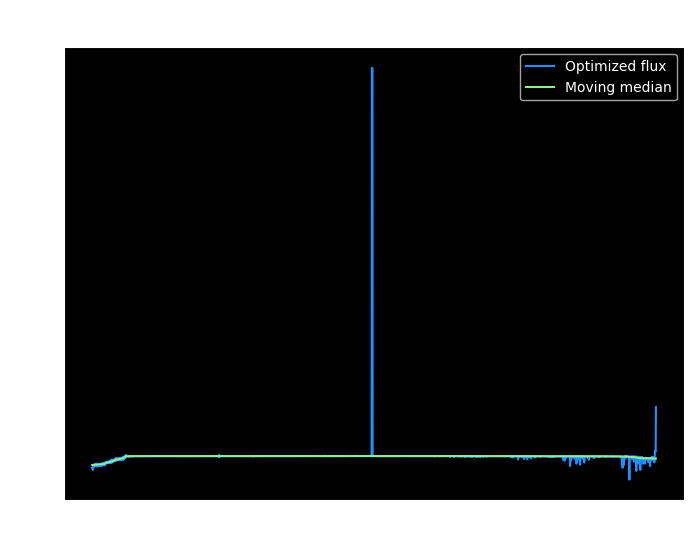

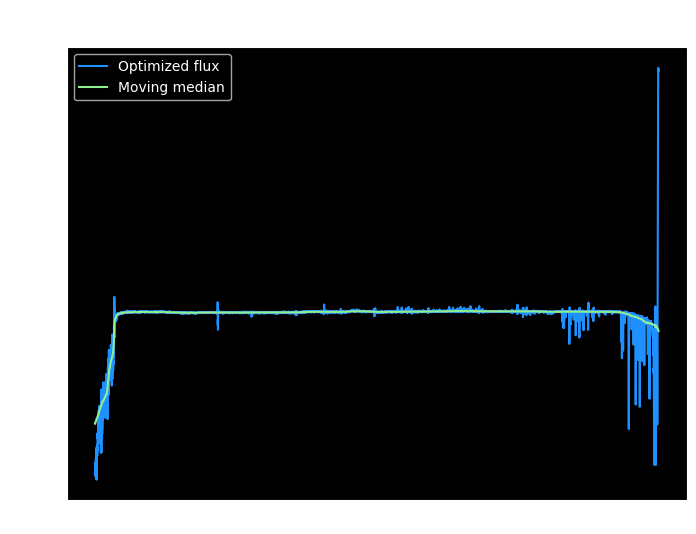

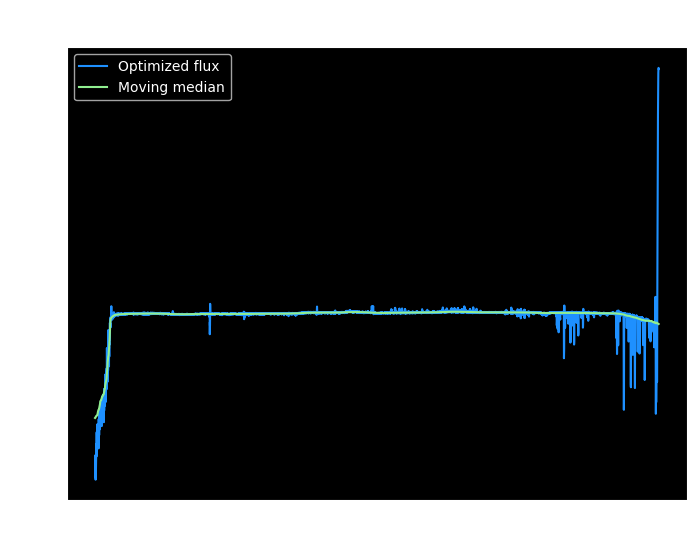

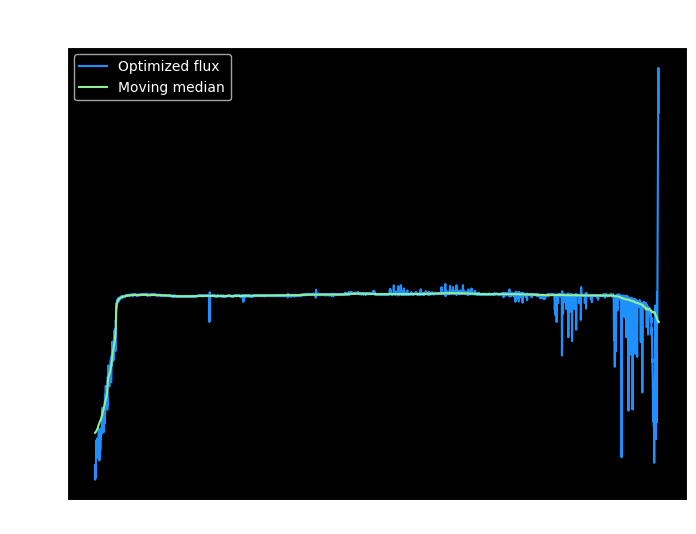

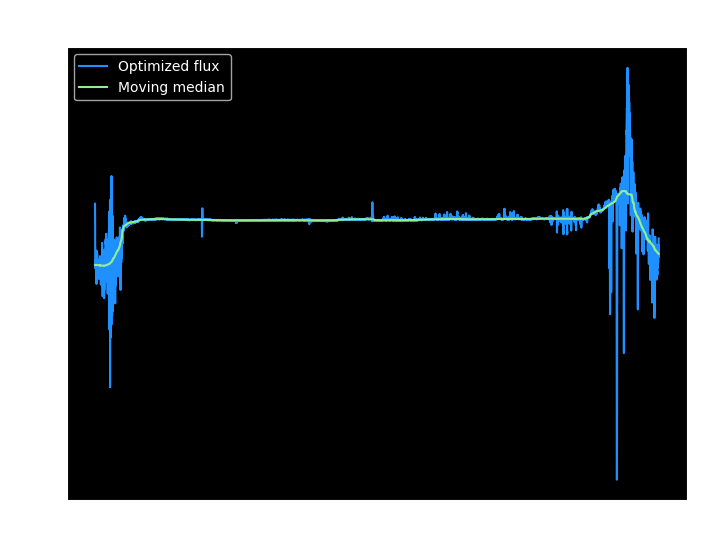

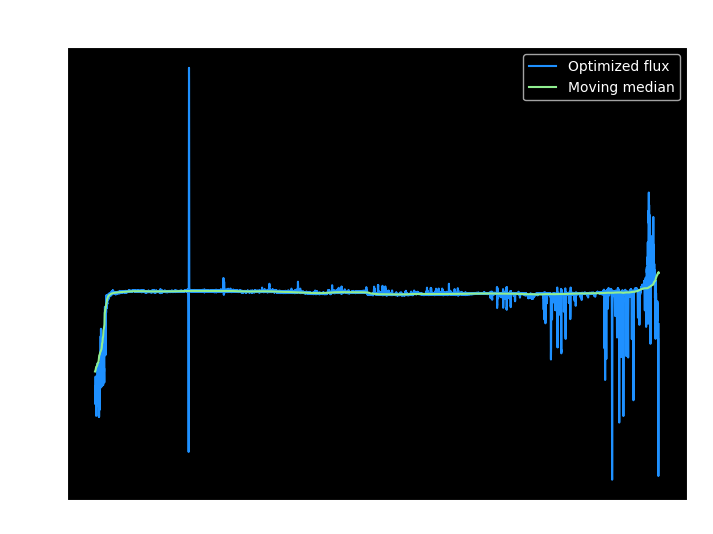

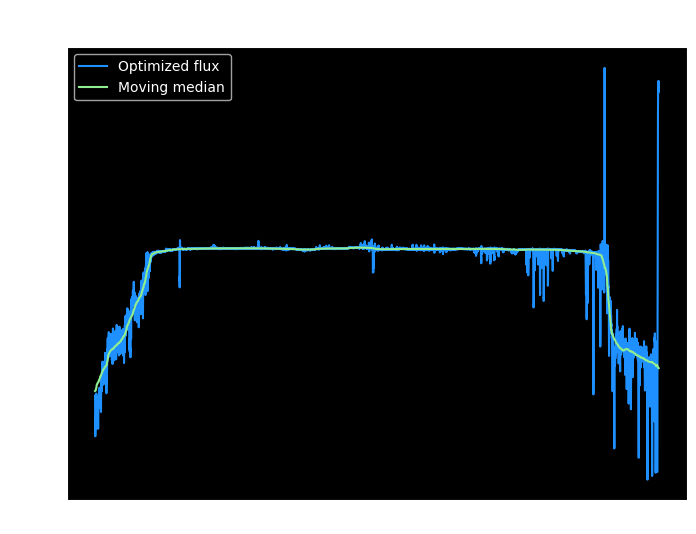

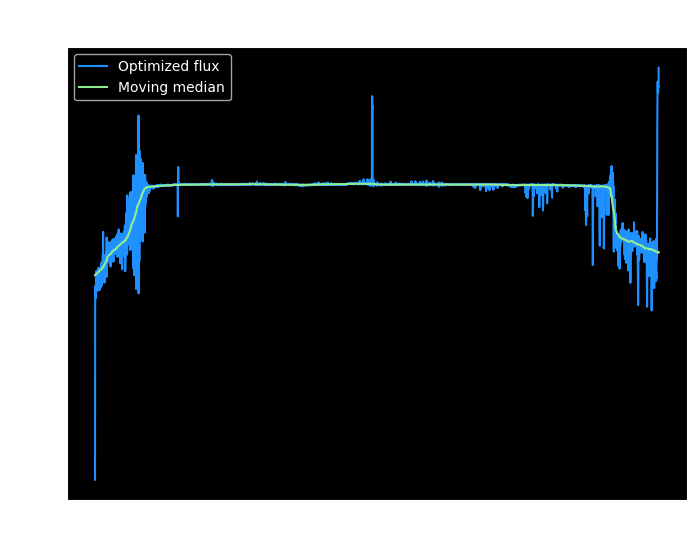

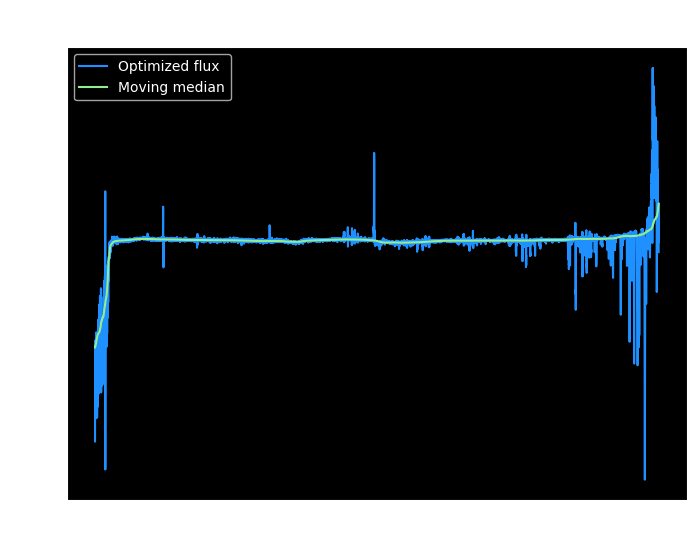

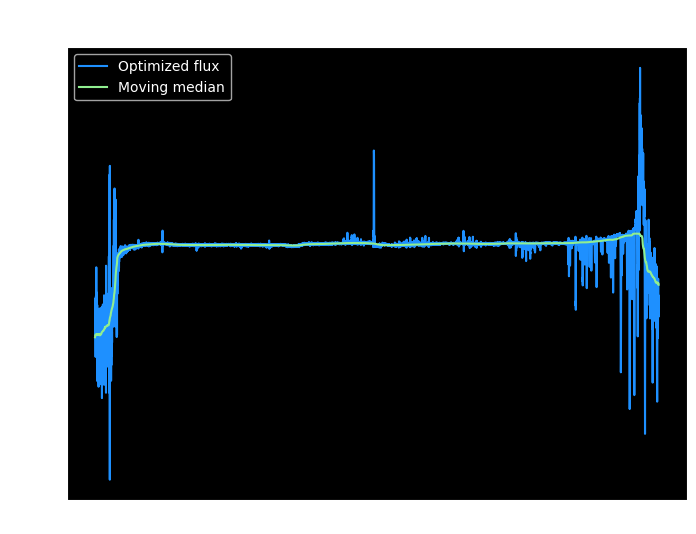

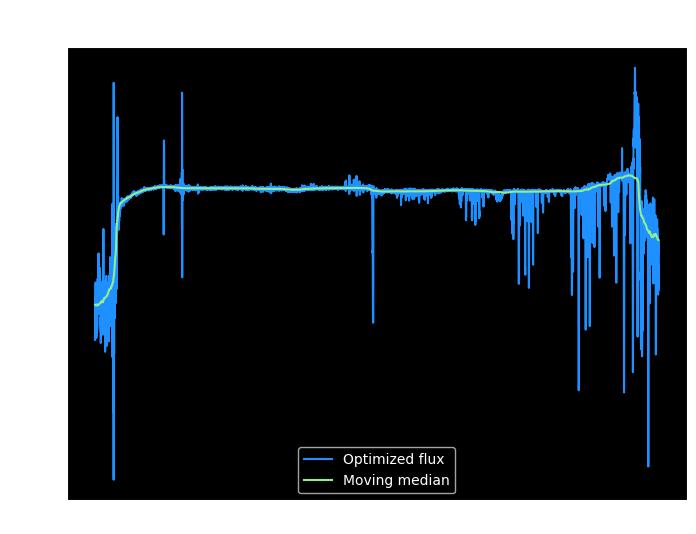

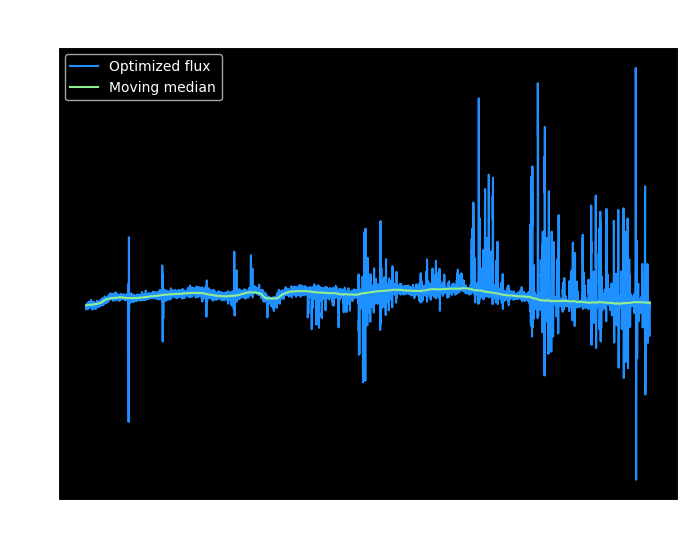

In [17]:
for i in slit_nums:
    test_flux_i = included_fluxes_dict[i]
    moving_median_center_i = moving_median_new(test_flux_i, window=325, center_align=True)
    plt.figure(figsize=(8,6), dpi=100)
    plt.tight_layout()

    # plt.subplot(1,2,1)
    plt.plot(rbwave, test_flux_i, color='dodgerblue', label='Optimized flux')
    plt.plot(rbwave, moving_median_center_i, color='lightgreen', label='Moving median')
    plt.legend()
    plt.title('Optimized flux with starlight contamination\nMask: {0},  Slit:{1}'.format(mask_name,i))
    plt.show()
    plt.close()

In [24]:
list(included_fluxes_dict.keys())

[1,
 10,
 103,
 104,
 105,
 106,
 107,
 11,
 111,
 114,
 115,
 118,
 12,
 13,
 134,
 135,
 14,
 141,
 150,
 157,
 168,
 17,
 173,
 174,
 175,
 178,
 18,
 180,
 183,
 188,
 189,
 19,
 194,
 196,
 198,
 2,
 20,
 200,
 21,
 22,
 25,
 26,
 28,
 29,
 30,
 31,
 32,
 34,
 35,
 38,
 39,
 4,
 46,
 5,
 50,
 54,
 57,
 6,
 61,
 63,
 65,
 66,
 69,
 7,
 75,
 78,
 8,
 80,
 83,
 86,
 90,
 94,
 96]

In [23]:
list(excluded_fluxes_dict.keys())[9]

116